<a href="https://colab.research.google.com/github/lapidesd/CA_missing_freshet/blob/main/Colab_notebooks/Residuals_explain_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
! pip install geopandas
import geopandas as gpd
import numpy as np
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
! pip install hydrofunctions
import hydrofunctions as hf
import pickle
import matplotlib.font_manager as fm
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
matplotlib.rc('font', family='TH Sarabun New')
plt.rcParams.update({'font.size': 12})


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.9 MB/s 
     |████████████████████████████████| 16.7 MB 26.9 MB/s 
     |████████████████████████████████| 6.3 MB 25.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 1.8 MB/s 
     |████████████████████████████████| 1.6 MB 7.3 MB/s 
--2022-09-12 17:13:32--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2022-09-12 17:13:32--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-we

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


## Import information about study sites

In [2]:
# import shapefile of study sites and site info
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/california_site_list.zip'
loc1 = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/KREW_gages.zip'
gages = gpd.read_file(loc).to_crs(epsg = 4326)
gages1 = gpd.read_file(loc1).to_crs(epsg = 4326)
gages1['SITE_NO'] = gages1.Name
gages1['STATION_NM'] = ['Providence 300',
                        'Providence 301',
                        'Providence 303',
                        'Providence 304',
                        'Bull D102',
                        'Bull B200',
                        'Bull B201',
                        'Bull B203',
                        'Bull B204',
                        'Bull T003']
gages1.drop(columns=['Site','Northing','Easting','Name'],inplace=True)
gages1['LON_SITE'] = [p.x for p in gages1.geometry]
gages1['LAT_SITE'] = [p.y for p in gages1.geometry]
gages1 = gages1.iloc[[0,5]]
gages = pd.concat([gages,gages1])
# import basin outlines
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/california_site_watershed_boundaries.zip'
loc1 = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/KREW_watersheds.zip'
basin_outlines = gpd.read_file(loc).to_crs(epsg = 4326)
basin_outlines1 = gpd.read_file(loc1).rename(columns={'watershed':'SITE_NO'}).to_crs(epsg=4326)
basin_outlines1['SQMI'] = basin_outlines1.Area_ha*0.00386102
basin_outlines1.drop(columns='Area_ha',inplace=True)
basin_outlines1 = basin_outlines1.iloc[[4,9]]
basin_outlines = pd.concat([basin_outlines,basin_outlines1])
gage_info = gages.merge(basin_outlines,left_on='SITE_NO',
            right_on='SITE_NO')
# US state map from https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-state-and-equivalent-national
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/state_outline.zip'
state_outline = gpd.read_file(loc).to_crs(epsg = 4326)
state_outline = state_outline[state_outline.STUSPS=='CA']

## Import analysis results about SWE, deficits, ET, and streamflow

In [3]:

# bring in WY totals from deficit and ET calculations
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/WY_data_allsites.csv'
aggregate_wy_data = pd.read_csv(loc).set_index('wy')

base_loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/site_data_wy_totals/all_deficit_data_'
wy_totals = {}
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = pd.read_csv(base_loc+str(sitenum)+'.csv').set_index('wy')

# combine with April 1 SWE and spring/january streamflow and residuals
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/april_swe_study_sites_mm.csv'
aprilSWE = pd.read_csv(loc).set_index('wy')
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/spring_streamflow_mm.csv'
springflow = pd.read_csv(loc).set_index('wy')
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/swe_q_residuals_mm.csv'
residuals = pd.read_csv(loc).set_index('wy')
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/january_mean_flow_mm_day.csv'
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = wy_totals[sitenum].merge(aprilSWE[[sitenum]].rename(columns={sitenum:'aprSWE'}),
                                                left_index=True,right_index=True)
  wy_totals[sitenum] = wy_totals[sitenum].merge(springflow[[sitenum]].rename(columns={sitenum:'springQ'}),
                                                left_index=True,right_index=True)
  wy_totals[sitenum] = wy_totals[sitenum].merge(residuals[[sitenum]].rename(columns={sitenum:'residuals'}),
                                                left_index=True,right_index=True)


meanAprSWE = aprilSWE.mean(axis=1).to_frame().rename(columns={0:'aprSWE'})
meanSpringQ = springflow.mean(axis=1).to_frame().rename(columns={0:'springQ'})
res_all = residuals.drop(columns='all_sites').sum(axis=1).to_frame().rename(columns={0:'residuals'})
aggregate_wy_data = aggregate_wy_data.merge(meanAprSWE,left_index=True,right_index=True)
aggregate_wy_data = aggregate_wy_data.merge(meanSpringQ,left_index=True,right_index=True)
aggregate_wy_data = aggregate_wy_data.merge(res_all,left_index=True,right_index=True)

padj_all = ''
for key in wy_totals:
  if len(padj_all)==0:
    padj_all = wy_totals[key][['adjP']].rename(columns={'adjP':key})
  else:
    padj_all = padj_all.merge(wy_totals[key][['adjP']].rename(columns={'adjP':key}),
                              left_index=True,right_index=True)
aggregate_wy_data['adjP'] = padj_all.mean(axis=1)


# bring in melt rates
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/melt_rates.csv'
meltrates = pd.read_csv(loc).set_index('wy')
aggregate_wy_data = aggregate_wy_data.merge(meltrates.mean(axis=1).to_frame().rename(columns={0:'melt_rate'}),
                                            left_index=True, right_index=True)
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = wy_totals[sitenum].merge(meltrates[[sitenum]].rename(columns={sitenum:'melt_rate'}),
                                                left_index=True, right_index=True)
  
# bring in spring streamflow
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/spring_streamflow_mm.csv'
springflow = pd.read_csv(loc).set_index('wy')
aggregate_wy_data = aggregate_wy_data.merge(springflow.mean(axis=1).to_frame().rename(columns={0:'springflow'}),
                                            left_index=True, right_index=True)
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = wy_totals[sitenum].merge(springflow[[sitenum]].rename(columns={sitenum:'springflow'}),
                                                left_index=True, right_index=True)


## Use a random forest to explore relative importance of proposed mechanisms

In [ ]:
import joblib
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import r2_score

R2 = 0.94


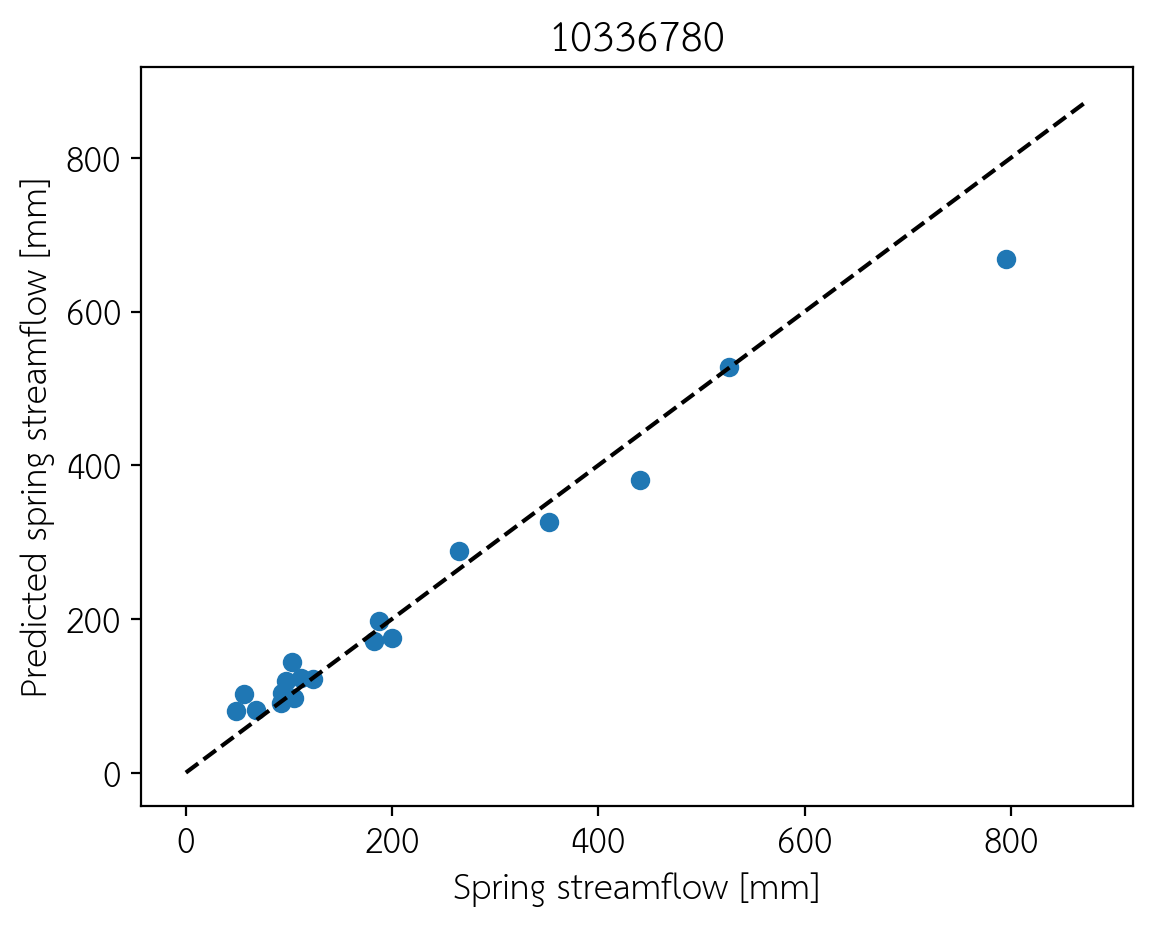

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


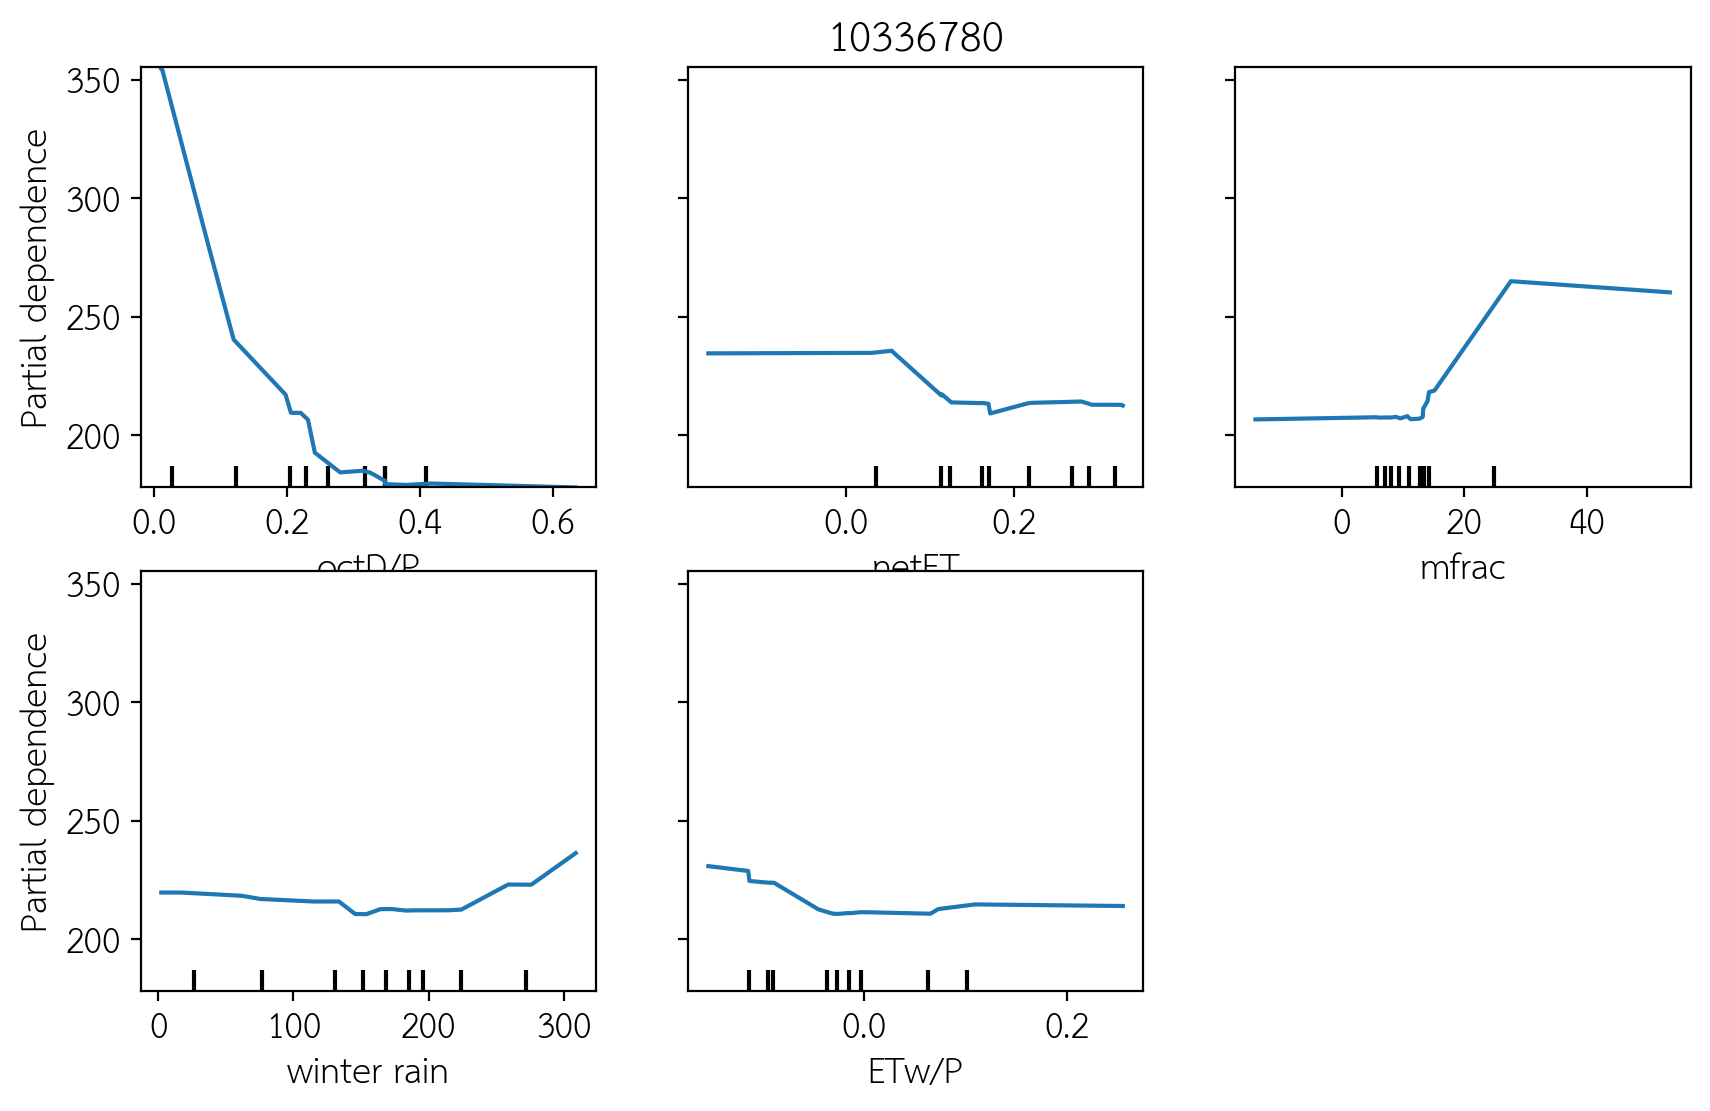


R2 = 0.92


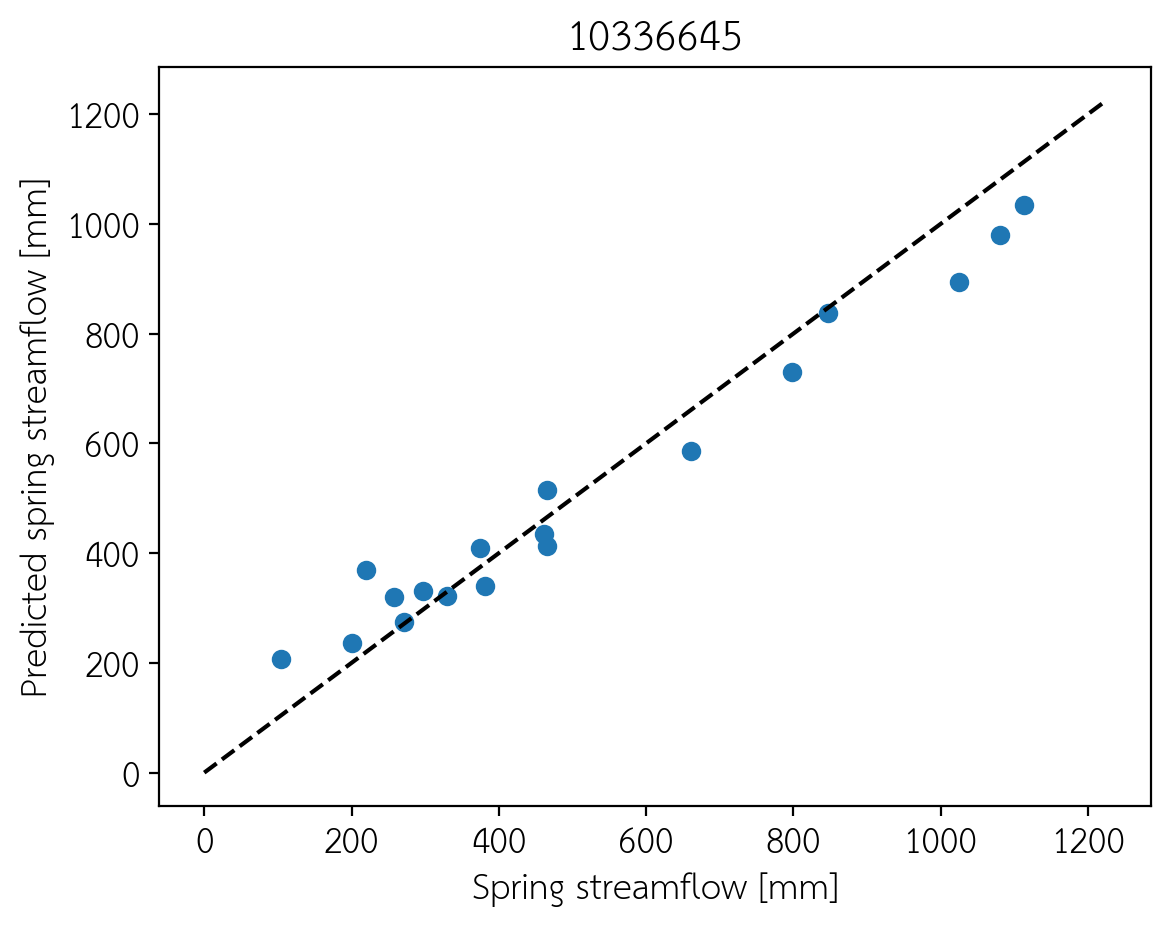

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


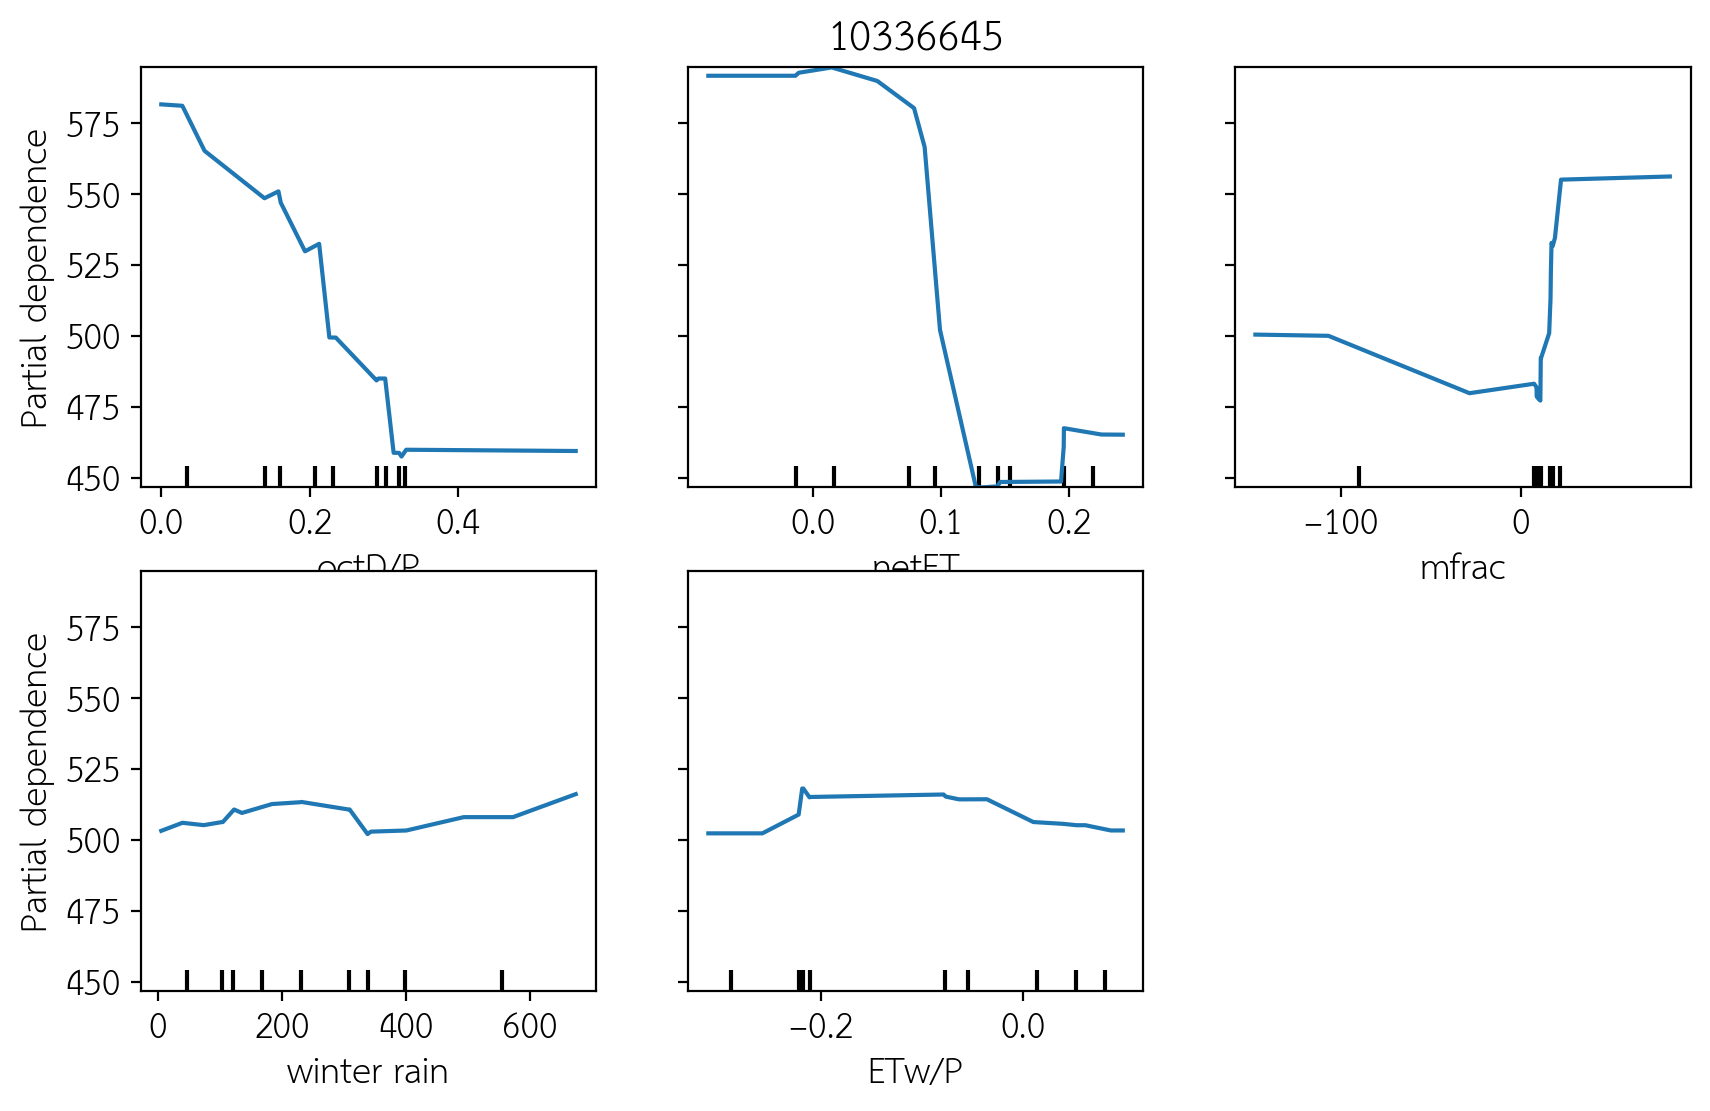


R2 = 0.96


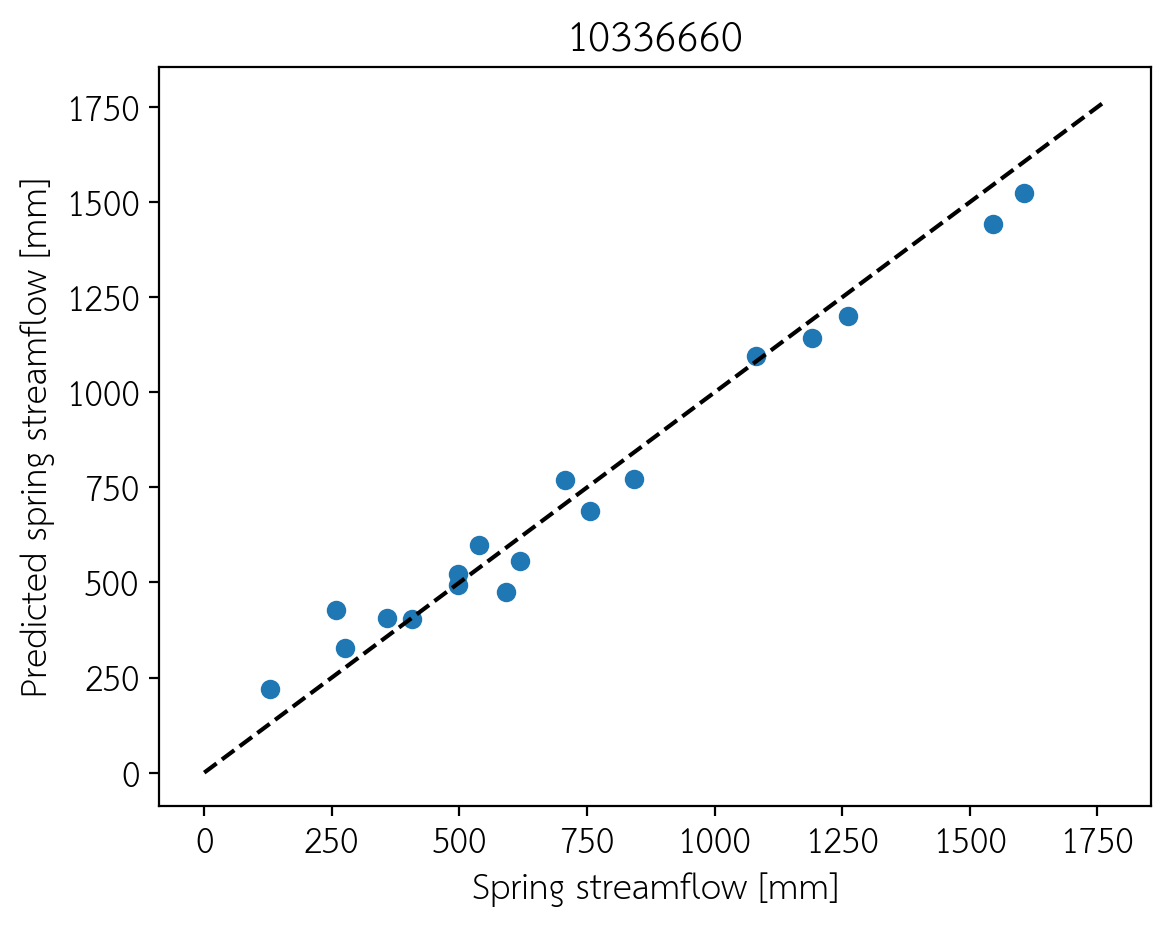

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


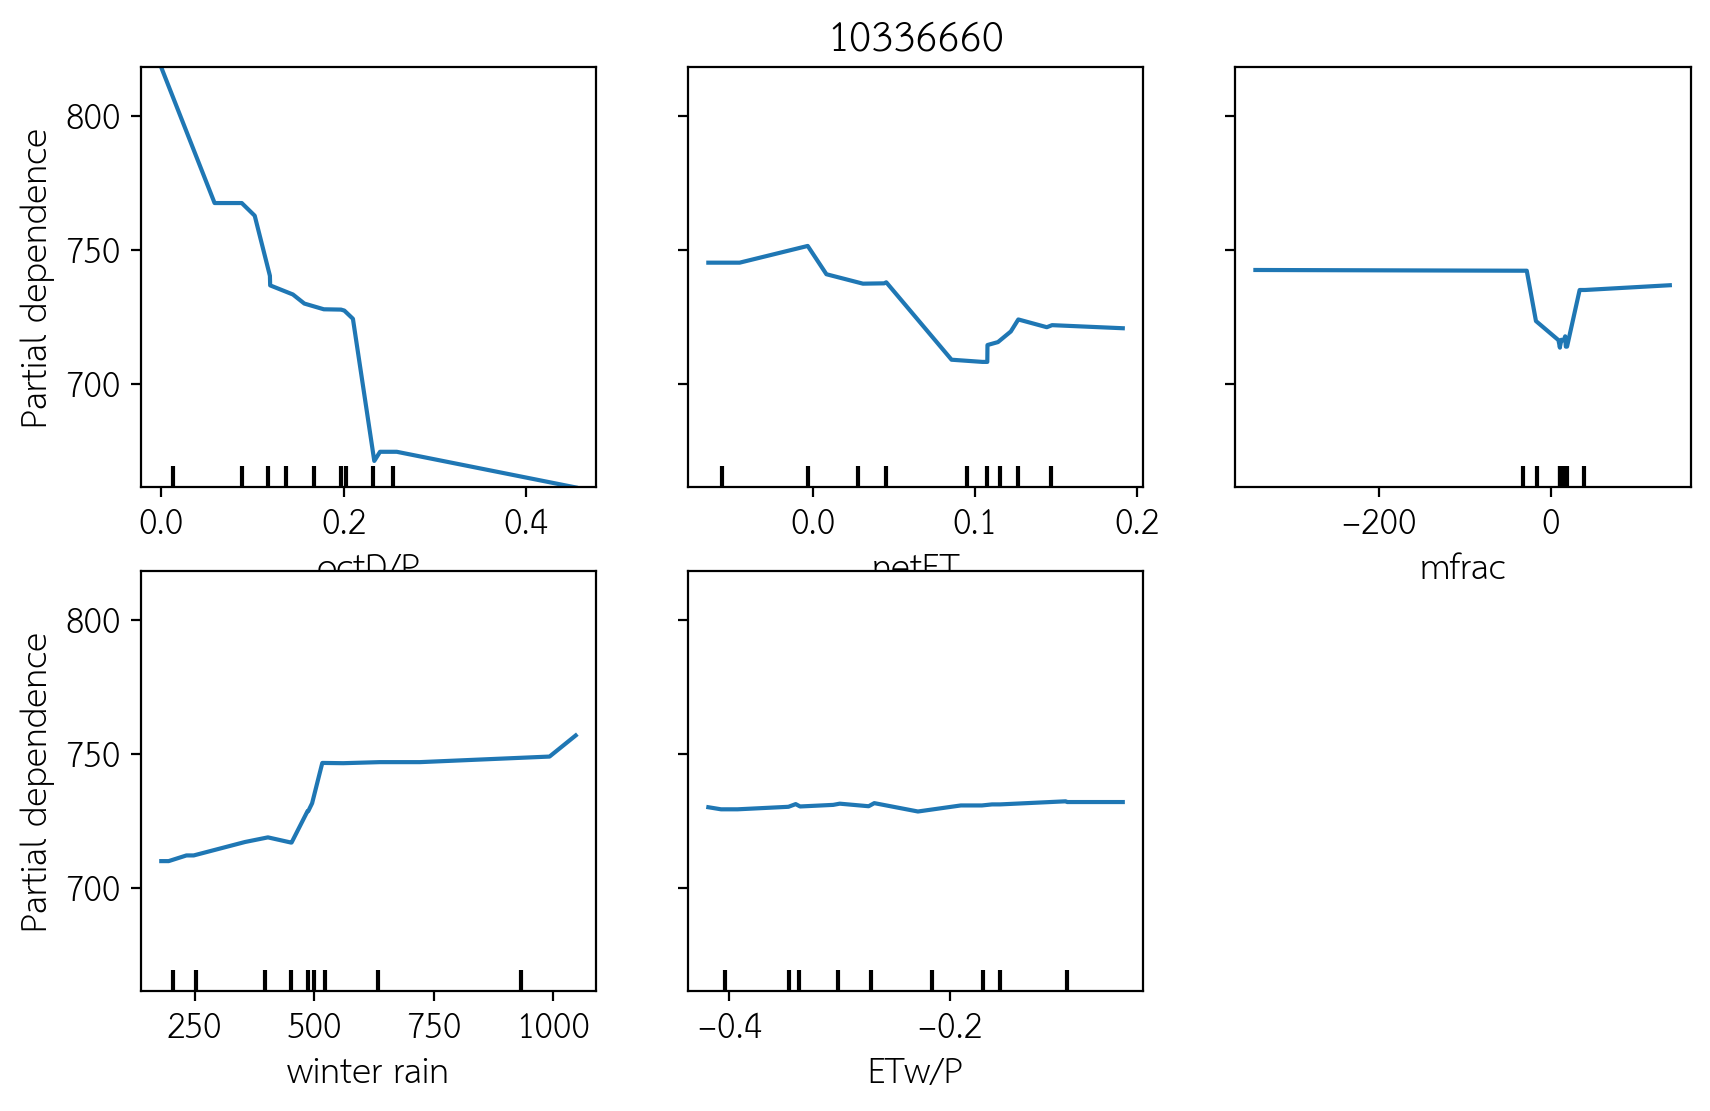


R2 = 0.97


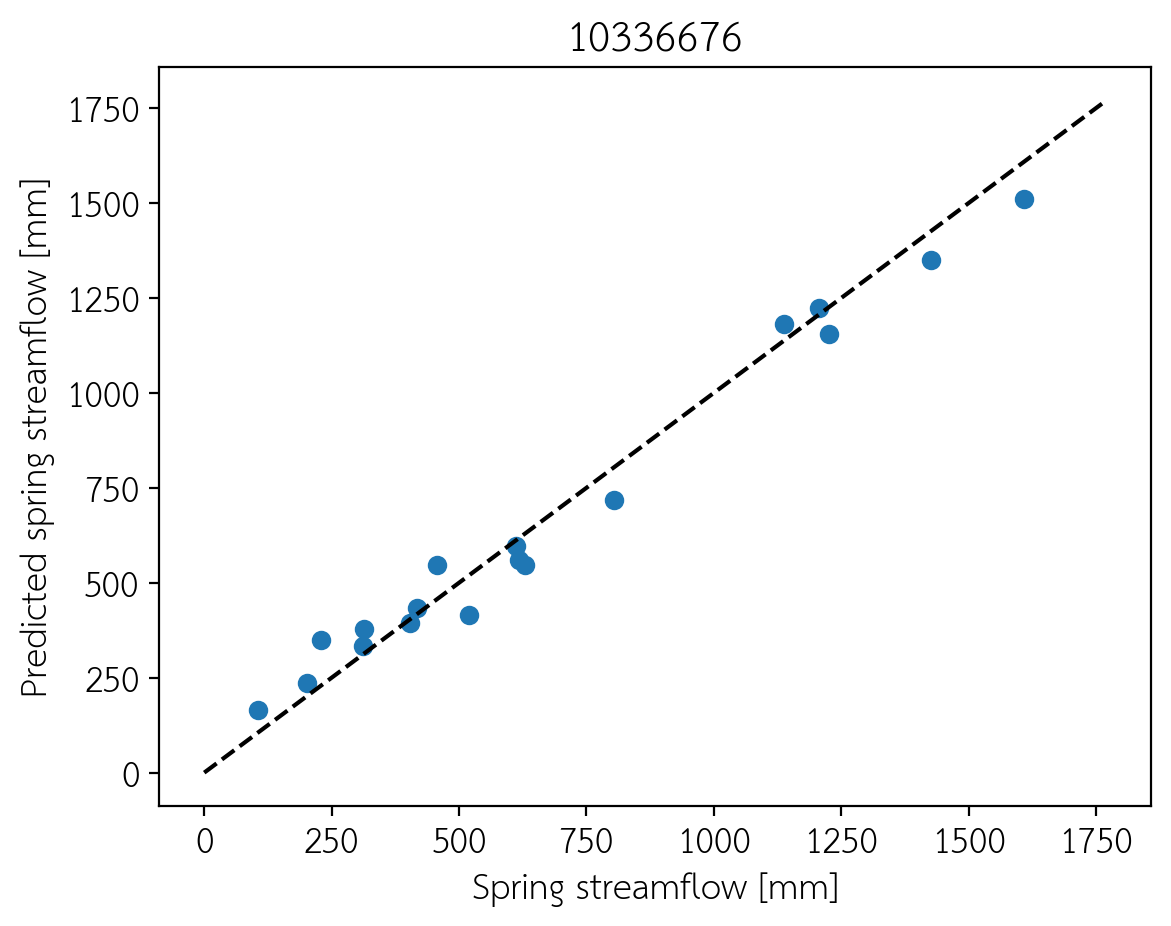

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


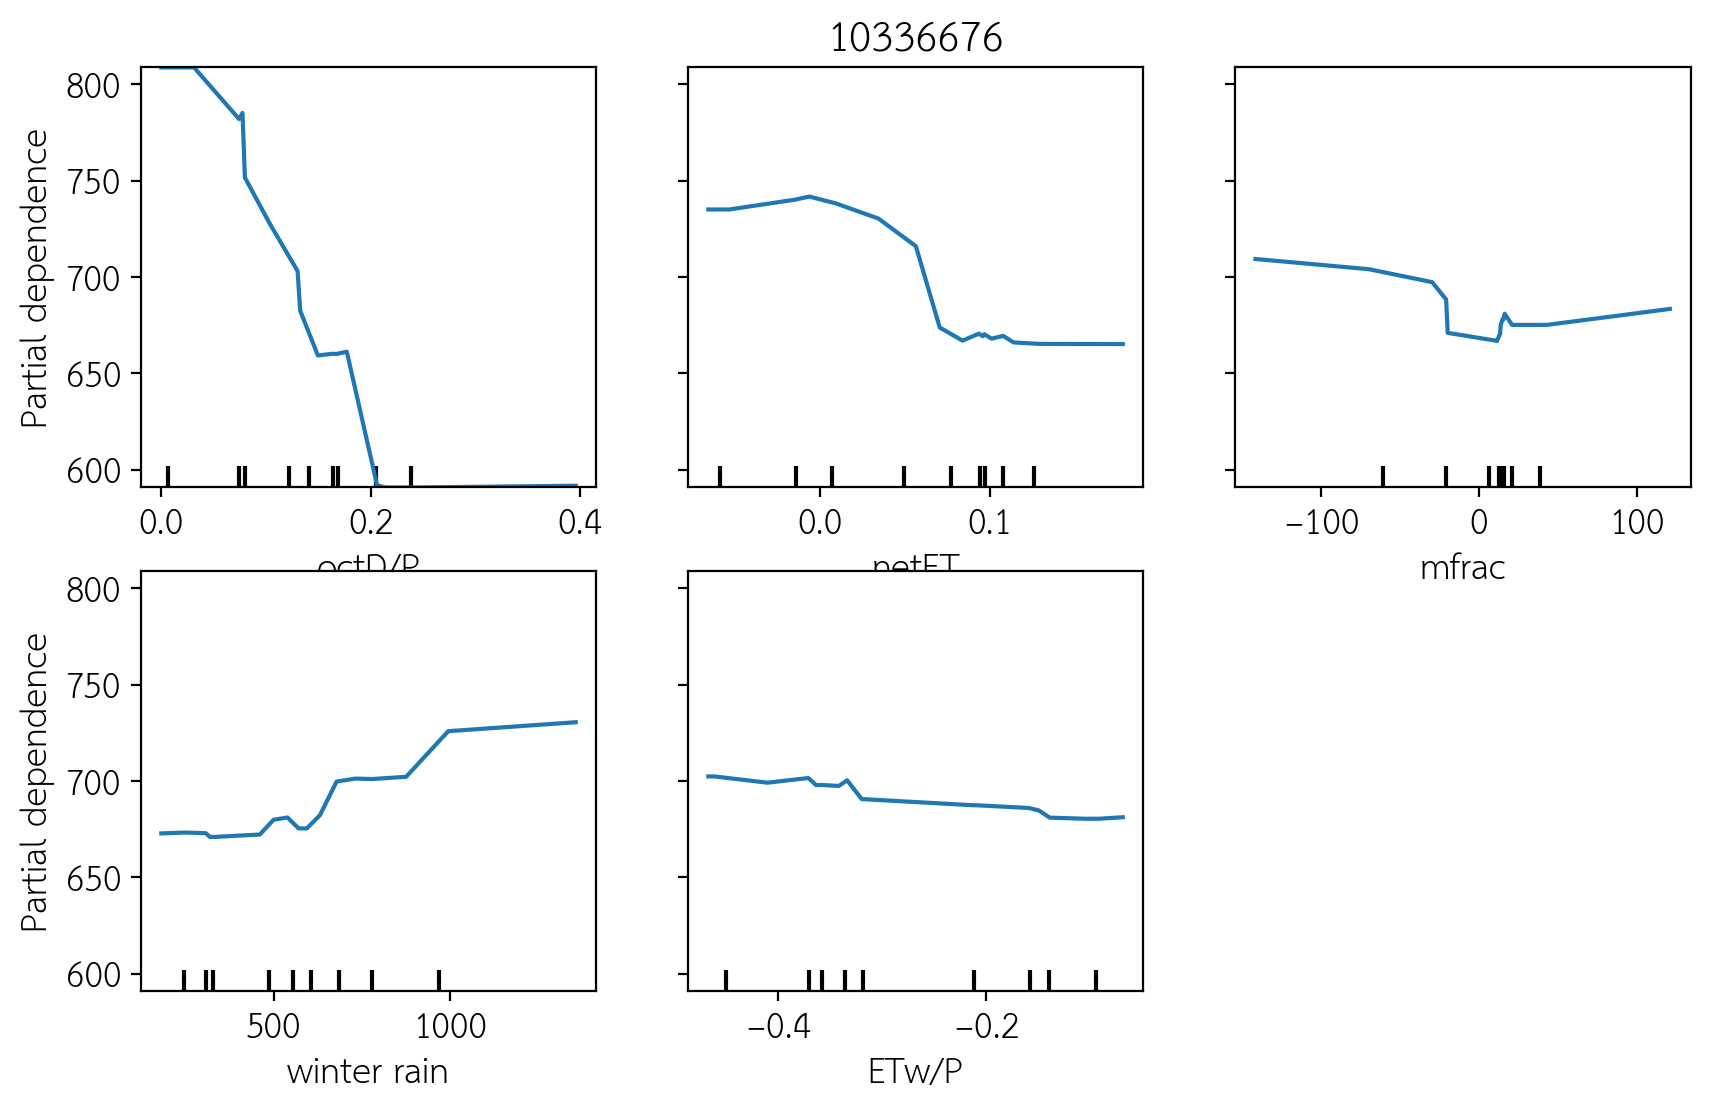


R2 = 0.91


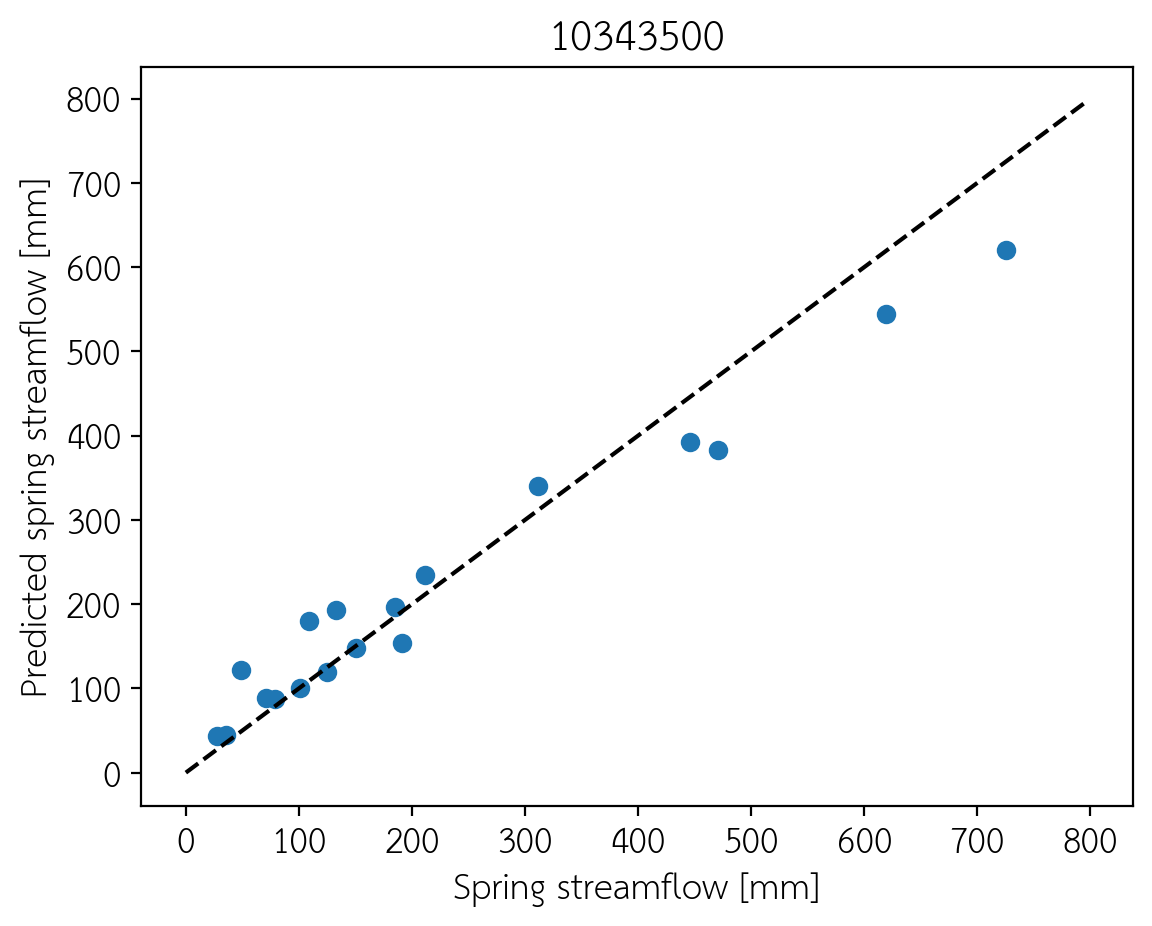

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


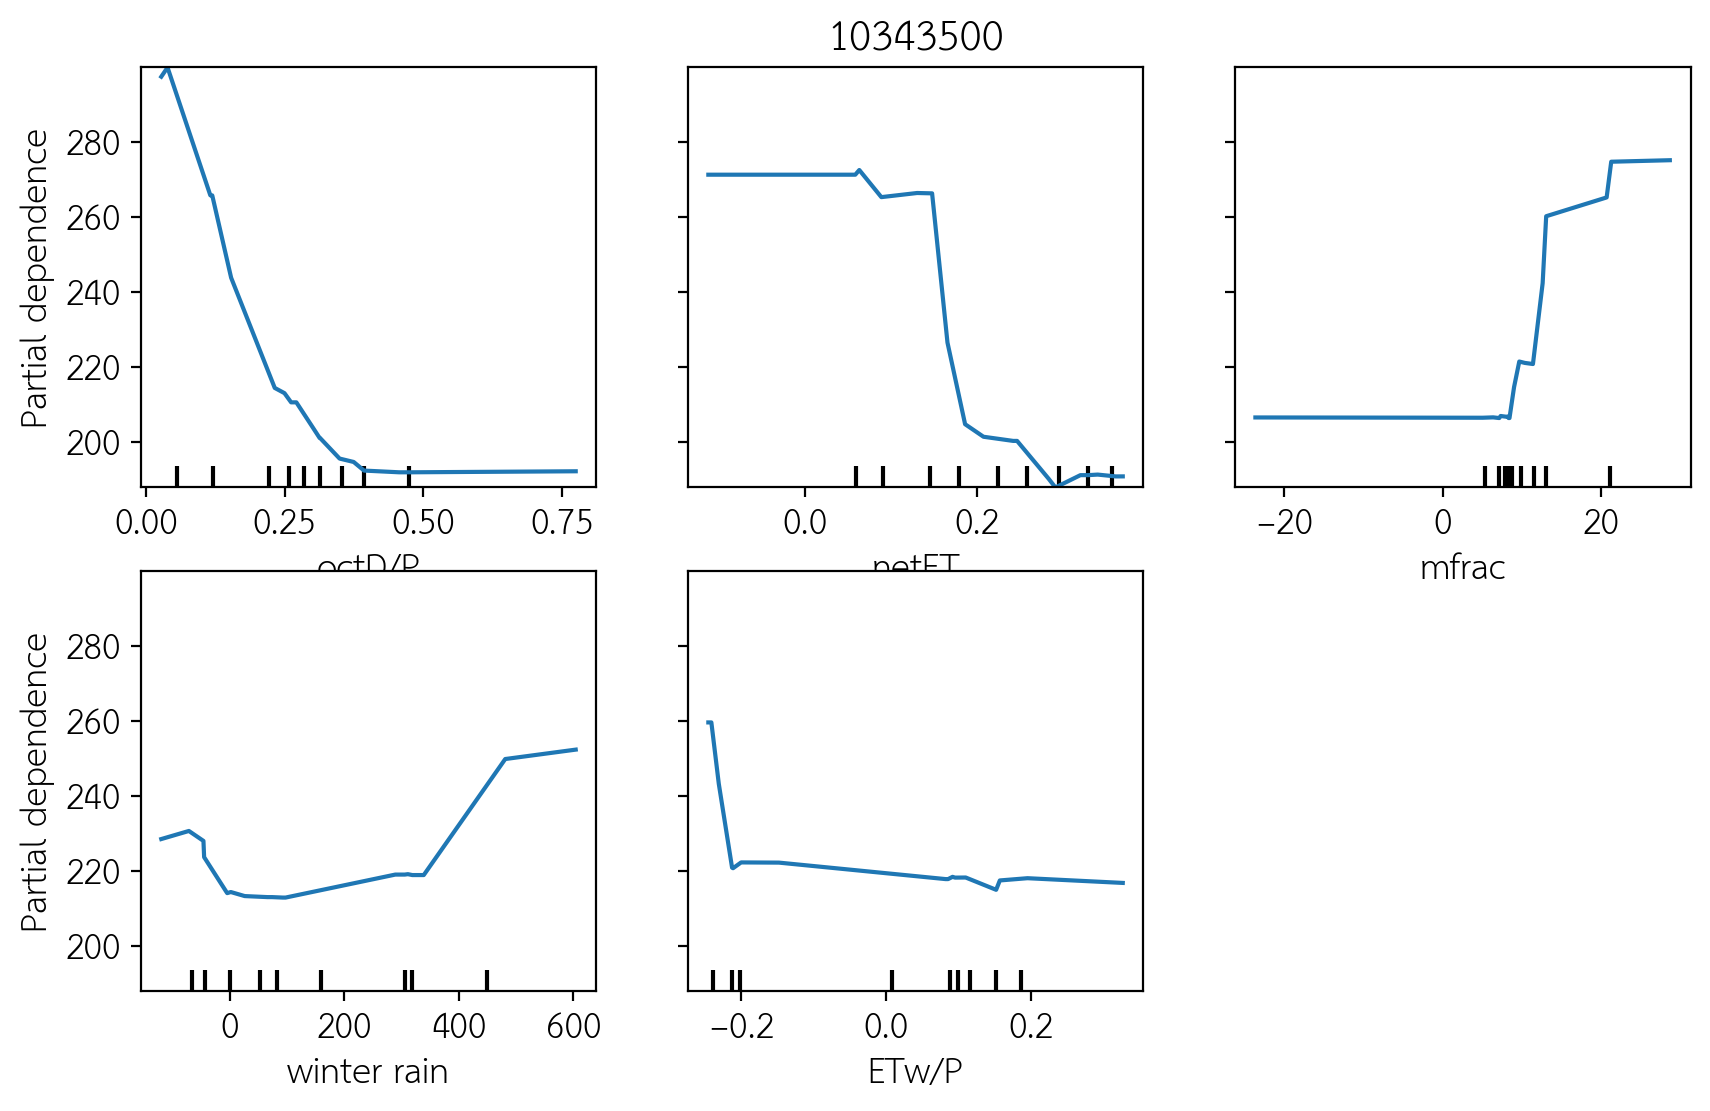


R2 = 0.89


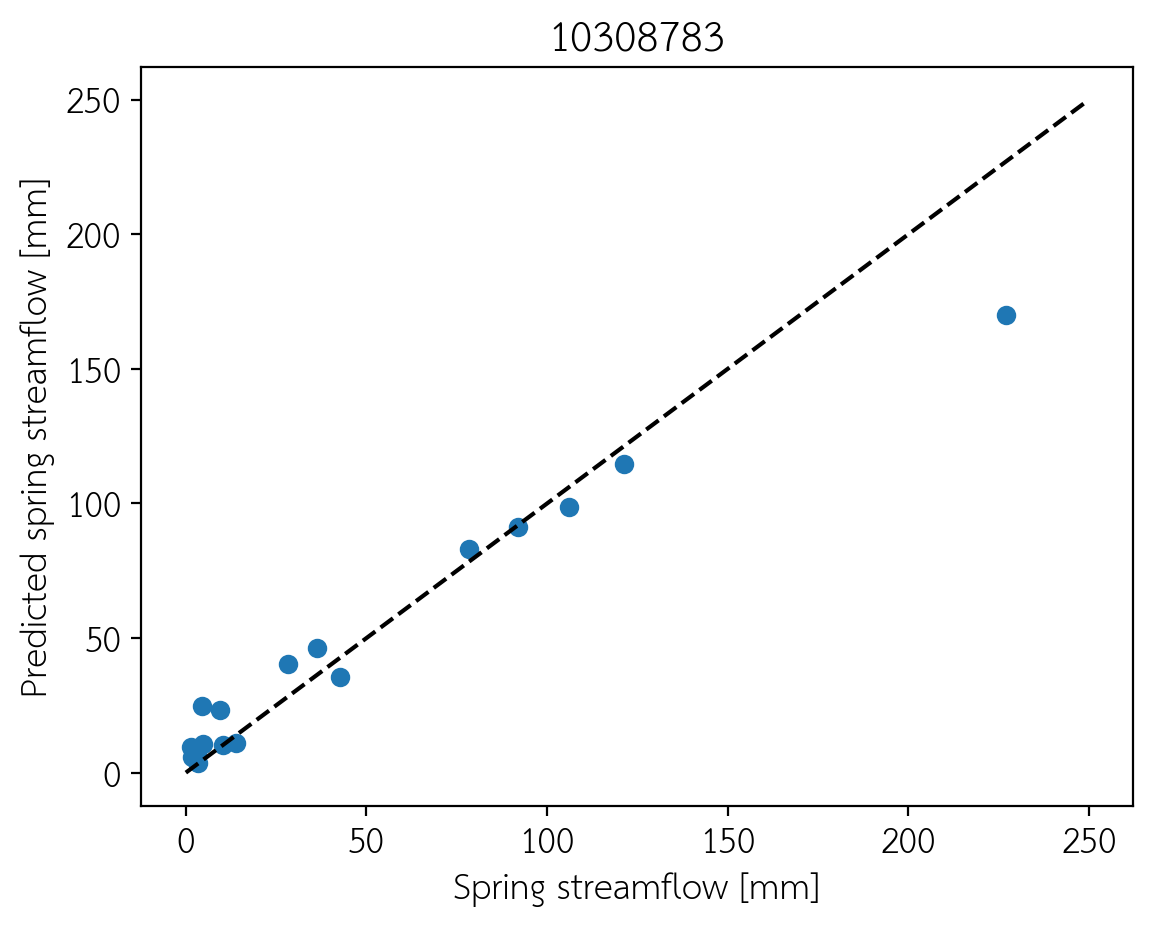

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


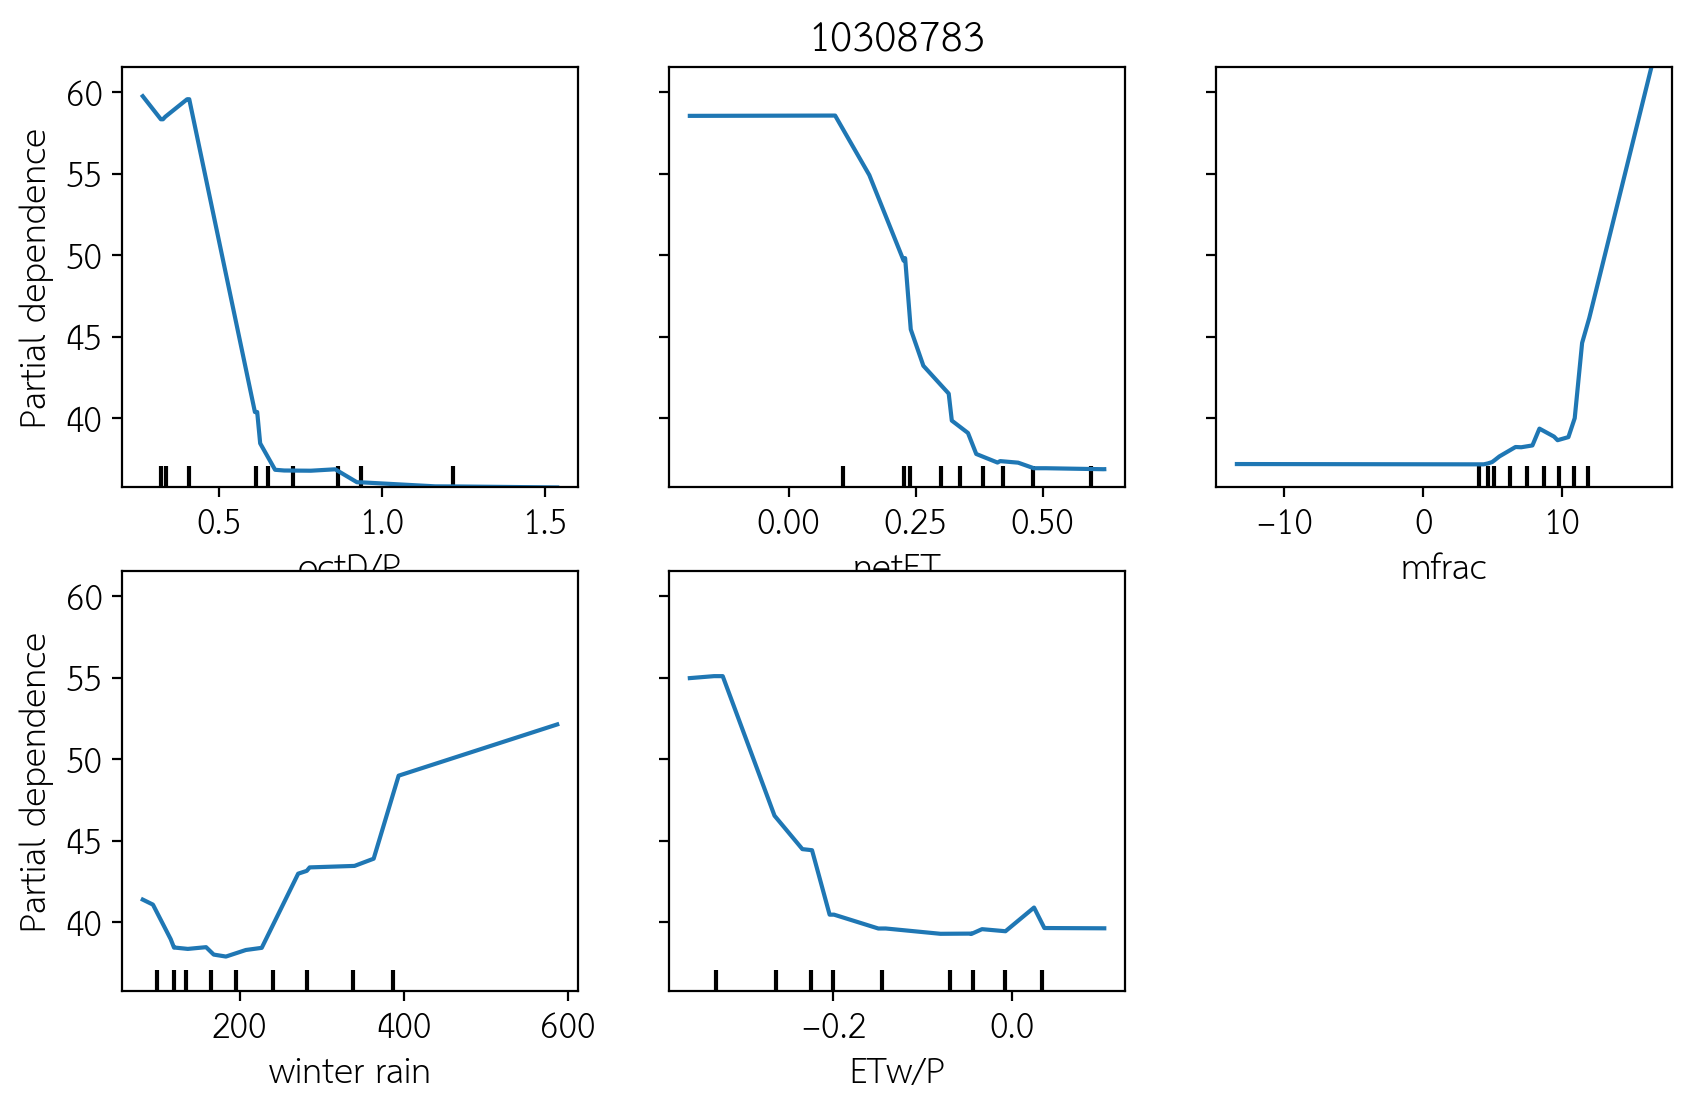


R2 = 0.81


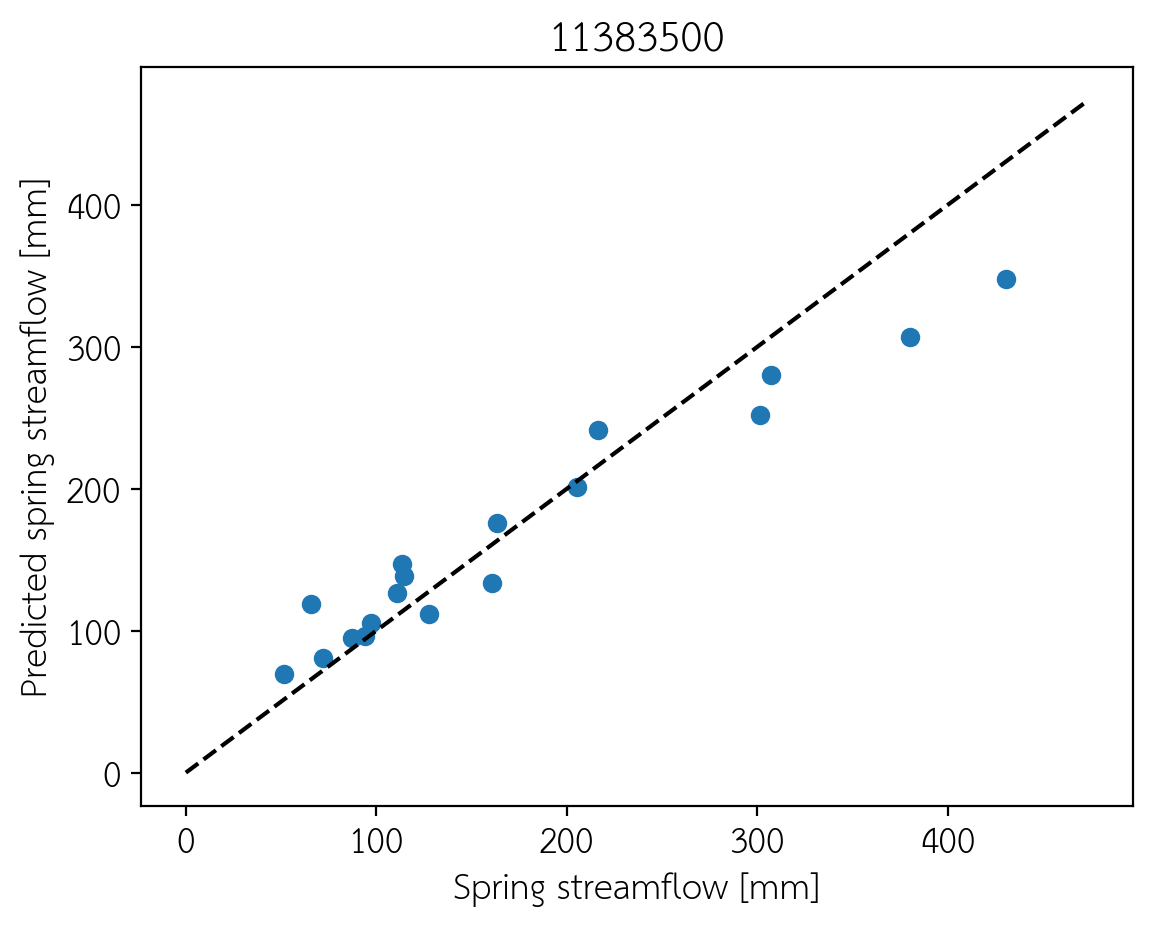

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


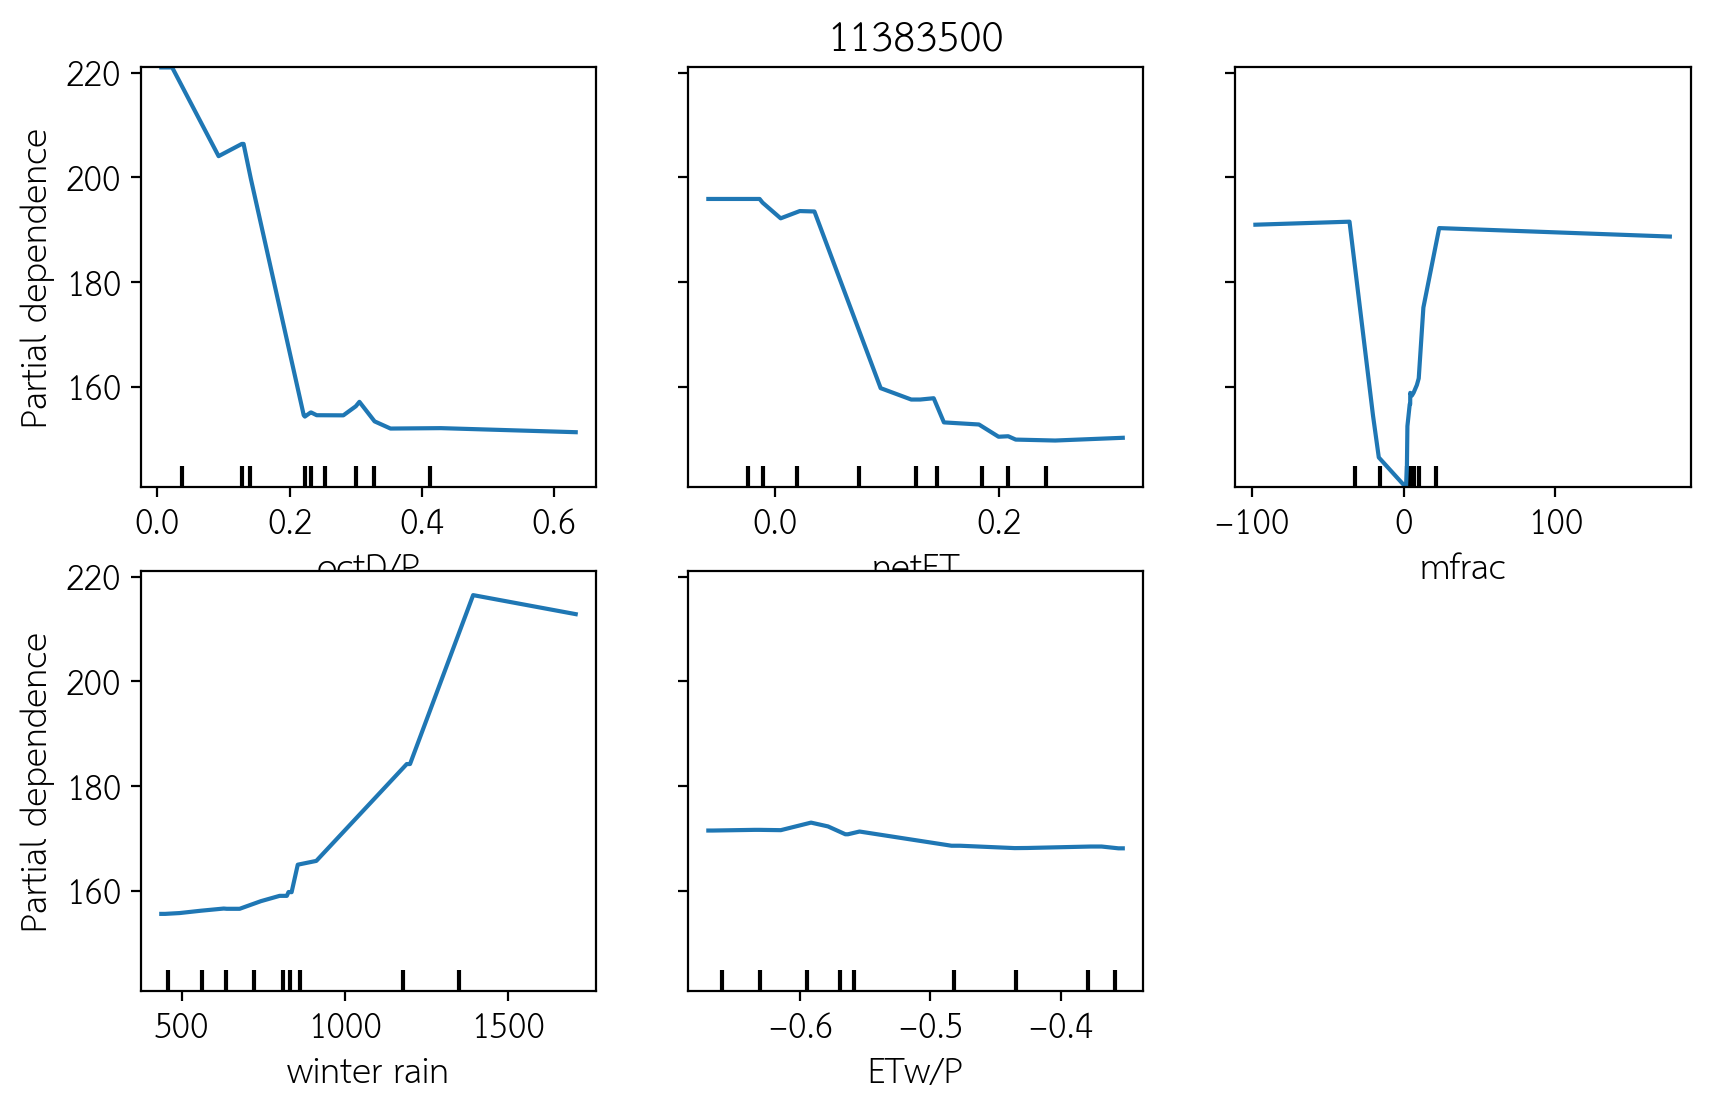


R2 = 0.95


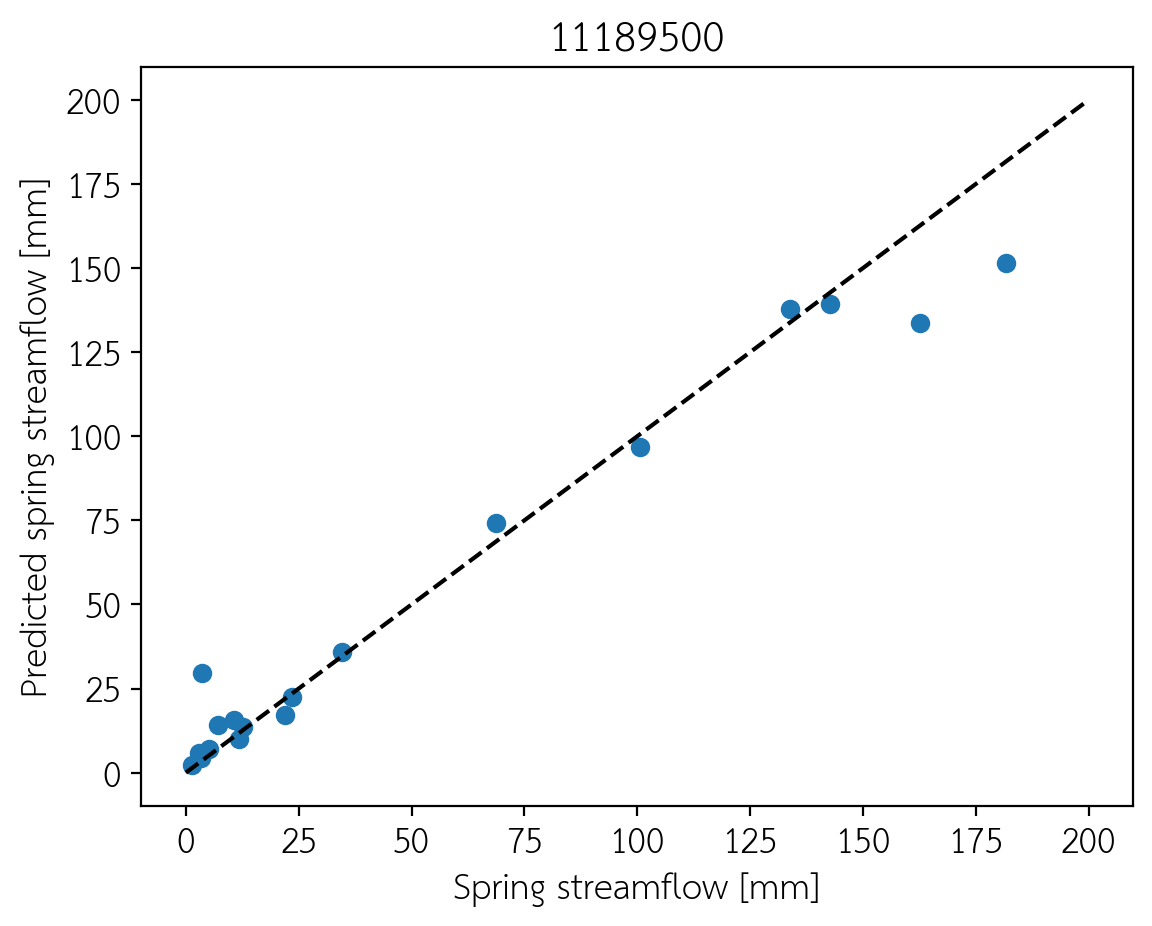

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


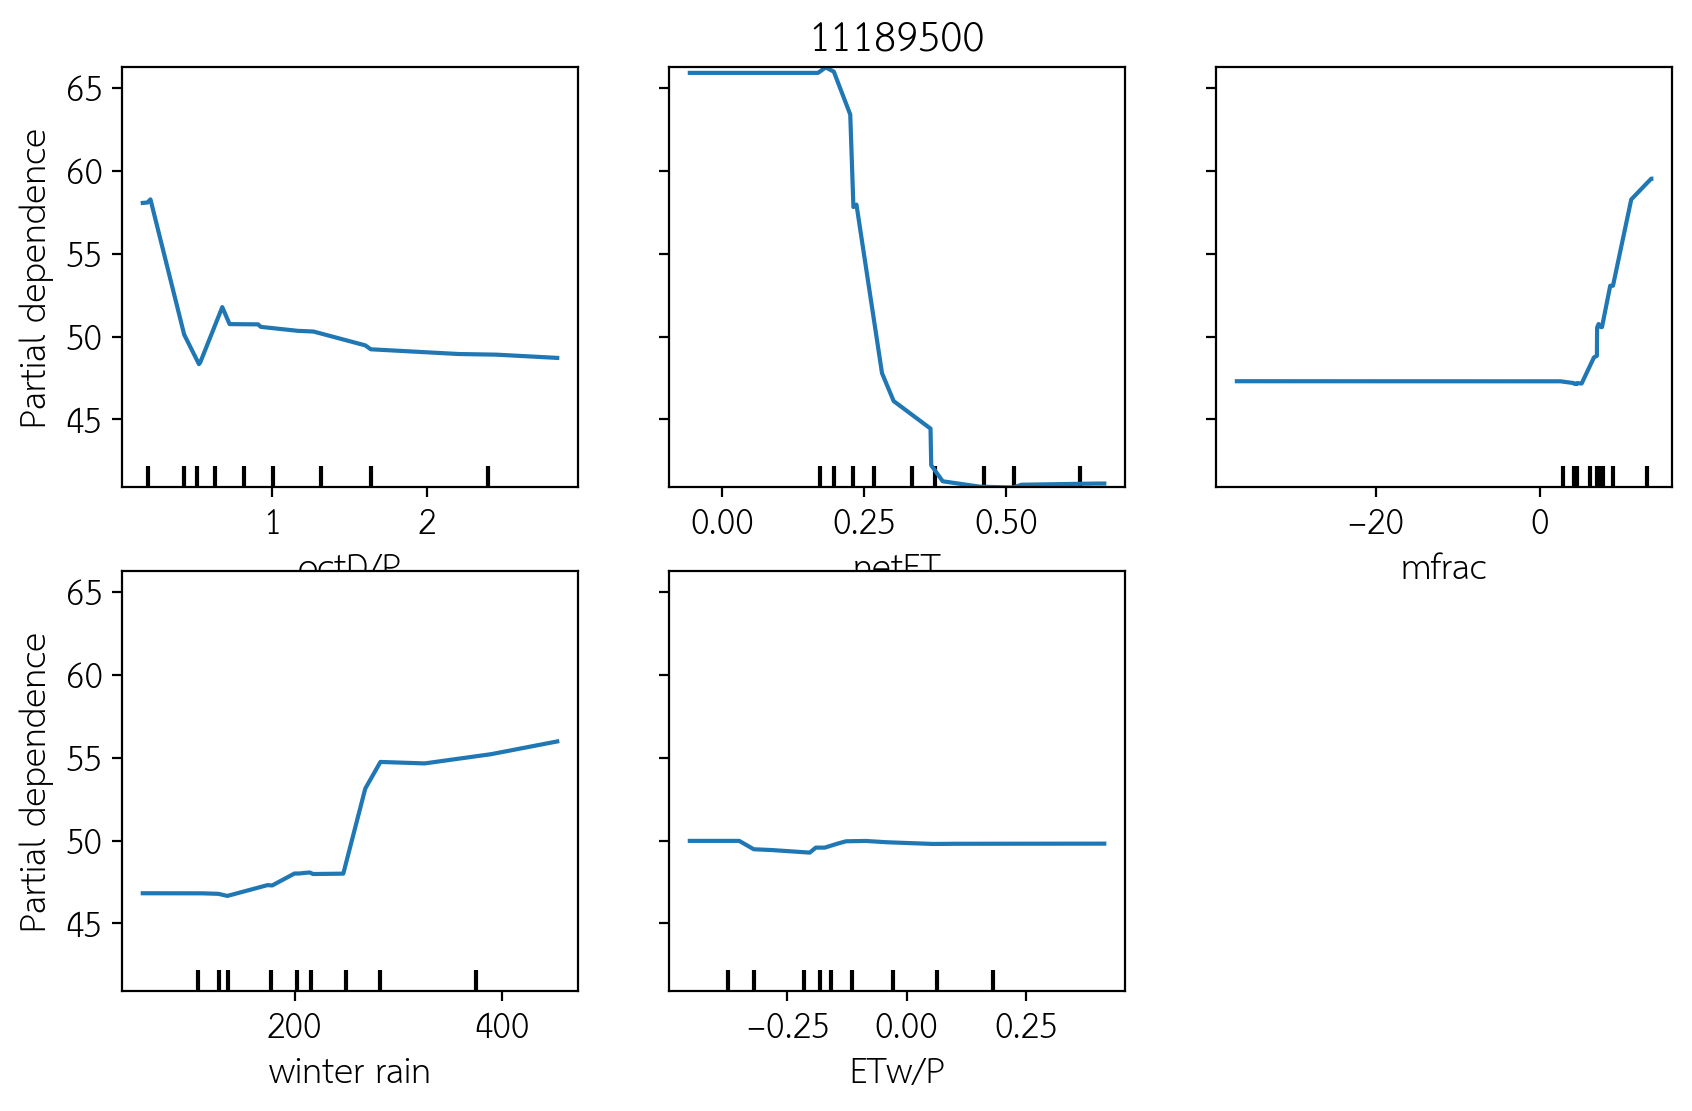


R2 = 0.92


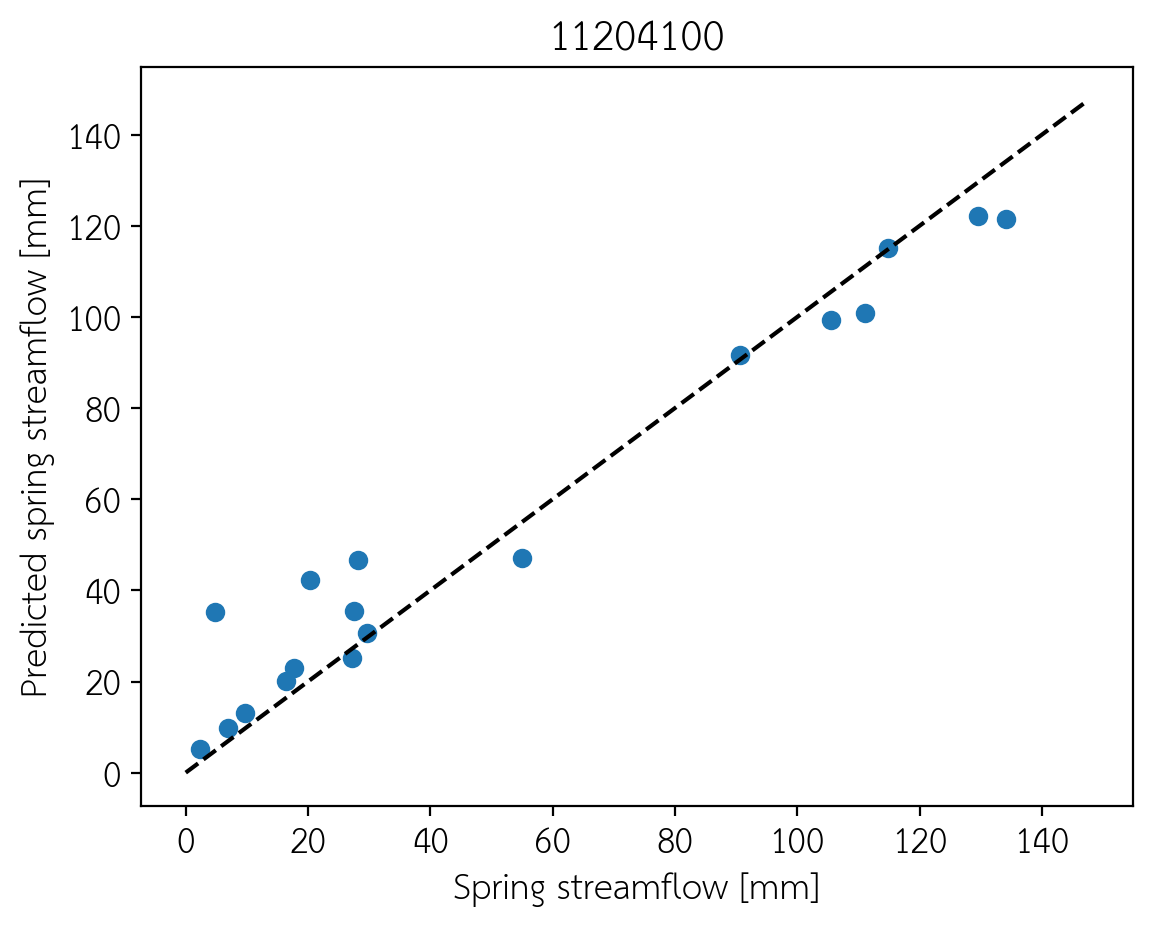

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


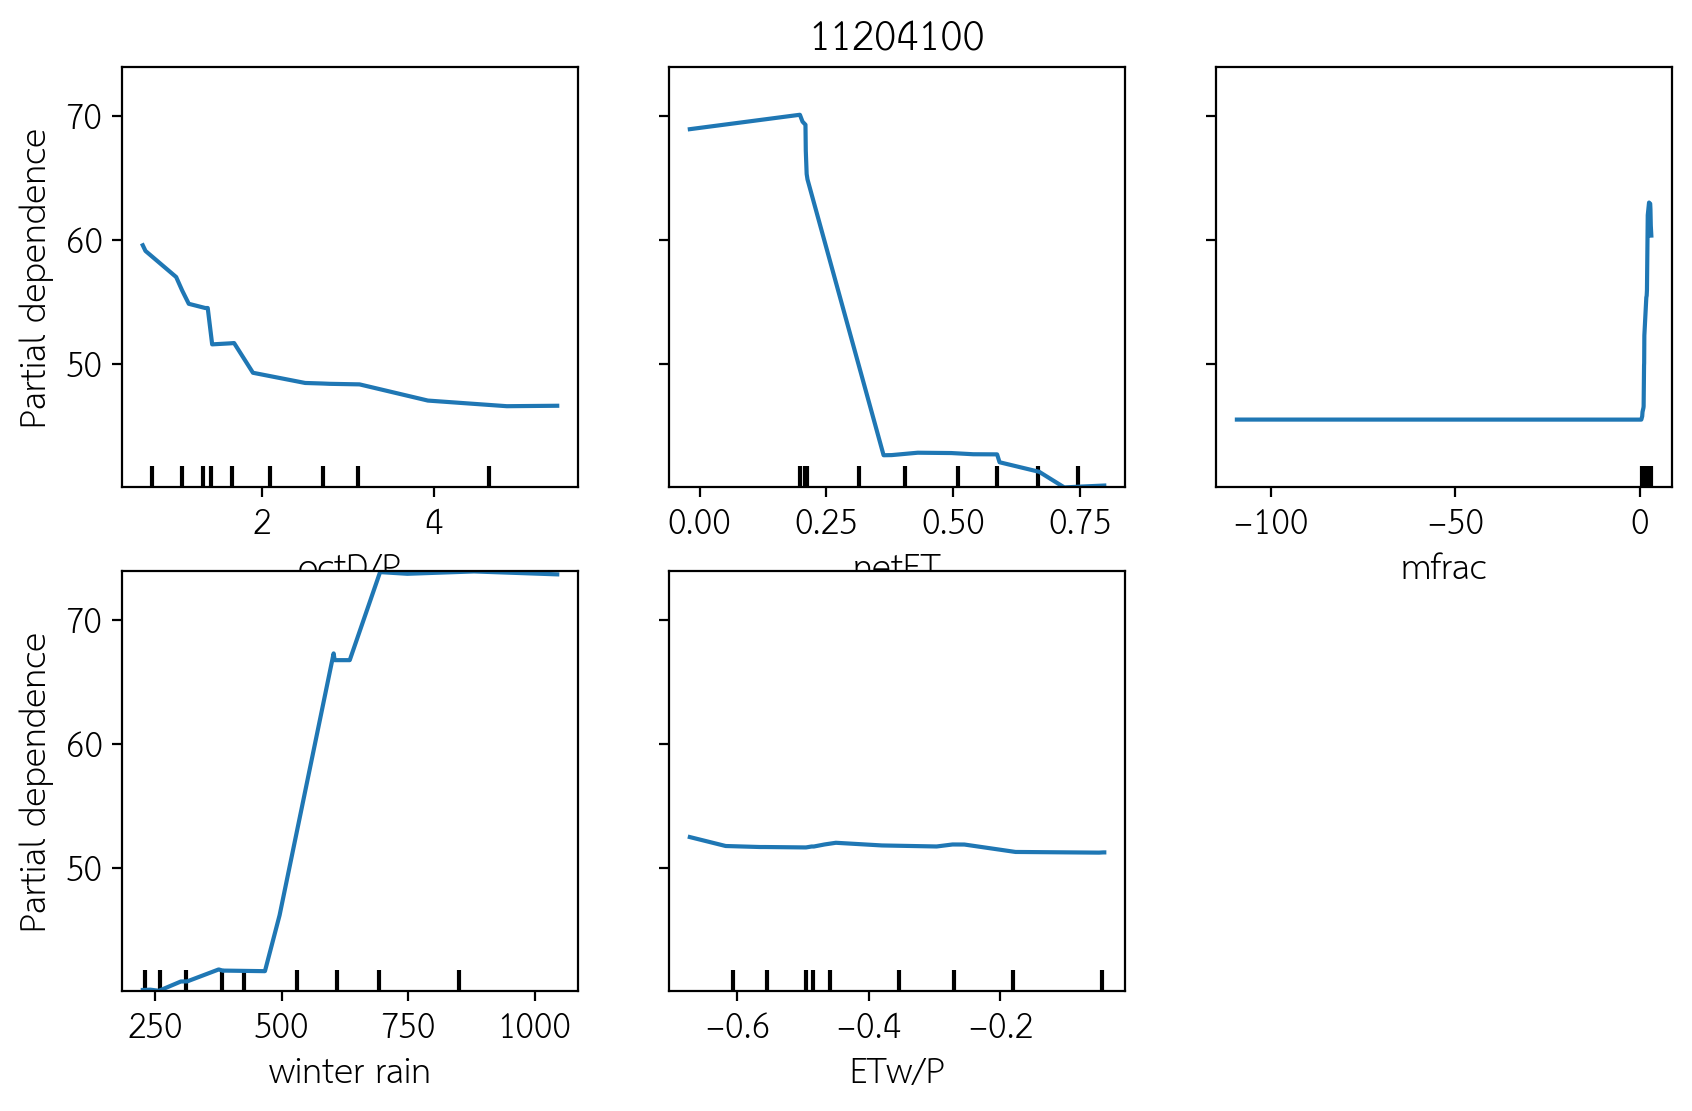


R2 = 0.96


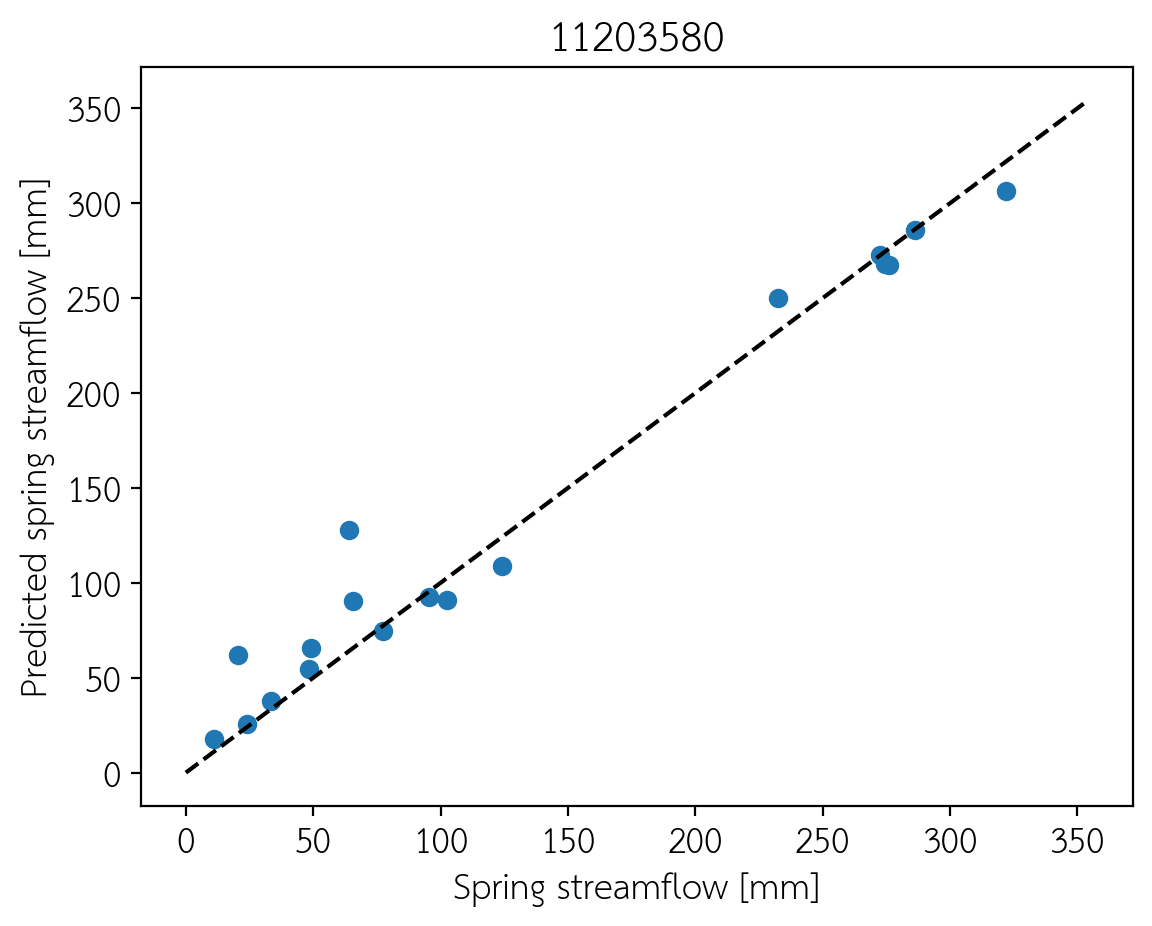

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


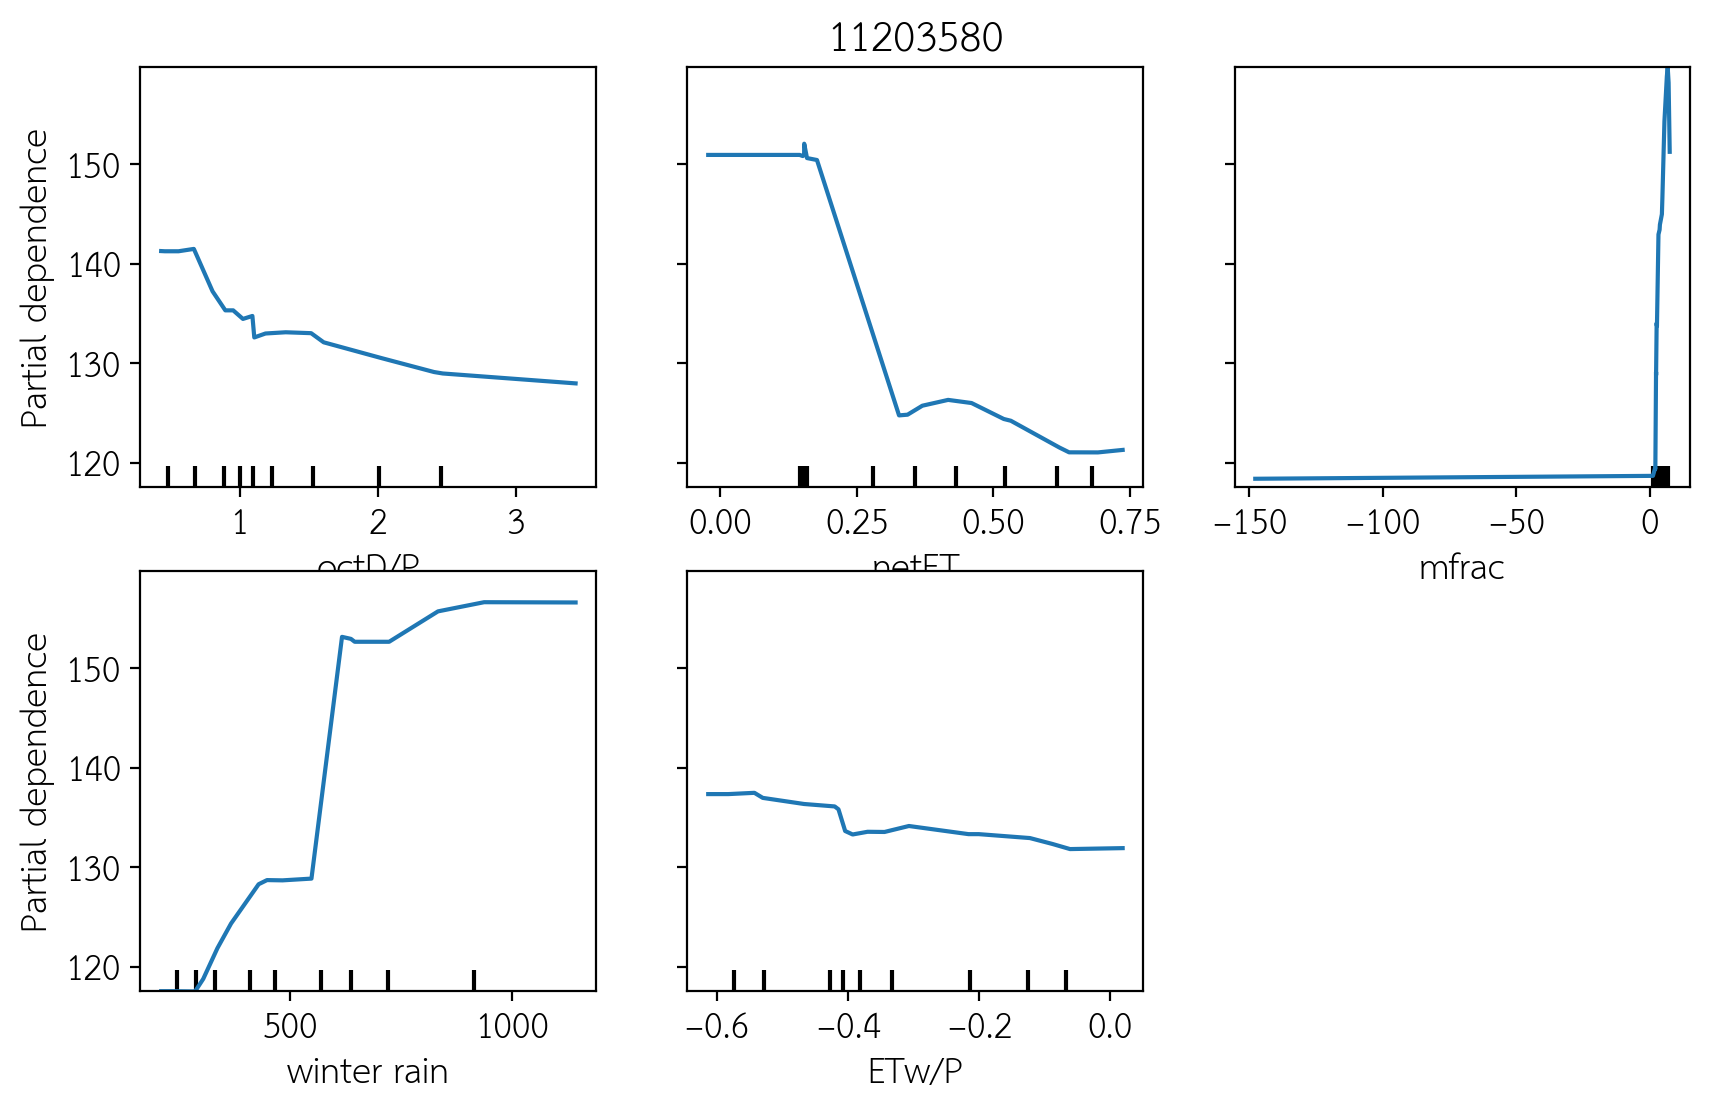


R2 = 0.95


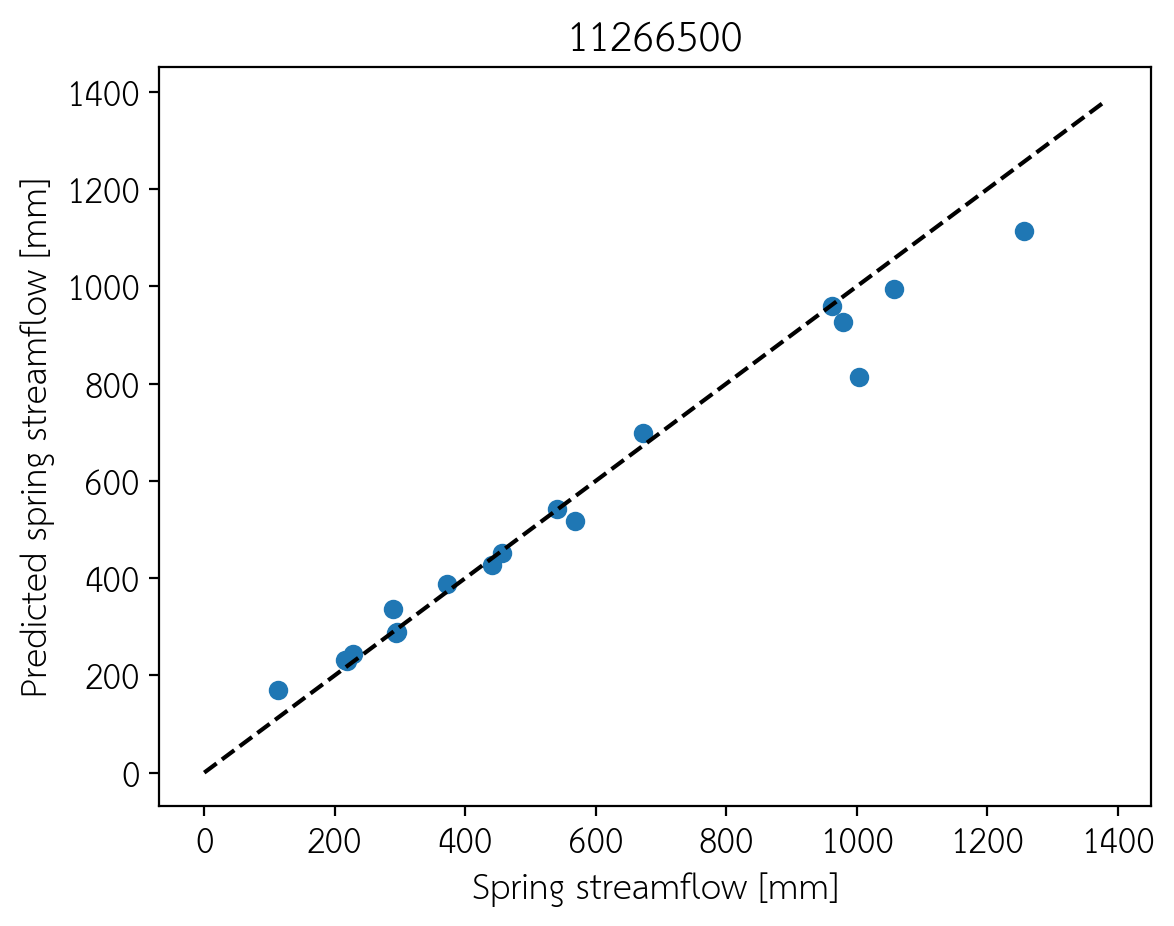

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


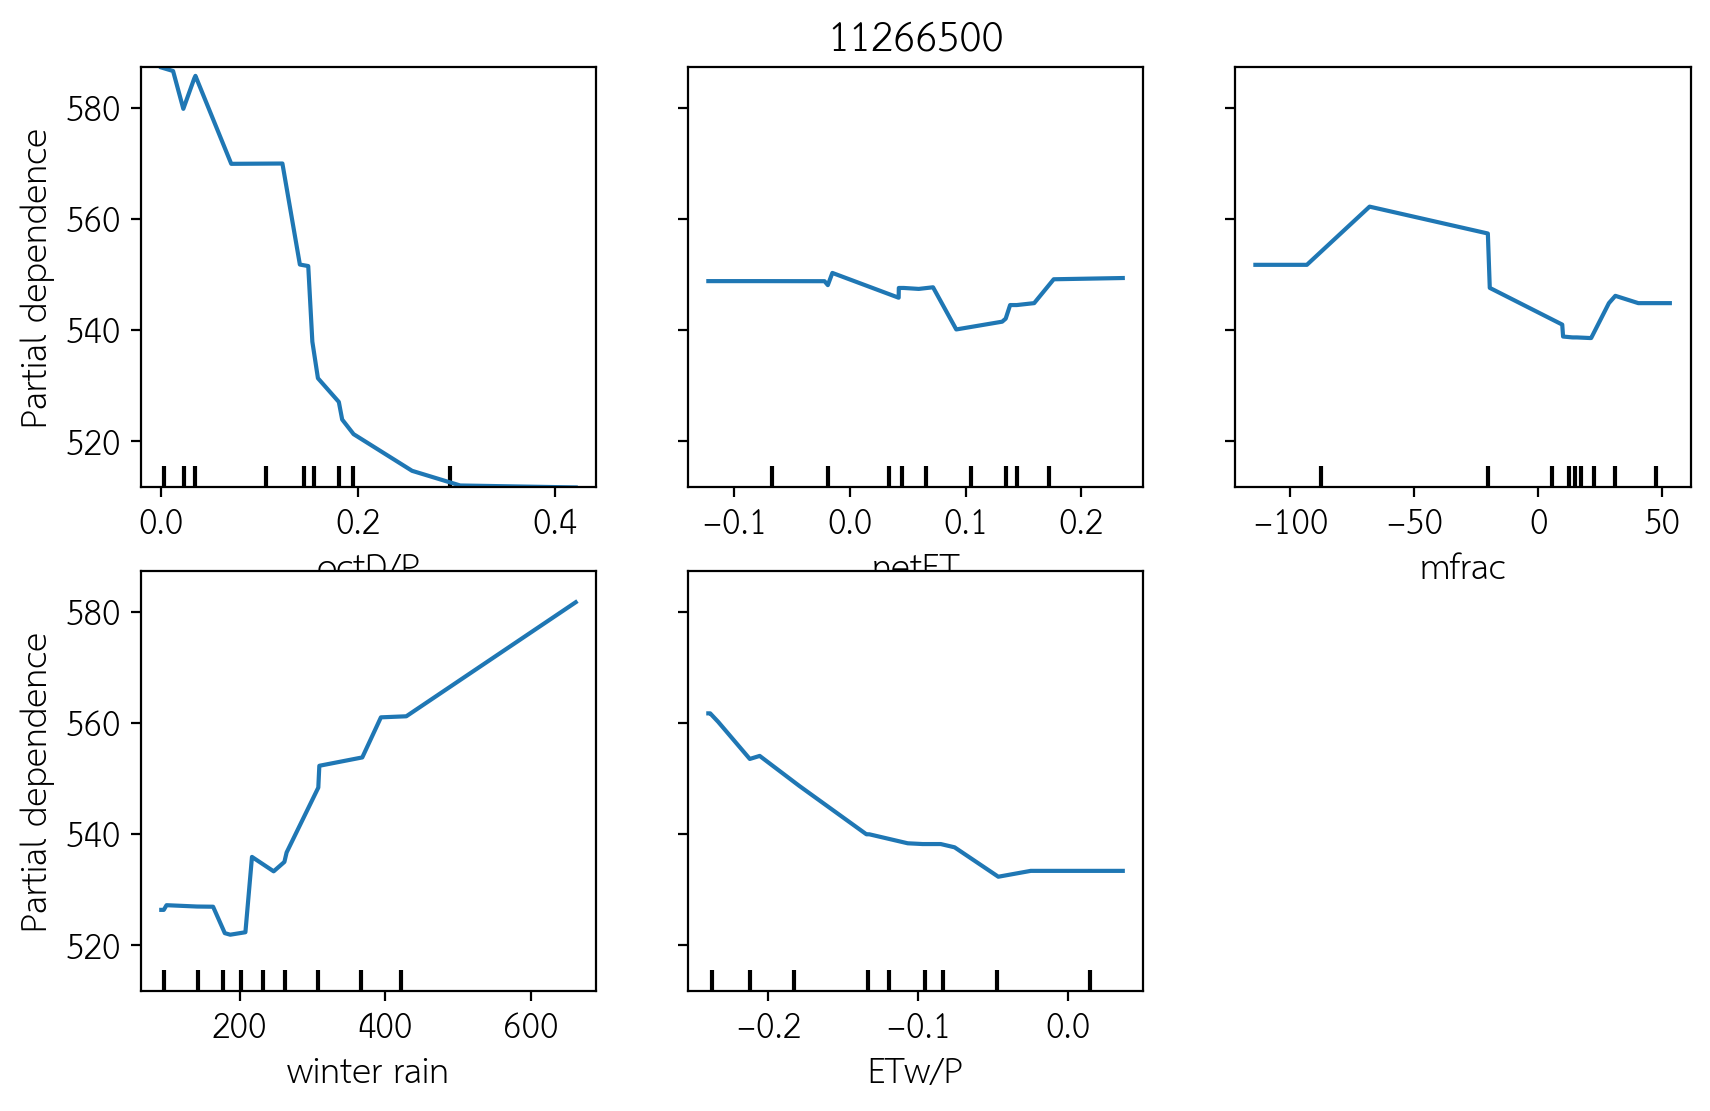


R2 = 0.97


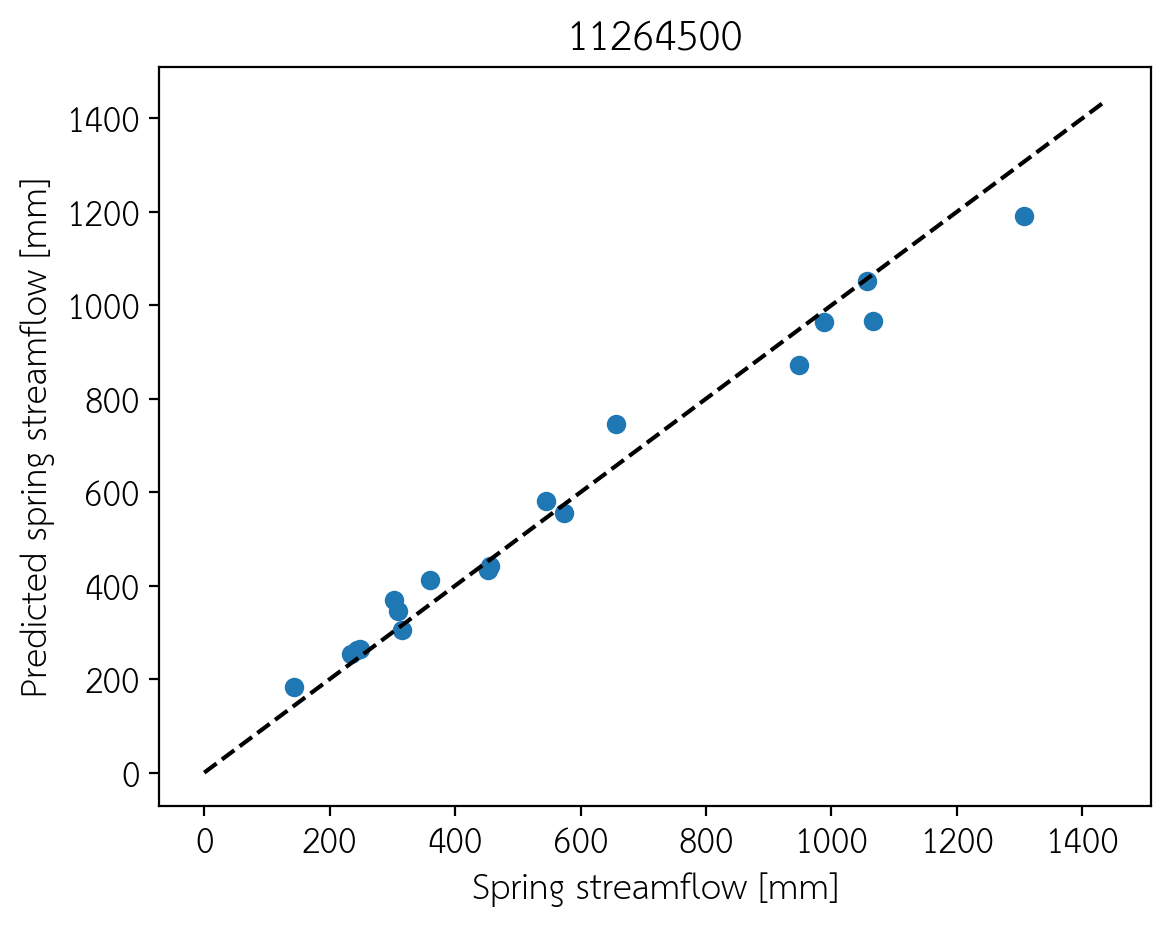

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


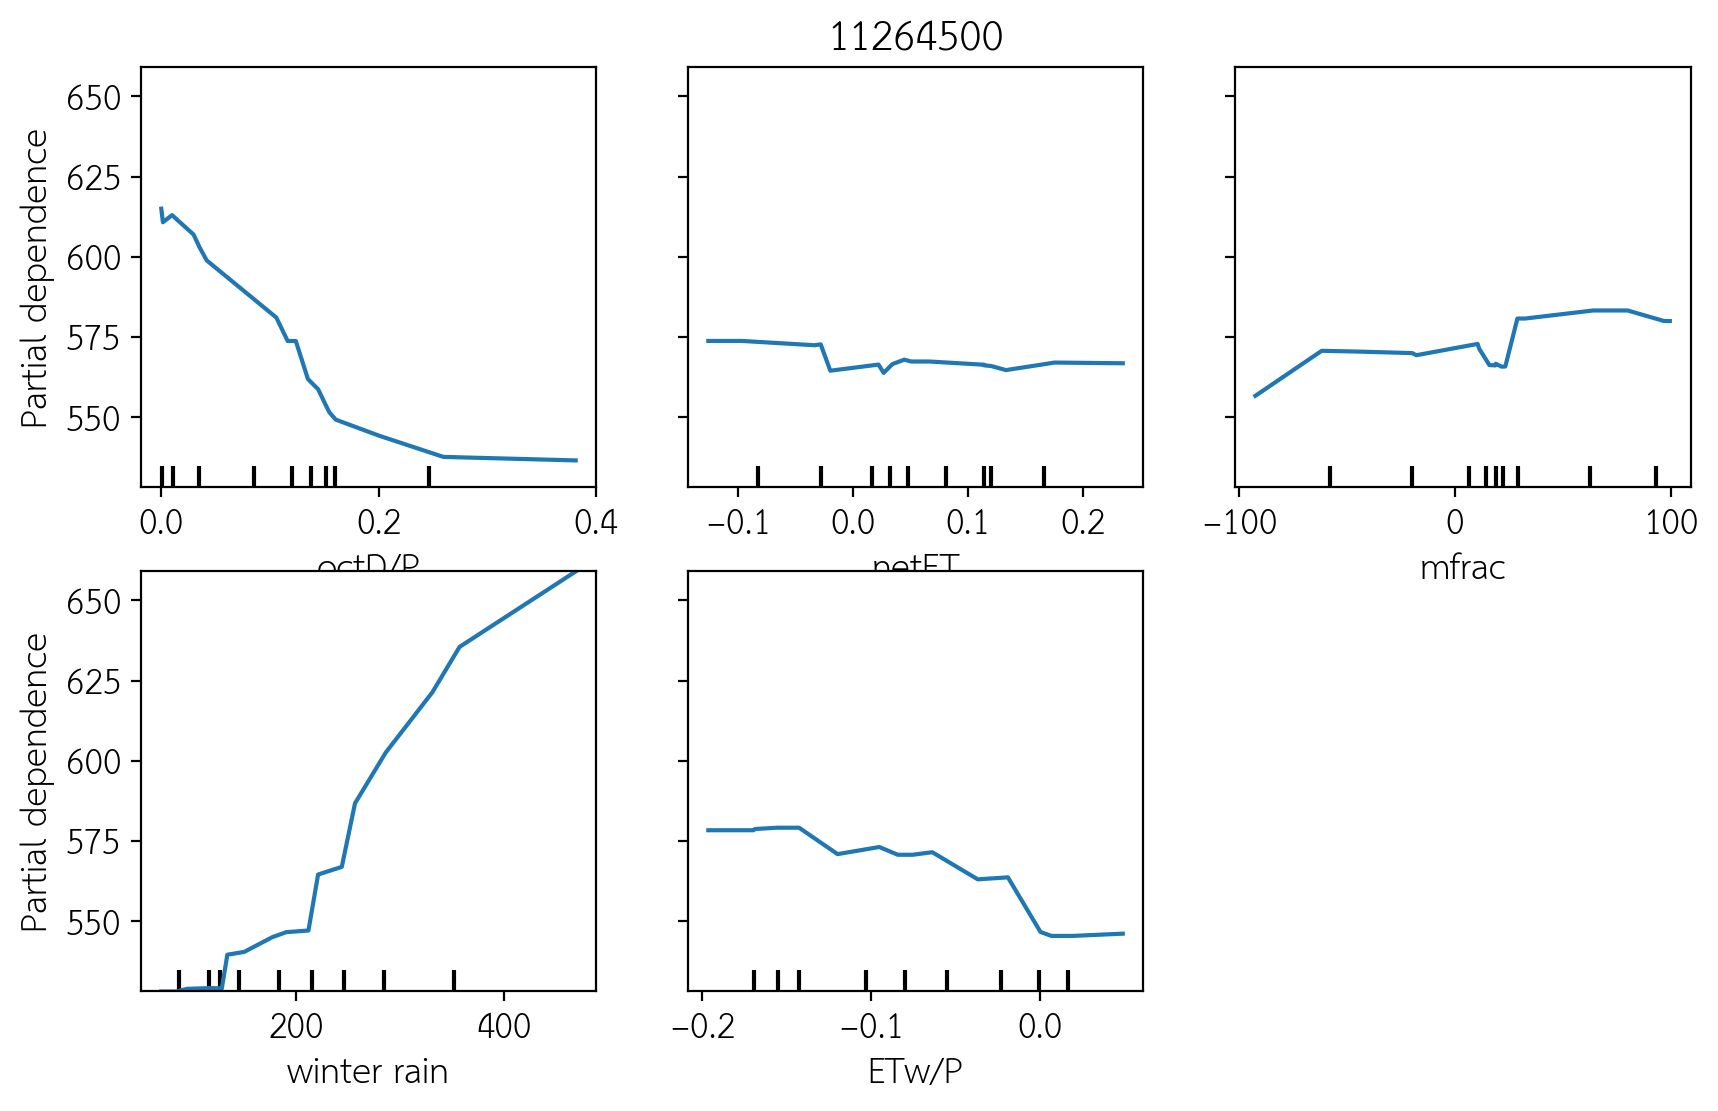


R2 = 0.94


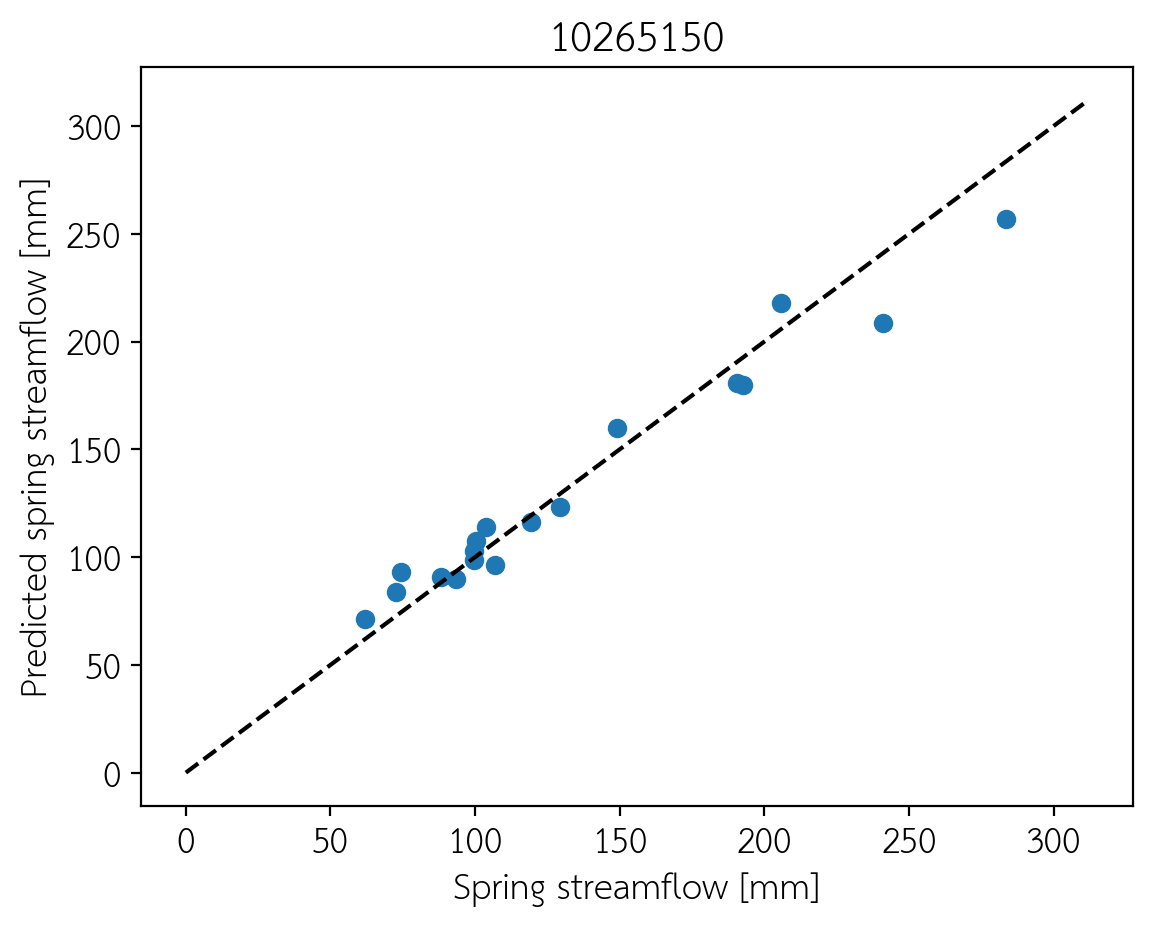

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


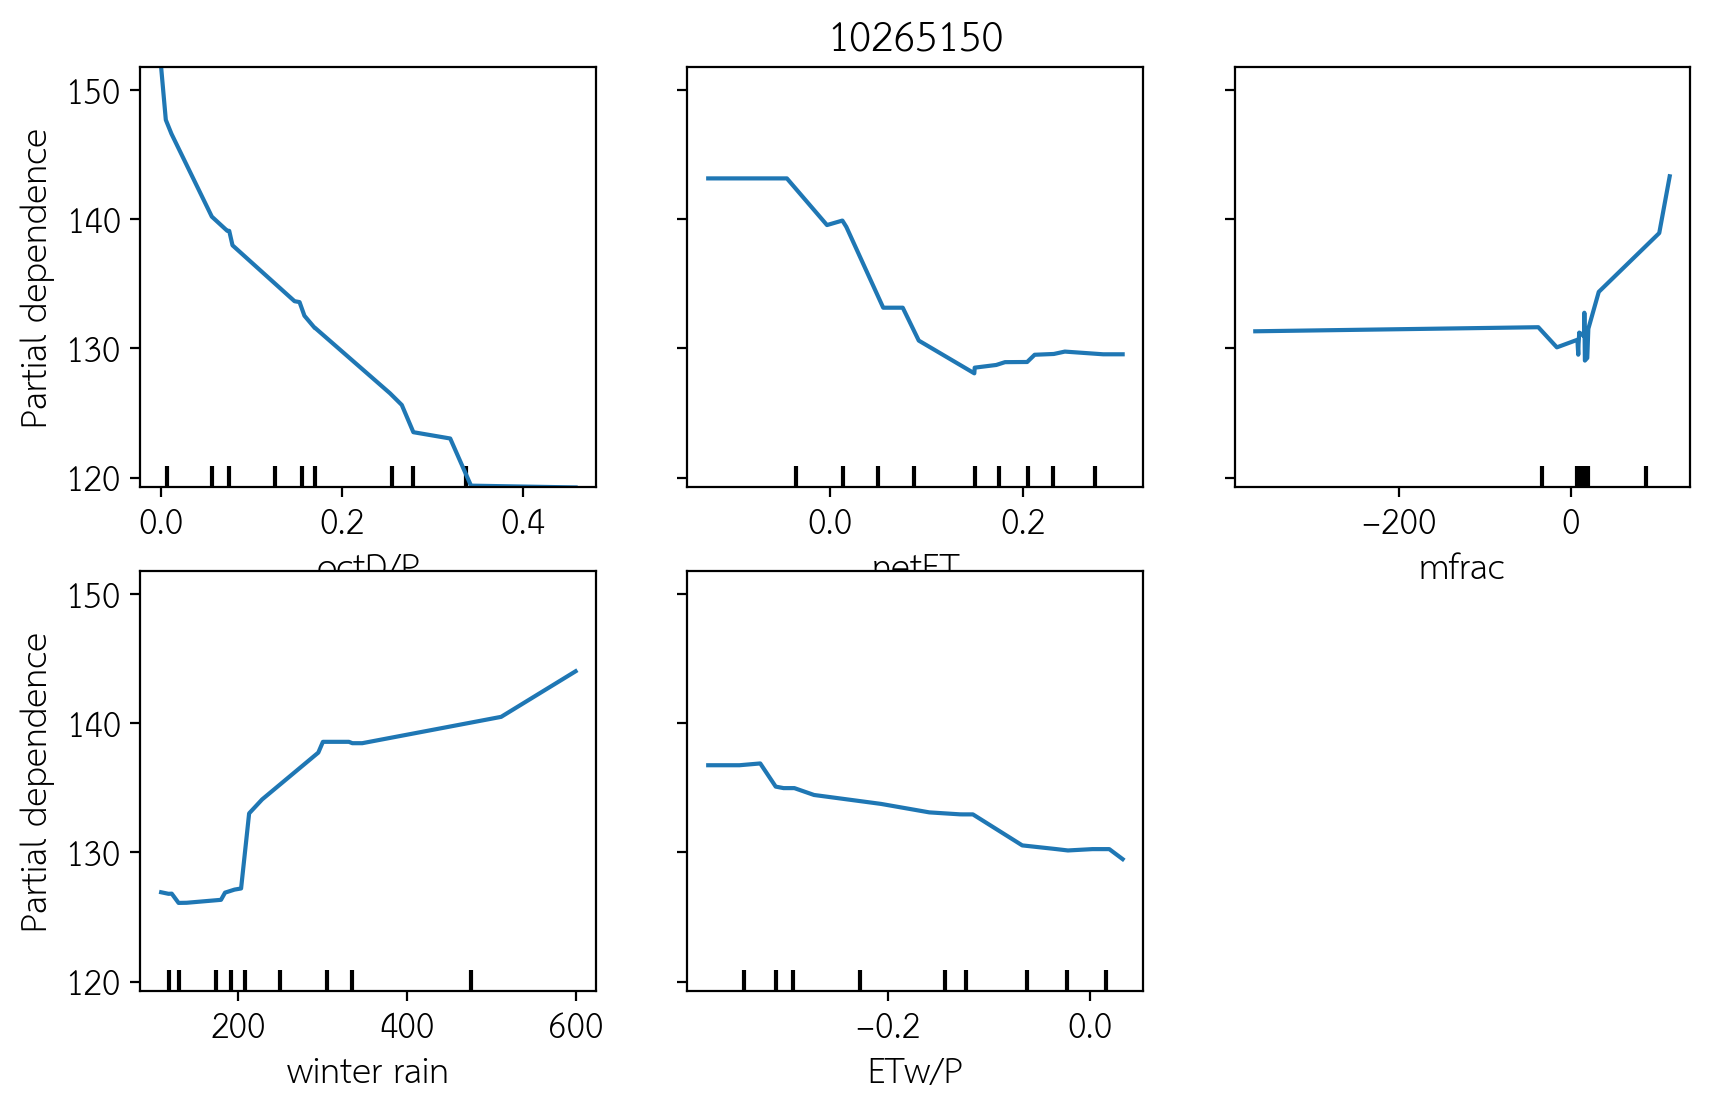


R2 = 0.88


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

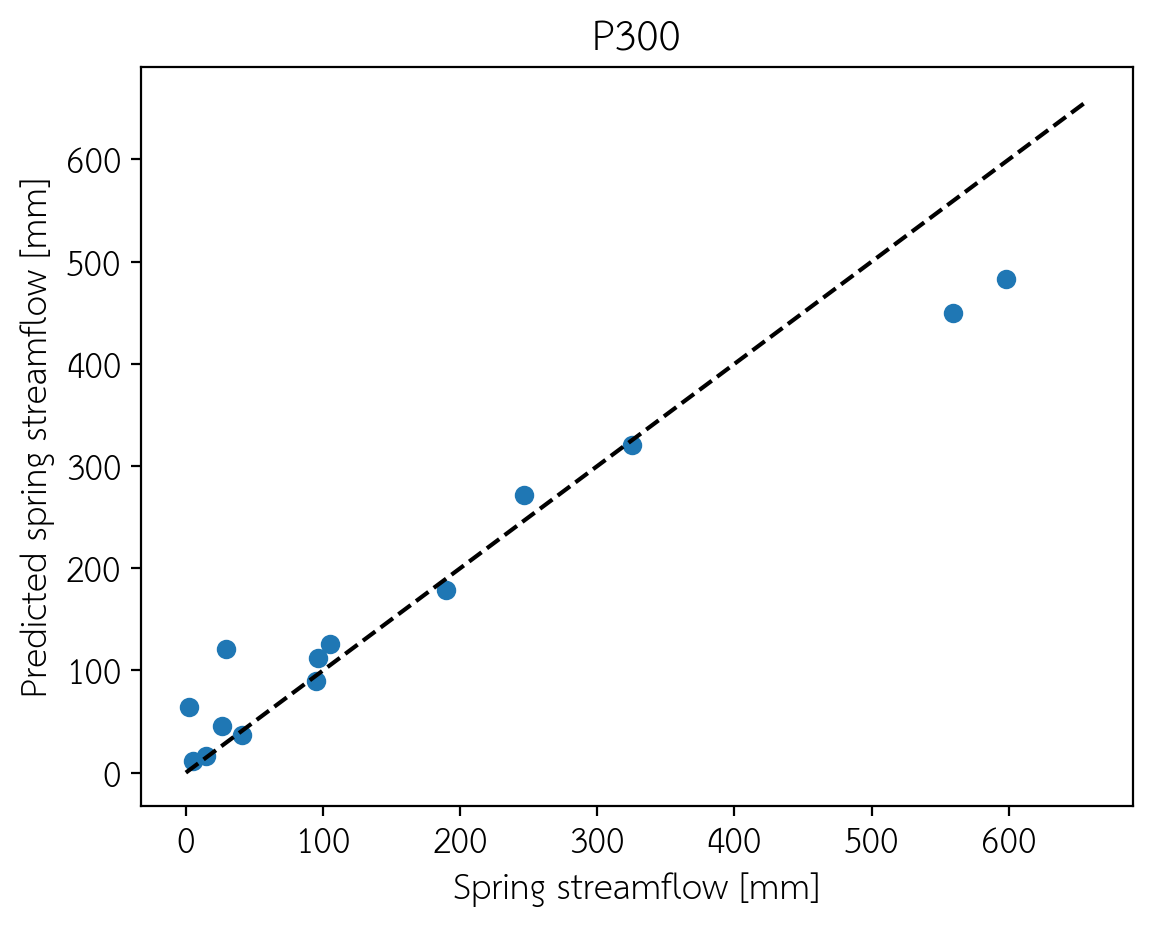

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


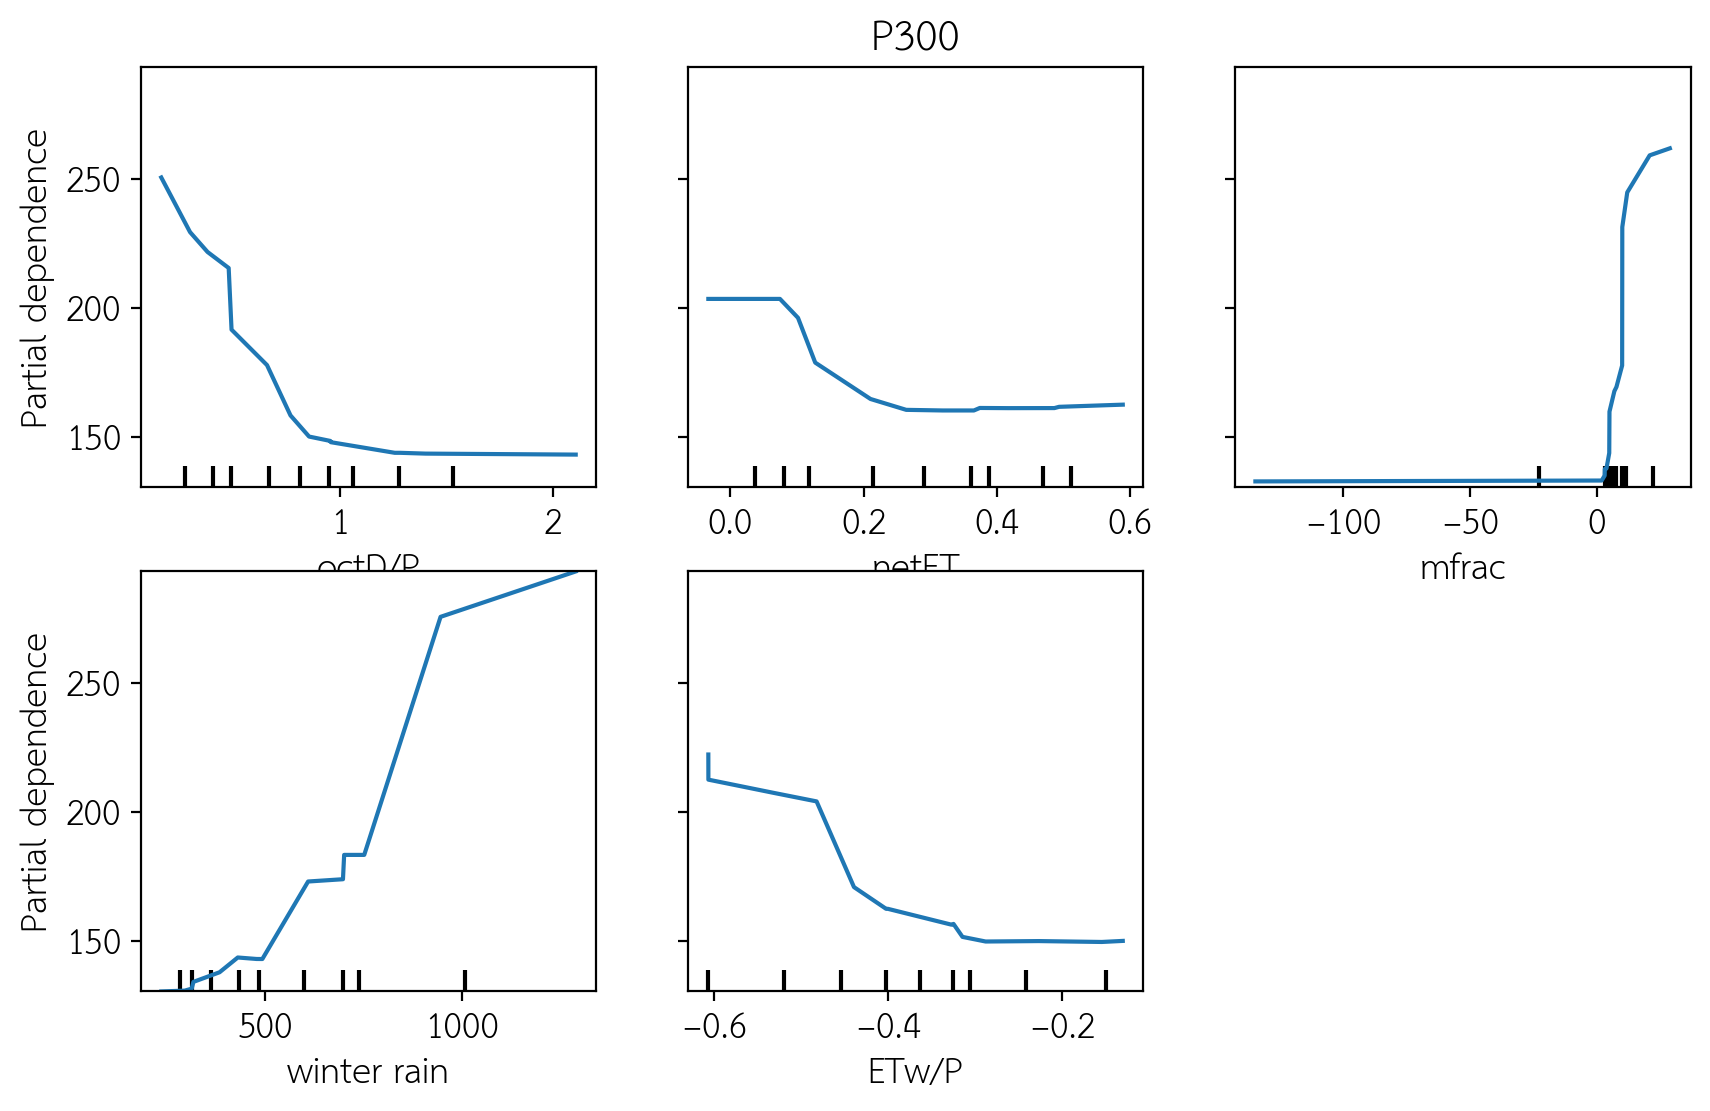


R2 = 0.94


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

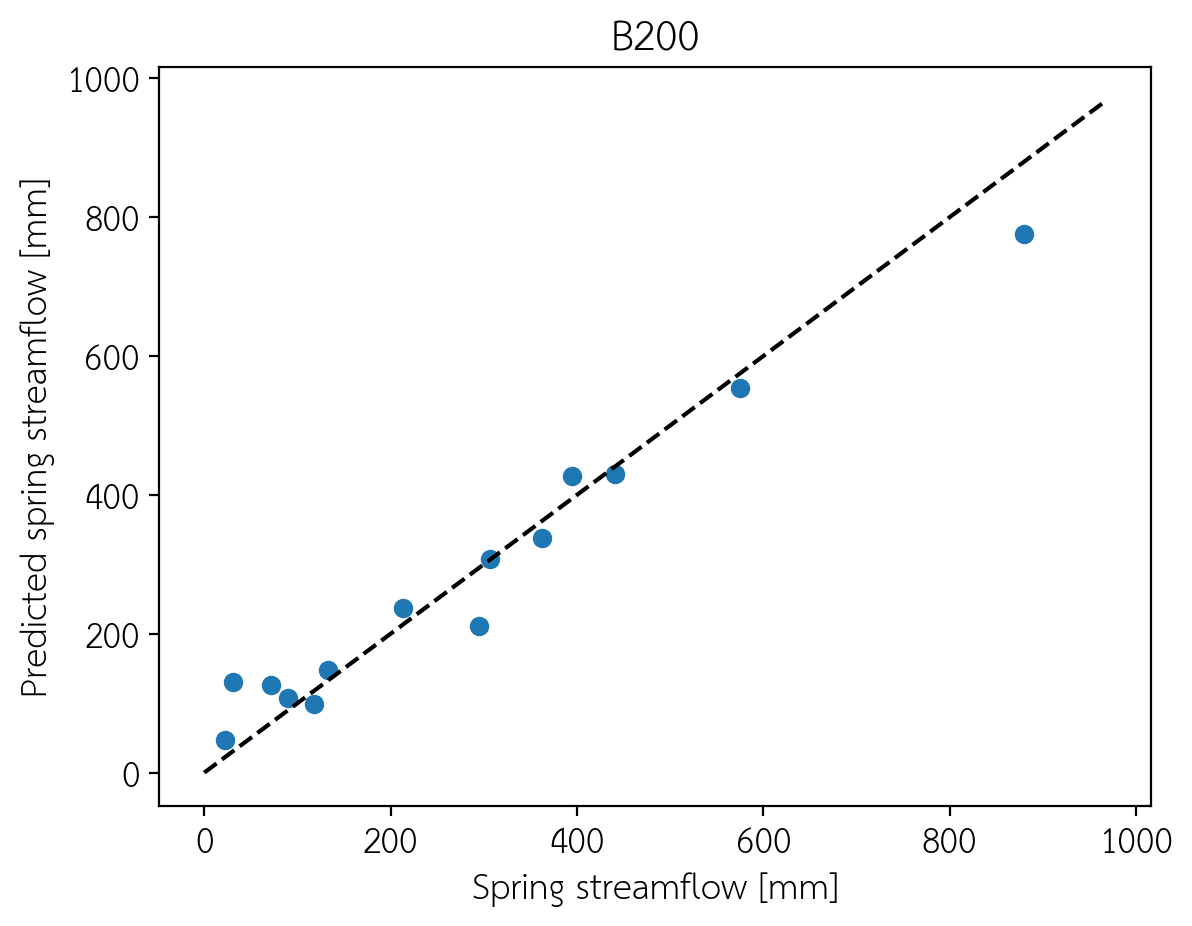

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


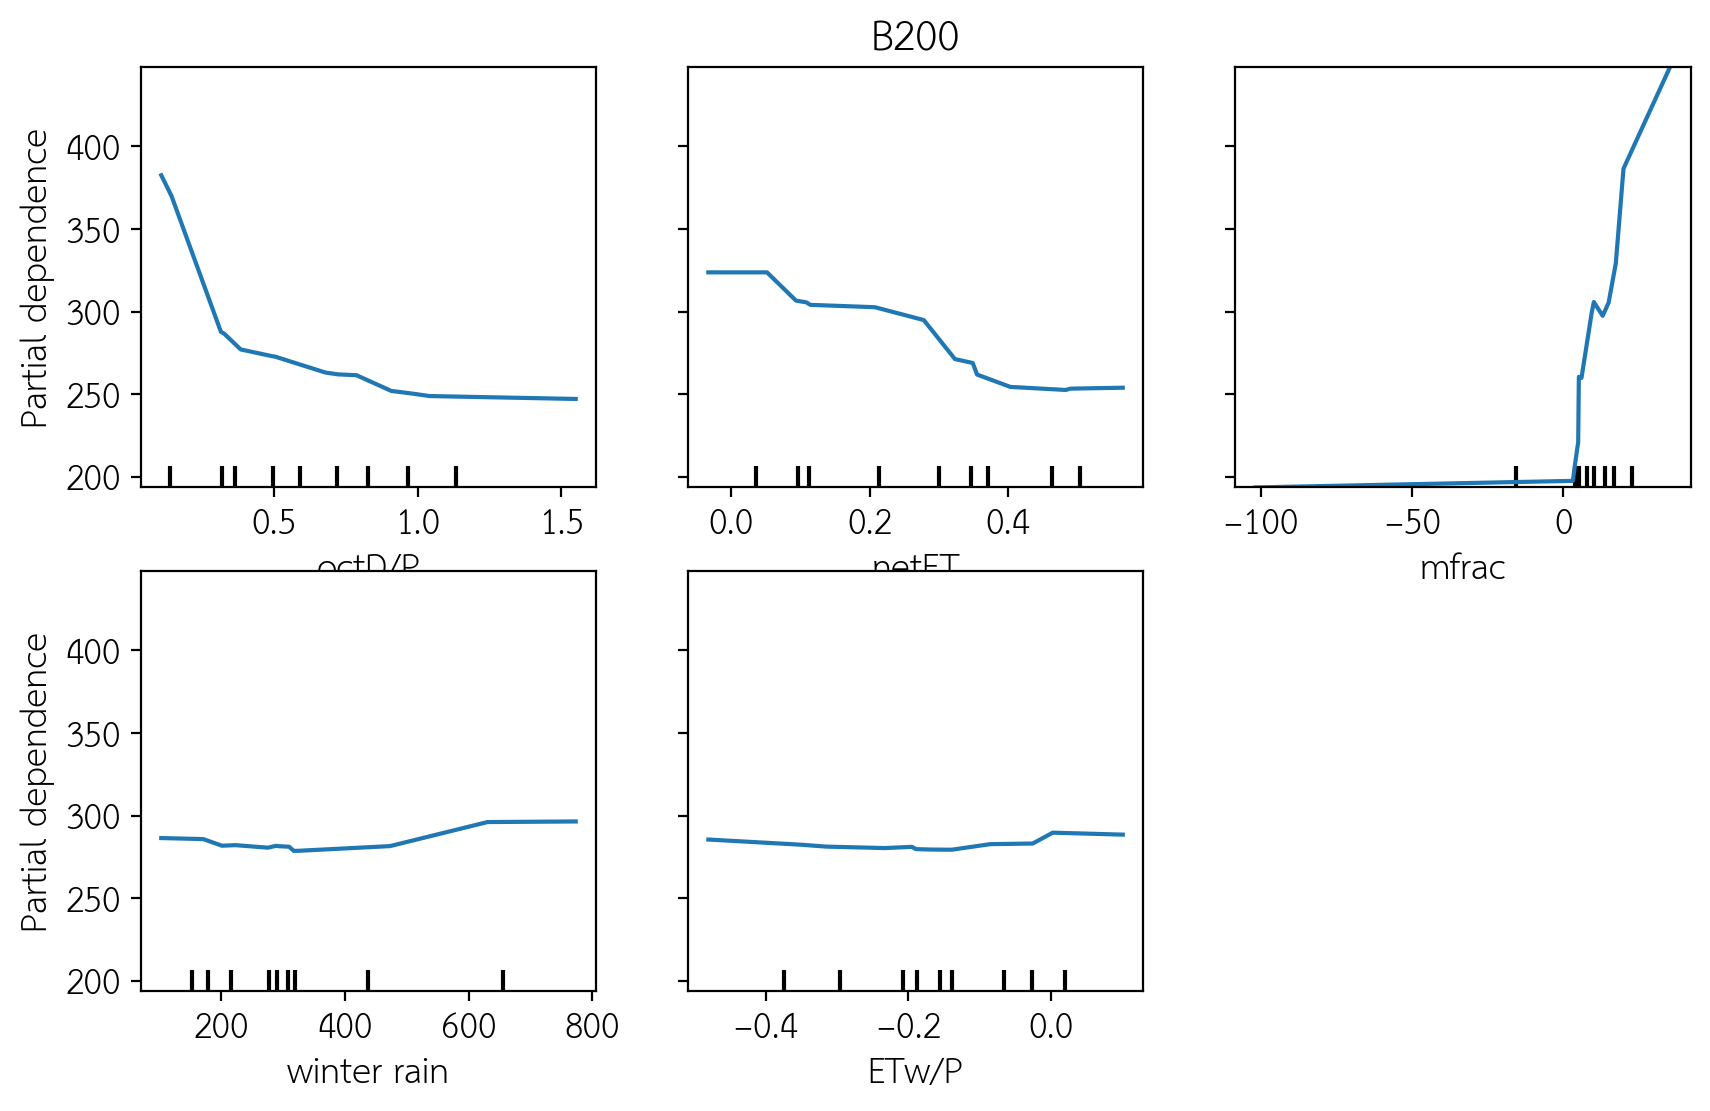

In [ ]:
# build a random forest model for each site separately--lets us see if drivers
# are different but may be a bit unreliable since there really isn't much
# data on a site-by-site basis

r2_vals = []
p2021 = []
for site in list(wy_totals.keys()):
  data = wy_totals[site].dropna()

  #define response variable
  y = data['springQ']#.drop_duplicates()#data['residuals']

  data['octD/P'] = (data.octDeficit)/data.P
  data['aprD'] = (data.aprDeficit)/data.winter_P#/data.P
  data['springET/P'] = data.springET/data.P#aprSWE#data.winter_P#/data.melt_rate/120
  data['springP'] = data.spring_rain/data.P#winter_P
  data['netET'] = (data.springET-data.spring_rain)/data.P
  data['octD/wintP'] = data.octDeficit/data.winter_P
  data['m'] = data.melt_rate#*30-data.springET/4#/(data.springET-data.spring_rain)*4
  data['mfrac'] = data.melt_rate/(data.springET-data.spring_rain)*4*30
  # data['mfrac'] = np.where(np.isfinite(data.mfrac),data.mfrac,10)
  data['ETw/P'] = (data.winterET-data.winter_rain)/data.P
  data['winter rain'] = (data.winter_rain)#+data.spring_rain)/data.P#

  variables_to_test = ['aprSWE','octD/P',
                      #  'octD/wintP',
                       'netET',
                       'mfrac',
                       'winter rain',
                       'ETw/P',]
  X0 = data[variables_to_test]
  # set up model
  model = RandomForestRegressor(n_estimators=100)
  # evaluate the model
  # cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  # n_scores = cross_val_score(model, X0,y, scoring='r2', 
  #                           cv=cv, n_jobs=-1, error_score='raise')
  # print( 'MAE: %.3f (%.3f)' % ((np.nanmean(n_scores)), (np.std(n_scores))))

  # fit model to data
  clf = model.fit(X0,y)
  # get model guess for streamflow for each site/year
  y1 = model.predict(X0)

  # evaluate performance with R2
  r2_vals.append(r2_score(y1,y))
  p2021.append(y1[-1])
  print('R2 = %0.2f' %(r2_score(y1,y)))

  # plot data performance
  plt.scatter(y,y1)
  mv = max(y)*1.1
  plt.plot([0,mv],[0,mv],c='k',ls='--')
  plt.xlabel('Spring streamflow [mm]')
  plt.ylabel('Predicted spring streamflow [mm]')
  plt.title(site)
  plt.show()

  # make partial dependence plots
  fig,ax = plt.subplots(1,figsize = (10,6))
  plot_partial_dependence(clf, X0, variables_to_test[1:],ax = ax) 
  ax.set_title(site)
  plt.show()
  print('')

In [ ]:
Xcheck = {c:[] for c in X0.columns}
# for c in X0.columns:
#   Xcheck[c] = [np.nanmedian(X0[c])]*100
Xcheck['octD/P'] = np.linspace(0,3,100)
Xcheck['aprSWE'] = [100]*100
Xcheck['ETw/P'] = [1]*100
Xcheck['winter rain'] = [0]*100
Xcheck['mfrac'] = [-1]*100
Xcheck['netET'] = [1]*100
Xcheck = pd.DataFrame.from_dict(Xcheck)
# ycheck = model.predict(Xcheck)
# plt.plot(Xcheck['octD/P'],ycheck)

In [ ]:
# build one random forest model that functions across all sites

r2_vals = []
p2021 = []
data = ''
for site in list(wy_totals.keys()):
  if len(data)==0:
    data = wy_totals[site]
  else:
    data = pd.concat([data,wy_totals[site]])

#define response variable
data = data.dropna()
y = data['springQ']#.drop_duplicates()#data['residuals']

data['octD/P'] = (data.octDeficit)/data.P
data['aprD'] = (data.aprDeficit)/data.winter_P#/data.P
data['springET/P'] = data.springET/data.P#aprSWE#data.winter_P#/data.melt_rate/120
data['springP'] = data.spring_rain/data.P#winter_P
data['netET'] = (data.springET-data.spring_rain)/data.P
data['octD/wintP'] = data.octDeficit/data.winter_P
data['m'] = data.melt_rate#*30-data.springET/4#/(data.springET-data.spring_rain)*4
data['mfrac'] = data.melt_rate/(data.springET-data.spring_rain)*4*30
# data['mfrac'] = np.where(np.isfinite(data.mfrac),data.mfrac,10)
data['ETw/P'] = (data.winterET-data.winter_rain)/data.P
data['winter rain'] = (data.winter_rain)#+data.spring_rain)/data.P#

variables_to_test = ['aprSWE','octD/P',
                    #  'octD/wintP',
                      'netET',
                      'mfrac',
                      'winter rain',
                      'ETw/P',]
X0 = data[variables_to_test]

residuals_loo = []
for i in range(len(X0)):
  X0_test = X0.reset_index()[X0.reset_index().index!=i].drop(columns='wy')
  y_test = list(y.copy().values)
  y_test.pop(i)
  model = RandomForestRegressor(n_estimators=100)
  model.fit(X0_test,y_test)
  ypred = model.predict(X0.iloc[[i]])
  res_test = abs(y.values[i]-ypred)
  residuals_loo.append(res_test)
res_loo = np.nanmean(residuals_loo)
print(res_loo)






87.34300897965106


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


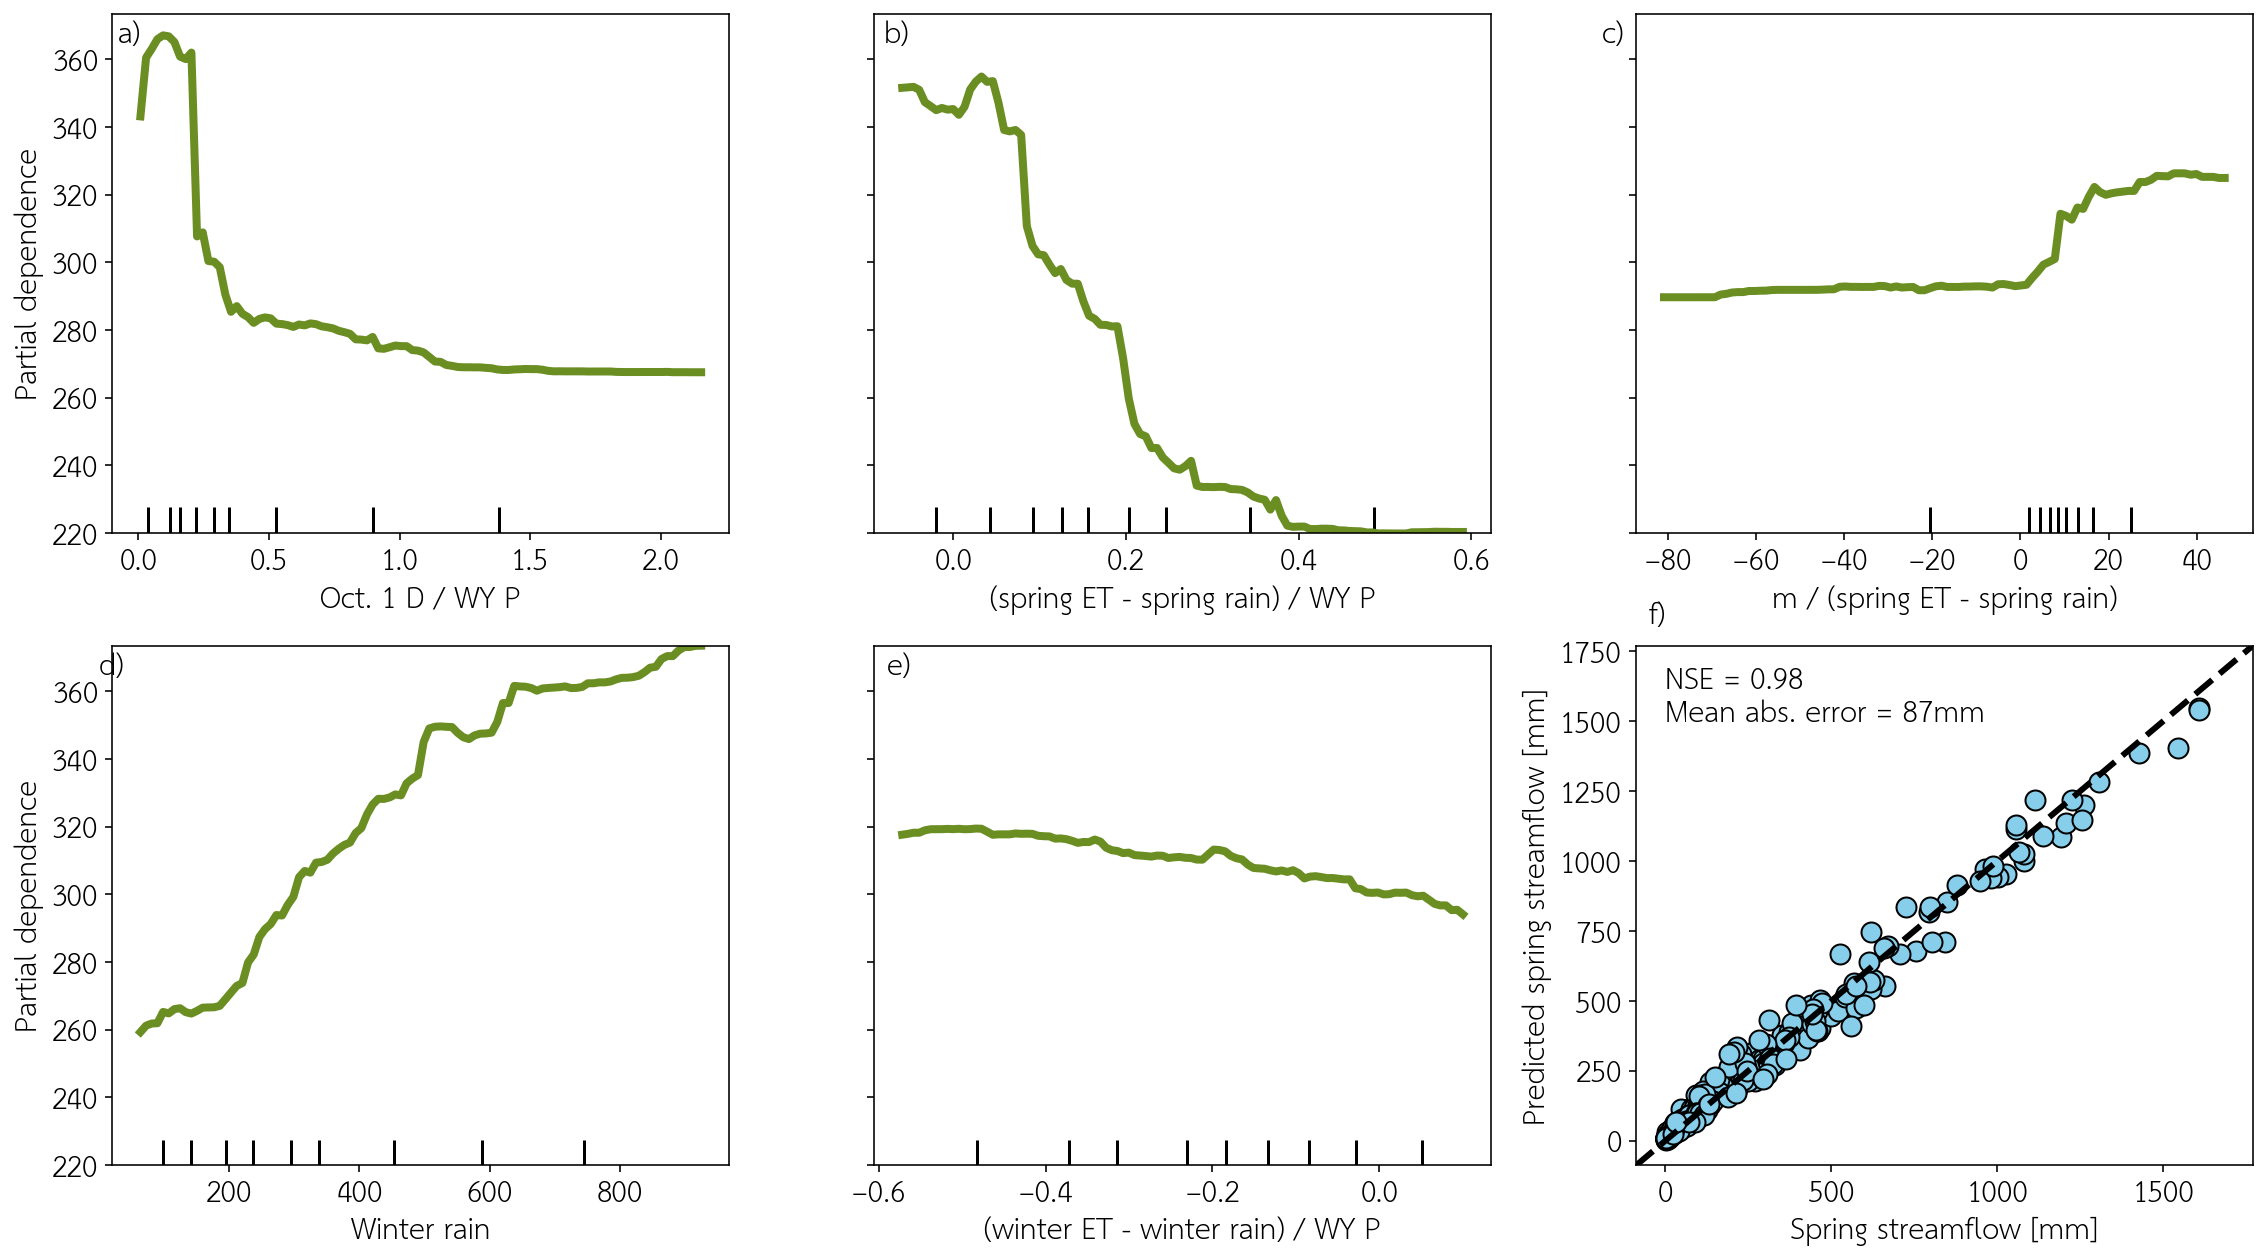

In [ ]:
# set up model
model = RandomForestRegressor(n_estimators=100)

# fit model
model.fit(X0,y)

# get feature importance
importances = model.feature_importances_
# evaluate the model
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X0,y, scoring='r2', 
#                           cv=cv, n_jobs=-1, error_score='raise')
# print( 'MAE: %.3f (%.3f)' % ((np.nanmean(n_scores)), (np.std(n_scores))))

# fit model and calculate predicted outputs
clf = model.fit(X0,y)
y1 = model.predict(X0)

ycheck = model.predict(Xcheck)

# plot partial dependence and model performance
%matplotlib inline
plt.rcParams.update({'font.size': 14})
fig,axs = plt.subplots(2,3,figsize = (16,9))
plot_partial_dependence(clf, X0, variables_to_test[1:],ax = [axs[0,0],axs[0,1],axs[0,2],axs[1,0],axs[1,1]],
                        line_kw={"linewidth": 4, "color": "olivedrab"}) 
# ax.set_title('model for all sites')

ax = axs[1,2]
ax.scatter(y,y1,c='skyblue',s=100,edgecolor = 'k',clip_on=False)
mv = max(y)*1.1
ax.plot([-0.05*mv,mv],[-0.05*mv,mv],c='k',ls='--',lw=3)
ax.set_xlabel('Spring streamflow [mm]')
ax.set_ylabel('Predicted spring streamflow [mm]')
ax.set_xlim(-0.05*mv,mv)
ax.set_ylim(-0.05*mv,mv)
# plt.title('all sites')
# plt.show()
from sklearn.metrics import r2_score
r2_vals.append(r2_score(y1,y))
p2021.append(y1[-1])
ax.text(0,1500,'NSE = %0.2f\nMean abs. error = %2.0fmm' %(r2_score(y1,y),res_loo))

for ax in [axs[0,1],axs[0,2],axs[1,1]]:
  ax.set_ylabel('')
  ax.set_yticklabels([])
fig.tight_layout()

labels = ['a)','b)','c)','d)','e)','f)']
axes = [axs[0,0],axs[0,1],axs[0,2],axs[1,0],axs[1,1],axs[1,2]]
minval = [-0.08,-0.08,-95,0.2,-0.59,-50]
xlabels = ['Oct. 1 D / WY P','(spring ET - spring rain) / WY P',
           'm / (spring ET - spring rain)',
           'Winter rain',
           '(winter ET - winter rain) / WY P']
for i in range(len(labels)):
  ax = axes[i]
  if i<5:
    # ax.set_ylim(240,360)
    ax.text(minval[i],365,labels[i])
    ax.set_xlabel(xlabels[i])
  else:
    ax.text(minval[i],1850,labels[i])

plt.savefig('partial_dependence_all_sites.png',format='png',dpi=300)

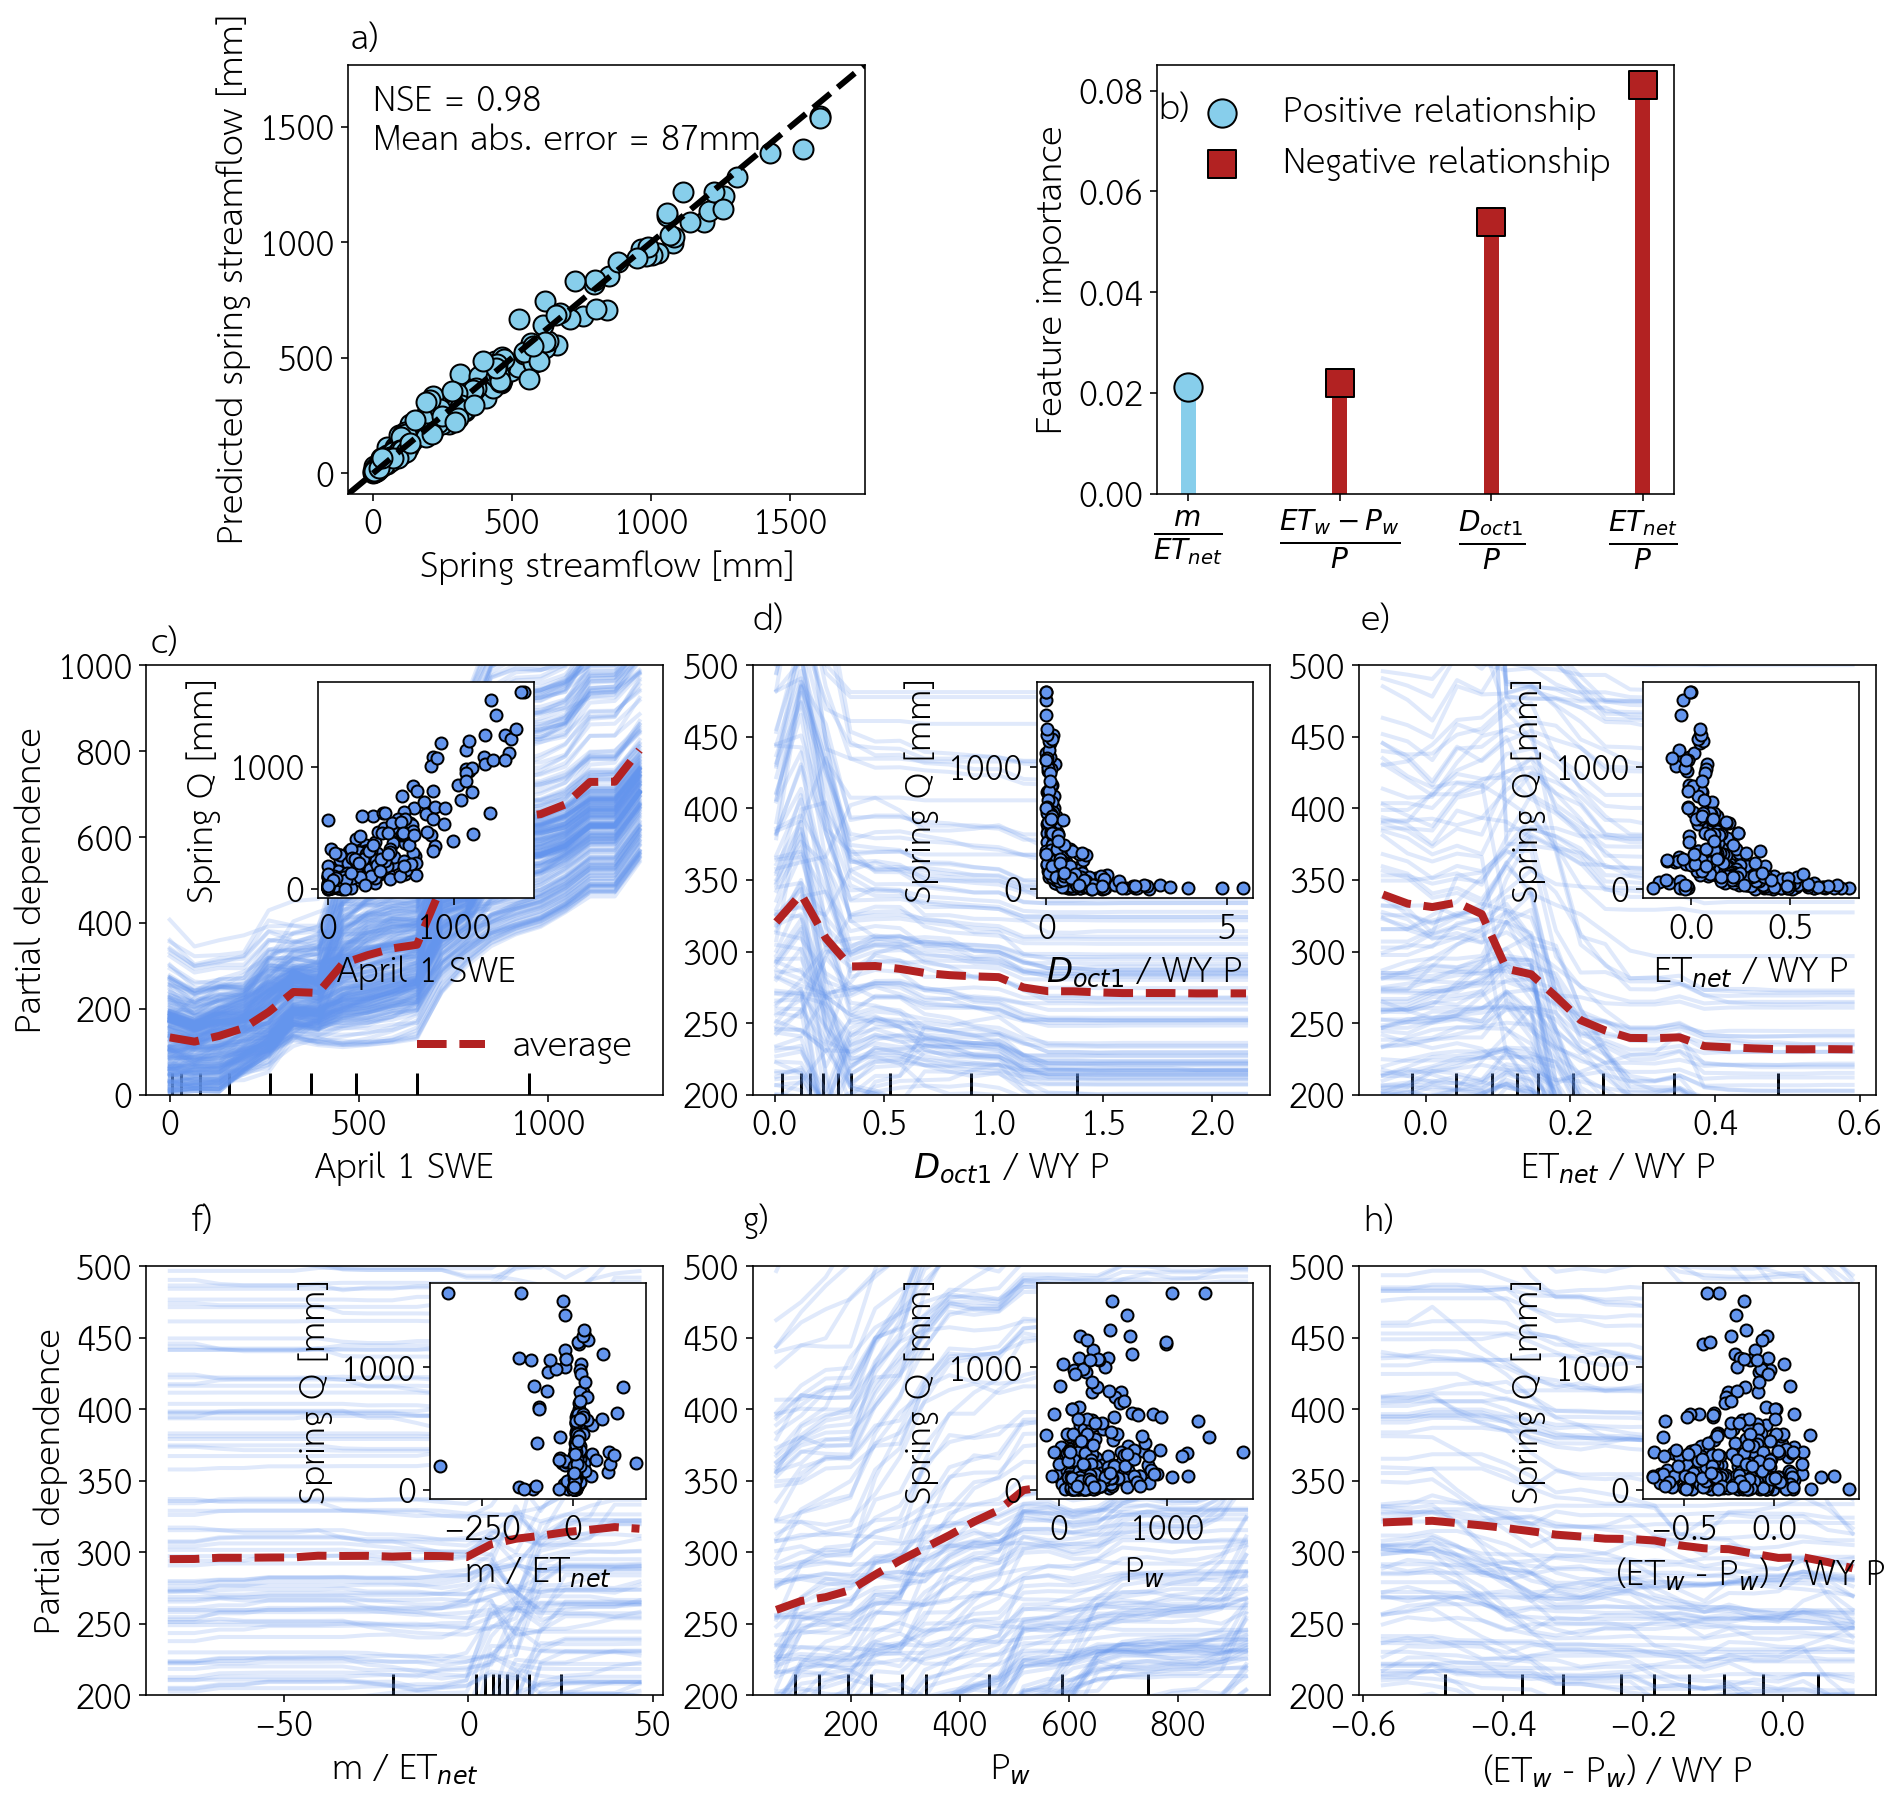

In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 17})

titles = {'aprSWE':'April 1 SWE',
          'octD/P':'$D_{oct1}$ / WY P',
          'netET':'ET$_{net}$ / WY P',
          'mfrac':'m / ET$_{net}$',
          'winter rain':'P$_w$',# + P$_s$) / WY P',
          'ETw/P':'(ET$_{w}$ - P$_w$) / WY P'}
titles1 = {'aprSWE':'SWE',
          'octD/P':r'$\frac{D_{oct1}}{P}$',
          'netET':r'$\frac{ET_{net}}{P}$',
          'mfrac':r'$\frac{m}{ET_{net}}$',
          'winter rain':r'$P_w$',#\frac{P_w + P_s}{P}$',
          'ETw/P':r'$\frac{ET_w - P_w}{P}$'}

# fig,ax = plt.subplots(2,4,figsize = (20,9))

fig = plt.figure(figsize = (15.5,15))

gs = gridspec.GridSpec(3, 9, figure=fig)
ax0 = fig.add_subplot(gs[0,1:4])
ax1 = fig.add_subplot(gs[0,5:8])
ax2 = fig.add_subplot(gs[1,:3])
ax3 = fig.add_subplot(gs[1,3:6])
ax4 = fig.add_subplot(gs[1,6:])
ax5 = fig.add_subplot(gs[2,:3])
ax6 = fig.add_subplot(gs[2,3:6])
ax7 = fig.add_subplot(gs[2,6:])

ax = [[ax0,ax2,ax3,ax4],
      [ax1,ax5,ax6,ax7]
      ]

axes = [ax[0][1],ax[0][2],ax[0][3],ax[1][1],ax[1][2],ax[1][3]]

gb = RandomForestRegressor(n_estimators=100).fit(X0, y)
# partialdep = partial_dependence(gb, features=variables_to_test, X=X0, #percentiles=(0, 1),
#                    grid_resolution=2) 

# print("Computing partial dependence plots...")
# tic = time()

features = variables_to_test
display = PartialDependenceDisplay.from_estimator(
    gb,
    X0,
    features,
    kind="both",
    # subsample=50,
    # n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ax = axes,
    ice_lines_kw={"color": "cornflowerblue", "alpha": 0.2, "linewidth": 2},
    pd_line_kw={"color": "firebrick", "linestyle": "--","linewidth":4},
)

for i in range(len(axes)):
  axes[i].set_xlabel(titles[variables_to_test[i]])
  if i>0:
    axes[i].set_ylim(200,500)
# print(f"done in {time() - tic:.3f}s")
# display.figure_.suptitle(
#     "Partial dependence of spring streamflow\n"
#     "from April 1 SWE, with MLPRegressor"
# )

for ax0 in axes:
  # ax0.set_ylim(220,560)
  ax0.legend().set_visible(False)
  if ax0 != ax[1][0]:
    ax0.set_ylabel('')

ax0 = ax[0][1]
ax0.set_ylim(0,1000)
ax0.legend(frameon=False,loc='lower right')


rect_histx = [[0.175,0.838, 0.075, 0.03],
              [0.547,0.838, 0.075, 0.03],
              [0.82,0.838, 0.075, 0.03],
              [0.273,0.4, 0.075, 0.03],
              [0.547,0.4, 0.075, 0.03],
              [0.82,0.4, 0.075, 0.03],]
for i in range(len(axes)):
  # if i>0:
  ax0 = axes[i]
  if i==0:
    axins = inset_axes(ax0, width=1.5, height=1.5,loc=2,
                      bbox_to_anchor=(.3, .5, .5, .5),
                      bbox_transform=ax0.transAxes,)
  else:
    axins = inset_axes(ax0, width=1.5, height=1.5,
                      loc=1)#,
                      # bbox_to_anchor=(.5, .4, .5, .5),
                      # bbox_transform=ax0.transAxes,)
  axins.scatter(data[variables_to_test[i]],data['springQ'],
                c='cornflowerblue',edgecolor = 'k')
  axins.set_xlabel(titles[variables_to_test[i]])
  axins.set_ylabel('Spring Q [mm]')
  
  # rect_hist = rect_histx[i]
  # ax_histx = fig.add_axes(rect_hist, sharex=axins)
  # ax_histx.hist(data[variables_to_test[i]],
  #               facecolor = 'cornflowerblue',
  #               edgecolor = 'k',
  #               alpha = 0.5)
  # plt.setp(ax_histx.get_xticklabels(), visible=False)

for ax0 in [ax[0][1],ax[1][1]]:
  ax0.set_ylabel('Partial dependence')


ax0 = ax[0][0]
ax0.scatter(y,y1,c='skyblue',s=100,edgecolor = 'k',clip_on=False)
mv = max(y)*1.1
ax0.plot([-0.05*mv,mv],[-0.05*mv,mv],c='k',ls='--',lw=3)
ax0.set_xlabel('Spring streamflow [mm]')
ax0.set_ylabel('Predicted spring streamflow [mm]')
ax0.set_xlim(-0.05*mv,mv)
ax0.set_ylim(-0.05*mv,mv)
# plt.title('all sites')
# plt.show()
from sklearn.metrics import r2_score
r2_vals.append(r2_score(y1,y))
p2021.append(y1[-1])
ax0.text(0,1400,'NSE = %0.2f\nMean abs. error = %2.0fmm' %(r2_score(y1,y),res_loo))

ax0 = ax[1][0]
poscolor = 'skyblue'
negcolor = 'firebrick'
pos = ['mfrac']#'snowfrac','mfrac',]
neg = ['octD/P','ETw/P','netET',]



label_importance = sorted(zip(importances,X0.columns))
ax0.bar([x for z,x in label_importance if x in pos+neg],
        [z for z,x in label_importance if x in pos+neg],width = 0.1,
        facecolor = poscolor)
ax0.scatter([x for z,x in label_importance if x in pos],
        [z for z,x in label_importance if x in pos],s=200,
        c = poscolor,marker='o',edgecolor = 'k',zorder = 10,
        label='Positive relationship')
ax0.bar([x for z,x in label_importance if x in neg],
        [z for z,x in label_importance if x in neg],width = 0.1,
        facecolor = negcolor)
ax0.scatter([x for z,x in label_importance if x in neg],
        [z for z,x in label_importance if x in neg],s=200,
        c = negcolor,marker='s',edgecolor = 'k',zorder = 10,
        label = 'Negative relationship')
ax0.set_xticklabels([titles1[x] for z,x in label_importance if x in pos+neg],fontsize = 20)
ax0.legend(loc='upper left',frameon=False)
# ax0.set_xticklabels(['$m/ET_{net}$',
#           '$(P_w+P_s)/P$',
#           '$(ET_w-P_w)/P$',
#           '$D_{oct1}/P$',
#           '$(ET_s-P_s)/P$'])
ax0.set_ylabel('Feature importance')

letters = ['a)','c)','d)','e)',
          'b)','f)','g)','h)']
xv = [-80,-50,-.1,-0.09,
      -0.2,-75,0.13,-0.6]
yv1 = 525
yv = [1840,1030,yv1,yv1,
      0.0745,yv1,yv1,yv1]
axes1 = [ax[0][0],ax[0][1],ax[0][2],ax[0][3],
         ax[1][0],ax[1][1],ax[1][2],ax[1][3]]

for i in range(len(axes1)):
  axes1[i].text(xv[i],yv[i],letters[i])

display.figure_.subplots_adjust(wspace=0.8, hspace=0.4)

# plt.subplots_adjust(hspace = 0.6, wspace = 0.6)

plt.savefig('random_forest_results.png',format='png',bbox_inches='tight',dpi=300)

In [ ]:
lens = [18,18,18,18,18,18,18,18,18,18,18,18,
        18,14,14]
print('NSE by site for random forest model')
for i in range(len(lens)):
  ys = y.iloc[sum(lens[:i]):sum(lens[:i+1])]
  y1s = y1[sum(lens[:i]):sum(lens[:i+1])]
  print(list(wy_totals.keys())[i],r2_score(ys,y1s))

NSE by site for random forest model
10336780 0.9362859261559875
10336645 0.9674685271789369
10336660 0.9703193039405367
10336676 0.9884311628319007
10343500 0.9119974794723312
10308783 0.6617866389984058
11383500 0.850956798576373
11189500 0.9797109863020137
11204100 0.958158848270579
11203580 0.9754194999908715
11266500 0.9862571541731918
11264500 0.9873447543936151
10265150 0.1767513998009015
P300 0.9215793894001378
B200 0.9613508241610237


build separate random forest models for wet/dry years

In [ ]:
X0_dry = ''
drylens = {site:0 for site in gages.SITE_NO.values}
wetlens = {site:0 for site in gages.SITE_NO.values}

for site in gages.SITE_NO.values:
  data = wy_totals[site]

  #define response variable
  y = data['springQ'].drop_duplicates()#data['residuals']

  data['octD/P'] = (data.octDeficit)/data.P
  data['residuals'] = residuals[site]
  # data['maxD/P'] = data.maxDeficit/data.P
  data['aprD'] = (data.aprDeficit)/data.winter_P#/data.P
  data['springET/P'] = data.springET/data.P#aprSWE#data.winter_P#/data.melt_rate/120
  data['springP'] = data.spring_rain/data.P#winter_P
  data['netET'] = (data.springET-data.spring_rain)/data.P
  # data['netET']
  # data['input_flux_term'] = (data.adjP-data.springET)/data.melt_rate
  # data['fluxdiff'] = (data.springET)/data.P#-data.spring_rain)/data.P
  data['octD/wintP'] = data.octDeficit/data.winter_P
  data['m'] = data.melt_rate#*30-data.springET/4#/(data.springET-data.spring_rain)*4
  data['mfrac'] = data.melt_rate/(data.springET-data.spring_rain)*4*30
  data['mfrac'] = np.where(np.isfinite(data.mfrac),data.mfrac,10)
  data['ETw/P'] = (data.winterET-data.winter_rain)/data.P
  # data['aprD/P'] = data.aprDeficit/data.P
  data['snowfrac'] = (data.winter_rain+data.spring_rain)/data.P#
  data['winter rain'] = data.winter_rain
  data['wintP'] = data.winter_rain#/data.P
  P75 = np.nanpercentile(data.P,75)
  P25 = np.nanpercentile(data.P,25)
  wet_years = data[data.P>P75].index.values
  dry_years = data[data.P<P25].index.values
  wet_years = [i+1 for i in wet_years]
  dry_years = [i+1 for i in dry_years if i!=2021]

  variables_to_test = ['aprSWE','octD/P',
                    #  'octD/wintP',
                      'netET',
                      'mfrac',
                      'winter rain',
                      'ETw/P',
                       'springQ']

  data = data[variables_to_test]

  data_dry = data.loc[dry_years]
  data_wet = data.loc[wet_years].dropna()

  drylens[site] = len(data_dry)
  wetlens[site] = len(data_wet)

  if len(X0_dry)==0:
    X0_dry = data_dry
    X0_wet = data_wet
  else:
    X0_dry = pd.concat([X0_dry,data_dry])
    X0_wet = pd.concat([X0_wet,data_wet])

# set up model
model_dry = RandomForestRegressor(n_estimators=100)
model_wet = RandomForestRegressor(n_estimators=100)

# fit model
model_dry.fit(X0_dry.drop(columns='springQ'),X0_dry.springQ)
model_wet.fit(X0_wet.drop(columns='springQ'),X0_wet.springQ)

# get feature importance
importances_dry = model_dry.feature_importances_
importances_wet = model_wet.feature_importances_


# get r2 vals
r2_dry = r2_score(model_dry.predict(X0_dry.drop(columns='springQ')),X0_dry.springQ)
r2_wet = r2_score(model_wet.predict(X0_wet.drop(columns='springQ')),X0_wet.springQ)

# do LOO cross-validation
res_loos = []
for X in [X0_dry,X0_wet]:
  yt = X.springQ
  X = X.drop(columns='springQ')
  residuals_loo = []
  for i in range(len(X)):
    X0_test = X.reset_index()[X.reset_index().index!=i].drop(columns='wy')
    y_test = list(yt.copy().values)
    y_test.pop(i)
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X0_test,y_test)
    ypred = model.predict(X0.iloc[[i]])
    res_test = abs(yt.values[i]-ypred)
    residuals_loo.append(res_test)
  res_loo = np.nanmean(residuals_loo)
  res_loos.append(res_loo)

In [ ]:
r2_wet,r2_dry,res_loos

(0.969773266745021,
 0.9629410907235665,
 [285.0855152701183, 403.05601956089174])

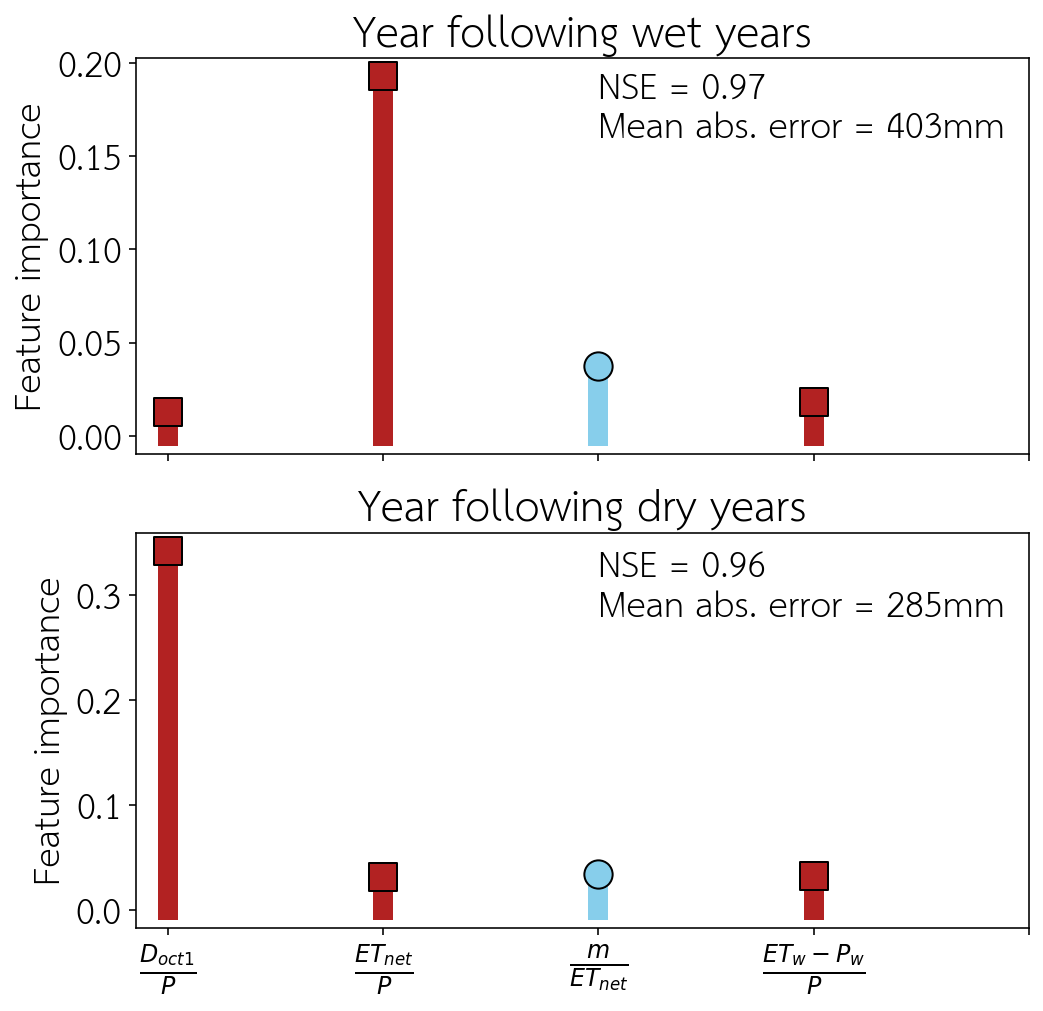

In [ ]:
fig,axs = plt.subplots(2,figsize = (8,8),sharex=True)

j=1
for i in range(1,len(importances_dry)):
  if i!=4:
    if i==3:
      color = 'skyblue'
      marker = 'o'
    else:
      color = 'firebrick'
      marker = 's'
    axs[1].plot([j,j],[0,importances_dry[i]],lw=10,c=color)
    axs[1].scatter(j,importances_dry[i],c=color,edgecolor = 'k',
                  marker = marker,zorder = 100,s=200)
    axs[0].plot([j,j],[0,importances_wet[i]],lw=10,c=color)
    axs[0].scatter(j,importances_wet[i],c=color,edgecolor = 'k',
                  marker = marker,zorder = 100,s=200)
    j+=1


axs[0].set_title('Year following wet years')
axs[1].set_title('Year following dry years')

axs[0].text(3.,0.16,'NSE = %1.2f\nMean abs. error = %3.0fmm' %(r2_wet,res_loos[1]))
axs[1].text(3.,0.28,'NSE = %1.2f\nMean abs. error = %3.0fmm' %(r2_dry,res_loos[0]))

for i in range(len(axs)):
  axs[i].set_xticks(list(range(1,len(importances_dry))))
  axs[i].set_xticklabels(data_dry.columns.values[1:])#,rotation=90)
  axs[i].set_xticklabels([r'$\frac{D_{oct1}}{P}$',
                          r'$\frac{ET_{net}}{P}$',
                          r'$\frac{m}{ET_{net}}$',
                          r'$\frac{ET_w-P_w}{P}$'
                          ])
  axs[i].set_ylabel('Feature importance')

## Use multiple linear regression to examine relative importance of proposed mechanisms

In [19]:
# do single regression with all parameters included

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score

results1 = {'site':[],
           'Apr 1 SWE':[],
           'Oct D':[],
           'Apr D/P':[],
           'Oct D/wintP':[],
           'max D/P':[],
           'Apr D':[],
           'ET':[],
           'netET':[],
           'mfrac':[],
           'springP':[],
           'm':[],
           'ETw/P':[],
           'snowfrac':[],
           'const':[],
           'r2':[],
           'justSWE_r2':[],
           'pred2021':[],
           'pred2021_SWE':[],
           'Q2021':[],
           'SWE_D_only_r2':[],
           'pred2021_SWE_D':[],
            'pred2006':[],
            'pred2006_SWE':[],
            'Q2006':[],
            'pred2006_SWE_D':[],
            'r2wet':[],
            'crossval':[],
            'crossval_wet':[],
            'crossval_dry':[],
            'crossval_swe_wet':[],
            'crossval_swe_dry':[],
            'crossval_swed_wet':[],
            'crossval_swed_dry':[],
            'crossval_swe':[],
            'crossval_swed':[],
           }
results_dry = {'site':[],
           'Apr 1 SWE':[],
           'Oct D':[],
           'Apr D/P':[],
           'Oct D/wintP':[],
           'max D/P':[],
           'Apr D':[],
           'ET':[],
           'netET':[],
           'mfrac':[],
           'springP':[],
           'm':[],
           'ETw/P':[],
           'snowfrac':[],
           'const':[],
           'r2':[],
           'justSWE_r2':[],
           'pred2021':[],
           'pred2021_SWE':[],
           'Q2021':[],
           'SWE_D_only_r2':[],
           'pred2021_SWE_D':[],
            'pred2006':[],
            'pred2006_SWE':[],
            'Q2006':[],
            'pred2006_SWE_D':[],
            'r2dry':[],
            # 'crossvaldry':[]
           }

results_wet = {'site':[],
           'Apr 1 SWE':[],
           'Oct D':[],
           'Apr D/P':[],
           'Oct D/wintP':[],
           'max D/P':[],
           'Apr D':[],
           'ET':[],
           'netET':[],
           'mfrac':[],
           'springP':[],
           'm':[],
           'ETw/P':[],
           'snowfrac':[],
           'const':[],
            'r2wet':[],
            # 'crossvalwet':[]
           }

for site in gages.SITE_NO.values:
  data = wy_totals[site]

  #define response variable
  y = data['springQ'].drop_duplicates()#data['residuals']

  data['octD/P'] = (data.octDeficit)/data.P
  data['residuals'] = residuals[site]
  # data['maxD/P'] = data.maxDeficit/data.P
  data['aprD'] = (data.aprDeficit)/data.winter_P#/data.P
  data['springET/P'] = data.springET/data.P#aprSWE#data.winter_P#/data.melt_rate/120
  data['springP'] = data.spring_rain/data.P#winter_P
  data['netET'] = (data.springET-data.spring_rain)/data.P
  # data['netET']
  # data['input_flux_term'] = (data.adjP-data.springET)/data.melt_rate
  # data['fluxdiff'] = (data.springET)/data.P#-data.spring_rain)/data.P
  data['octD/wintP'] = data.octDeficit/data.winter_P
  data['m'] = data.melt_rate#*30-data.springET/4#/(data.springET-data.spring_rain)*4
  data['mfrac'] = data.melt_rate/(data.springET-data.spring_rain)*4*30
  data['mfrac'] = np.where(np.isfinite(data.mfrac),data.mfrac,10)
  data['ETw/P'] = (data.winterET-data.winter_rain)/data.P
  # data['aprD/P'] = data.aprDeficit/data.P
  data['snowfrac'] = (data.winter_rain+data.spring_rain)/data.P#
  data['wintP'] = data.winter_rain#/data.P

  variables_to_test = ['aprSWE',
                       'octD/P',
                      #  'springET/P',
                      # 'springP',
                      #  'm',
                      #  'octD/wintP',
                       'netET',
                       'mfrac',
                      #  'snowfrac',
                       'wintP',
                       'ETw/P',
                      #  'aprD/P'
                      #  'aprD'
                       ]#,'octD/wintP',]
  
  r2vals_big = []
  pred2021_big = []
  pred2006_big = []


  x = data[[p for p in variables_to_test]].drop_duplicates()

  #add constant to predictor variables
  x = sm.add_constant(x)

  xy = x.merge(y,left_index=True,right_index=True).dropna()
  # xy['residuals'] = residuals[site]

  #fit regression model
  model = sm.OLS(xy['springQ'], xy.drop(columns='springQ')).fit()
  # model = sm.OLS(xy['residuals'], xy.drop(columns=['residuals',site])).fit()

  r2vals_big.append(model.rsquared)

  ## LOO cross-val

  residuals_loo = []
  for i in range(len(xy)):
    X0_test = xy.reset_index()[xy.reset_index().index!=i].drop(columns='wy')
    y_test = list(xy.springQ.values.copy())
    y_test.pop(i)
    m = sm.OLS(y_test, X0_test.drop(columns='springQ')).fit()
    ypred = m.predict(xy.drop(columns='springQ').iloc[[i]])
    res_test = abs(xy.springQ.iloc[i]-ypred)
    residuals_loo.append(res_test)
  cross_val = np.mean(residuals_loo)

  P75 = np.nanpercentile(data.P,75)
  P25 = np.nanpercentile(data.P,25)
  wet_years = data[data.P>P75].index.values
  dry_years = data[data.P<P25].index.values
  wet_years = [i+1 for i in wet_years]
  dry_years = [i+1 for i in dry_years if i!=2021]

  residuals_loo = []
  xyz = xy.loc[[d for d in dry_years if d in xy.index]]
  for i in range(len(xyz)):
    X0_test = xyz.reset_index()[xyz.reset_index().index!=i].drop(columns='wy')
    y_test = list(xyz.springQ.values.copy())
    y_test.pop(i)
    m = sm.OLS(y_test, X0_test.drop(columns='springQ')).fit()
    ypred = m.predict(xyz.drop(columns='springQ').iloc[[i]])
    res_test = abs(xyz.springQ.iloc[i]-ypred)
    residuals_loo.append(res_test)
  cross_val_dry = np.mean(residuals_loo)



  residuals_loo = []
  xyz = xy.loc[[d for d in wet_years if d in xy.index]]
  for i in range(len(xyz)):
    X0_test = xyz.reset_index()[xyz.reset_index().index!=i].drop(columns='wy')
    y_test = list(xyz.springQ.values.copy())
    y_test.pop(i)
    m = sm.OLS(y_test, X0_test.drop(columns='springQ')).fit()
    ypred = m.predict(xyz.drop(columns='springQ').iloc[[i]])
    res_test = abs(xyz.springQ.iloc[i]-ypred)
    residuals_loo.append(res_test)
  cross_val_wet = np.mean(residuals_loo)
  
  pred2021_big.append(np.sum(model.params.values*x.iloc[-1].values.flatten()))
  pred2006_big.append(np.sum(model.params.values*x.iloc[-16].values.flatten()))

  # do just with April 1 SWE now

  x = data[[p for p in [variables_to_test[0],
                        'wintP',
                        ]]].drop_duplicates()

  #add constant to predictor variables
  x = sm.add_constant(x)

  xy = x.merge(y,left_index=True,right_index=True).dropna()
  # xy['residuals'] = residuals[site]

  #fit regression model
  model1 = sm.OLS(xy['springQ'], xy.drop(columns='springQ')).fit()
  # model = sm.OLS(xy['residuals'], xy.drop(columns=['residuals',site])).fit()


  

  ## LOO cross-val
  residuals_loo = []
  for i in range(len(xy)):
    X0_test = xy.reset_index()[xy.reset_index().index!=i].drop(columns='wy')
    y_test = list(xy.springQ.values.copy())
    y_test.pop(i)
    m = sm.OLS(y_test, X0_test.drop(columns='springQ')).fit()
    ypred = m.predict(xy.drop(columns='springQ').iloc[[i]])
    res_test = abs(xy.springQ.iloc[i]-ypred)
    residuals_loo.append(res_test)
  cross_val_swe = np.mean(residuals_loo)

  residuals_loo = []
  xyz = xy.loc[dry_years]
  for i in range(len(xyz)):
    X0_test = xyz.reset_index()[xyz.reset_index().index!=i].drop(columns='wy')
    y_test = list(xyz.springQ.values.copy())
    y_test.pop(i)
    m = sm.OLS(y_test, X0_test.drop(columns='springQ')).fit()
    ypred = m.predict(xyz.drop(columns='springQ').iloc[[i]])
    res_test = abs(xyz.springQ.iloc[i]-ypred)
    residuals_loo.append(res_test)
  cross_val_swe_dry = np.mean(residuals_loo)

  residuals_loo = []
  xyz = xy.loc[[d for d in wet_years if d in xy.index]]
  for i in range(len(xyz)):
    X0_test = xyz.reset_index()[xyz.reset_index().index!=i].drop(columns='wy')
    y_test = list(xyz.springQ.values.copy())
    y_test.pop(i)
    m = sm.OLS(y_test, X0_test.drop(columns='springQ')).fit()
    ypred = m.predict(xyz.drop(columns='springQ').iloc[[i]])
    res_test = abs(xyz.springQ.iloc[i]-ypred)
    residuals_loo.append(res_test)
  cross_val_swe_wet = np.mean(residuals_loo)



  r2valswe = (model1.rsquared)
  preds = (model1.params.values*x).sum(axis=1)
  try:
    wetyr_pred = preds.loc[wet_years].values
    actualwet = y.loc[wet_years].values.flatten()
  except:
    if site in ['B200','P300']:
      wetyr_pred = preds.loc[[w for w in wet_years if w not in [2006,2020]]].values
      actualwet = y.loc[[w for w in wet_years if w not in [2006,2020]]].values.flatten()
    else:
      try:
        wetyr_pred = preds.loc[[w for w in wet_years if w != 2015]].values
        actualwet = y.loc[[w for w in wet_years if w != 2015]].values.flatten()
      except:
        wetyr_pred = preds.loc[[w for w in wet_years if w not in [2006,2007,2017,2018,2020]]].values
        actualwet = y.loc[[w for w in wet_years if w not in [2006,2007,2017,2018,2020]]].values.flatten()
  try:
    dryyr_pred = preds.loc[dry_years].values
    actualdry = y.loc[dry_years].values.flatten()
  except:
    if site not in ['B200','P300']:
      skip = [2008, 2013, 2014, 2015, 2016]
    else:
      skip = []
    dryyr_pred = preds.loc[[w for w in dry_years if w not in skip]].values
    actualdry = y.loc[[w for w in dry_years if w not in skip]].values.flatten()
  r2_wet = r2_score(wetyr_pred,actualwet)
  try:
    r2_dry = r2_score(dryyr_pred,actualdry)
  except:
    r2_dry = np.nan
  
  pred2021swe = (np.sum(model1.params.values*x.iloc[-1].values.flatten()))
  try:
    pred2006swe = (np.sum(model1.params.values*x.iloc[-16].values.flatten()))
  except:
    pred2006swe = np.nan


  # do just with April 1 SWE and D now

  x = data[[p for p in ['aprSWE','octD/wintP']]].drop_duplicates()

  #add constant to predictor variables
  x = sm.add_constant(x)

  xy = x.merge(y,left_index=True,right_index=True).dropna()
  # xy['residuals'] = residuals[site]

  #fit regression model
  model2 = sm.OLS(xy['springQ'], xy.drop(columns='springQ')).fit()
  # model = sm.OLS(xy['residuals'], xy.drop(columns=['residuals',site])).fit()

  r2valswed = (model2.rsquared)

  ## LOO cross-val

  residuals_loo = []
  for i in range(len(xy)):
    X0_test = xy.reset_index()[xy.reset_index().index!=i].drop(columns='wy')
    y_test = list(xy.springQ.values.copy())
    y_test.pop(i)
    m = sm.OLS(y_test, X0_test.drop(columns='springQ')).fit()
    ypred = m.predict(xy.drop(columns='springQ').iloc[[i]])
    res_test = abs(xy.springQ.iloc[i]-ypred)
    residuals_loo.append(res_test)
  cross_val_swed = np.mean(residuals_loo)

  residuals_loo = []
  xyz = xy.loc[dry_years]
  for i in range(len(xyz)):
    X0_test = xyz.reset_index()[xyz.reset_index().index!=i].drop(columns='wy')
    y_test = list(xyz.springQ.values.copy())
    y_test.pop(i)
    m = sm.OLS(y_test, X0_test.drop(columns='springQ')).fit()
    ypred = m.predict(xyz.drop(columns='springQ').iloc[[i]])
    res_test = abs(xyz.springQ.iloc[i]-ypred)
    residuals_loo.append(res_test)
  cross_val_swed_dry = np.mean(residuals_loo)

  residuals_loo = []
  xyz = xy.loc[[d for d in wet_years if d in xy.index]]
  for i in range(len(xyz)):
    X0_test = xyz.reset_index()[xyz.reset_index().index!=i].drop(columns='wy')
    y_test = list(xyz.springQ.values.copy())
    y_test.pop(i)
    m = sm.OLS(y_test, X0_test.drop(columns='springQ')).fit()
    ypred = m.predict(xyz.drop(columns='springQ').iloc[[i]])
    res_test = abs(xyz.springQ.iloc[i]-ypred)
    residuals_loo.append(res_test)
  cross_val_swed_wet = np.mean(residuals_loo)
  
  pred2021swed = (np.sum(model2.params.values*x.iloc[-1].values.flatten()))
  pred2006swed = (np.sum(model2.params.values*x.iloc[-16].values.flatten()))

  # ## calculate confidence interval for 2021 point
  minparams = model2.conf_int(alpha=0.05)[0].values
  maxparams = model2.conf_int(alpha=0.05)[1].values
  xx = data[[p for p in ['aprSWE','octD/wintP']]].drop_duplicates().loc[2021].values
  min2021 = minparams[0]+minparams[1]*xx[0]+minparams[2]*xx[1]
  max2021 = maxparams[0]+maxparams[1]*xx[0]+maxparams[2]*xx[1]
  # min2021,max2021,xy.springQ.loc[2021]
  print('Confidence range for 2021: ',min2021, max2021)
  print('2021 value: ',xy.springQ.loc[2021])
  


  # print(r2vals)
  bestparams = variables_to_test
  compare_params = model.params.to_frame()
  paramdict = model.params.to_dict()
  paramdict = {'params':list(paramdict.keys()),
               'value':[paramdict[p] for p in paramdict.keys()]}
  compare_params_dry = pd.DataFrame.from_dict(paramdict).set_index('params')
  compare_params_wet = pd.DataFrame.from_dict(paramdict).set_index('params')

  

  
  
  # dry_years = [2008,2009,2012,2013,2014,2015,2020,2021]
  # wet_years = [2006,2007,2011,2017,2019]
  for param in compare_params.index:
    if param=='const':
      print('')
    else:
      compare_params.loc[param] = compare_params.loc[param]*abs(np.nanmedian(data[param].loc[wet_years]))
      compare_params_dry.loc[param] = compare_params_dry.loc[param]*abs(np.nanmedian(data[param].loc[dry_years]))
      compare_params_wet.loc[param] = compare_params_wet.loc[param]*abs(np.nanmedian(data[param].loc[wet_years]))
  print('term importance comparison:',compare_params)
  print('')

  

  # save effect size for each parameter included in model
  results1['site'].append(site)
  if 'aprSWE' in bestparams:
    results1['Apr 1 SWE'].append(compare_params.loc['aprSWE'].values[0])
  else:
    results1['Apr 1 SWE'].append(0)
  if 'octD/P' in bestparams:
    results1['Oct D'].append(compare_params.loc['octD/P'].values[0])
  else:
    results1['Oct D'].append(0)
  if 'aprD/P' in bestparams:
    results1['Apr D/P'].append(compare_params.loc['aprD/P'].values[0])
  else:
    results1['Apr D/P'].append(0)
  if 'maxD/P' in bestparams:
    results1['max D/P'].append(compare_params.loc['maxD/P'].values[0])
  else:
    results1['max D/P'].append(0)
  if 'octD/wintP' in bestparams:
    results1['Oct D/wintP'].append(compare_params.loc['octD/wintP'].values[0])
  else:
    results1['Oct D/wintP'].append(0)
  if 'aprD' in bestparams:
    results1['Apr D'].append(compare_params.loc['aprD'].values[0])
  else:
    results1['Apr D'].append(0)
  if 'm' in bestparams:
    results1['m'].append(compare_params.loc['m'].values[0])
  else:
    results1['m'].append(0)
  if 'mfrac' in bestparams:
    results1['mfrac'].append(compare_params.loc['mfrac'].values[0])
  else:
    results1['mfrac'].append(0)
  if 'springET/P' in bestparams:
    results1['ET'].append(compare_params.loc['springET/P'].values[0])
  else:
    results1['ET'].append(0)
  if 'ETw/P' in bestparams:
    results1['ETw/P'].append(compare_params.loc['ETw/P'].values[0])
  else:
    results1['ETw/P'].append(0)
  if 'wintP' in bestparams:
    results1['snowfrac'].append(compare_params.loc['wintP'].values[0])
  else:
    results1['snowfrac'].append(0)
  if 'netET' in bestparams:
    results1['netET'].append(compare_params.loc['netET'].values[0])
  else:
    results1['netET'].append(0)
  if 'springP' in bestparams:
    results1['springP'].append(compare_params.loc['springP'].values[0])
  else:
    results1['springP'].append(0)
  results1['const'].append(compare_params.loc['const'].values[0])
  results1['r2'].append(model.rsquared)
  results1['justSWE_r2'].append(r2valswe)
  results1['SWE_D_only_r2'].append(r2valswed)
  results1['pred2021'].append(pred2021_big[-1])
  results1['pred2006'].append(pred2006_big[-1])
  results1['pred2006_SWE'].append(pred2006swe)
  results1['pred2021_SWE'].append(pred2021swe)
  results1['pred2021_SWE_D'].append(pred2021swed)
  results1['pred2006_SWE_D'].append(pred2006swed)
  results1['Q2021'].append(data.springQ.values[-1])
  results1['Q2006'].append(data.springQ.values[-16])
  results1['r2wet'].append(r2_wet)
  results1['crossval'].append(cross_val)
  results1['crossval_swe'].append(cross_val_swe)
  results1['crossval_swed'].append(cross_val_swed)
  results1['crossval_wet'].append(cross_val_wet)
  results1['crossval_swe_wet'].append(cross_val_swe_wet)
  results1['crossval_swed_wet'].append(cross_val_swed_wet)
  results1['crossval_dry'].append(cross_val_dry)
  results1['crossval_swe_dry'].append(cross_val_swe_dry)
  results1['crossval_swed_dry'].append(cross_val_swed_dry)

  results_dry['site'].append(site)
  if 'aprSWE' in bestparams:
    results_dry['Apr 1 SWE'].append(compare_params_dry.loc['aprSWE'].values[0])
  else:
    results_dry['Apr 1 SWE'].append(0)
  if 'octD/P' in bestparams:
    results_dry['Oct D'].append(compare_params_dry.loc['octD/P'].values[0])
  else:
    results_dry['Oct D'].append(0)
  if 'aprD/P' in bestparams:
    results_dry['Apr D/P'].append(compare_params_dry.loc['aprD/P'].values[0])
  else:
    results_dry['Apr D/P'].append(0)
  if 'maxD/P' in bestparams:
    results_dry['max D/P'].append(compare_params_dry.loc['maxD/P'].values[0])
  else:
    results_dry['max D/P'].append(0)
  if 'octD/wintP' in bestparams:
    results_dry['Oct D/wintP'].append(compare_params_dry.loc['octD/wintP'].values[0])
  else:
    results_dry['Oct D/wintP'].append(0)
  if 'aprD' in bestparams:
    results_dry['Apr D'].append(compare_params_dry.loc['aprD'].values[0])
  else:
    results_dry['Apr D'].append(0)
  if 'm' in bestparams:
    results_dry['m'].append(compare_params_dry.loc['m'].values[0])
  else:
    results_dry['m'].append(0)
  if 'mfrac' in bestparams:
    results_dry['mfrac'].append(compare_params_dry.loc['mfrac'].values[0])
  else:
    results_dry['mfrac'].append(0)
  if 'springET/P' in bestparams:
    results_dry['ET'].append(compare_params_dry.loc['springET/P'].values[0])
  else:
    results_dry['ET'].append(0)
  if 'ETw/P' in bestparams:
    results_dry['ETw/P'].append(compare_params_dry.loc['ETw/P'].values[0])
  else:
    results_dry['ETw/P'].append(0)
  if 'wintP' in bestparams:
    results_dry['snowfrac'].append(compare_params_dry.loc['wintP'].values[0])
  else:
    results_dry['snowfrac'].append(0)
  if 'netET' in bestparams:
    results_dry['netET'].append(compare_params_dry.loc['netET'].values[0])
  else:
    results_dry['netET'].append(0)
  if 'springP' in bestparams:
    results_dry['springP'].append(compare_params_dry.loc['springP'].values[0])
  else:
    results_dry['springP'].append(0)
  results_dry['const'].append(compare_params_dry.loc['const'].values[0])
  results_dry['r2'].append(model.rsquared)
  results_dry['justSWE_r2'].append(r2valswe)
  results_dry['SWE_D_only_r2'].append(r2valswed)
  results_dry['pred2021'].append(pred2021_big[-1])
  results_dry['pred2006'].append(pred2006_big[-1])
  results_dry['pred2006_SWE'].append(pred2006swe)
  results_dry['pred2021_SWE'].append(pred2021swe)
  results_dry['pred2021_SWE_D'].append(pred2021swed)
  results_dry['pred2006_SWE_D'].append(pred2006swed)
  results_dry['Q2021'].append(data.springQ.values[-1])
  results_dry['Q2006'].append(data.springQ.values[-16])
  results_dry['r2dry'].append(r2_dry)

  results_wet['site'].append(site)
  if 'aprSWE' in bestparams:
    results_wet['Apr 1 SWE'].append(compare_params_wet.loc['aprSWE'].values[0])
  else:
    results_wet['Apr 1 SWE'].append(0)
  if 'octD/P' in bestparams:
    results_wet['Oct D'].append(compare_params_wet.loc['octD/P'].values[0])
  else:
    results_wet['Oct D'].append(0)
  if 'aprD/P' in bestparams:
    results_wet['Apr D/P'].append(compare_params_wet.loc['aprD/P'].values[0])
  else:
    results_wet['Apr D/P'].append(0)
  if 'maxD/P' in bestparams:
    results_wet['max D/P'].append(compare_params_wet.loc['maxD/P'].values[0])
  else:
    results_wet['max D/P'].append(0)
  if 'octD/wintP' in bestparams:
    results_wet['Oct D/wintP'].append(compare_params_wet.loc['octD/wintP'].values[0])
  else:
    results_wet['Oct D/wintP'].append(0)
  if 'aprD' in bestparams:
    results_wet['Apr D'].append(compare_params_wet.loc['aprD'].values[0])
  else:
    results_wet['Apr D'].append(0)
  if 'm' in bestparams:
    results_wet['m'].append(compare_params_wet.loc['m'].values[0])
  else:
    results_wet['m'].append(0)
  if 'mfrac' in bestparams:
    results_wet['mfrac'].append(compare_params_wet.loc['mfrac'].values[0])
  else:
    results_wet['mfrac'].append(0)
  if 'springET/P' in bestparams:
    results_wet['ET'].append(compare_params_wet.loc['springET/P'].values[0])
  else:
    results_wet['ET'].append(0)
  if 'ETw/P' in bestparams:
    results_wet['ETw/P'].append(compare_params_wet.loc['ETw/P'].values[0])
  else:
    results_wet['ETw/P'].append(0)
  if 'wintP' in bestparams:
    results_wet['snowfrac'].append(compare_params_wet.loc['wintP'].values[0])
  else:
    results_wet['snowfrac'].append(0)
  if 'netET' in bestparams:
    results_wet['netET'].append(compare_params_wet.loc['netET'].values[0])
  else:
    results_wet['netET'].append(0)
  if 'springP' in bestparams:
    results_wet['springP'].append(compare_params_wet.loc['springP'].values[0])
  else:
    results_wet['springP'].append(0)
  results_wet['const'].append(compare_params_wet.loc['const'].values[0])
  results_wet['r2wet'].append(r2_wet)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -367.44685016702664 397.6953746672682
2021 value:  56.4488456009301

term importance comparison:                  0
const   -69.349781
aprSWE  140.149468
octD/P  -41.419165
netET   -41.841237
mfrac    -2.396441
wintP   117.960220
ETw/P     4.927248



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -416.48179213068954 943.4454104198279
2021 value:  219.0365409924111

term importance comparison:                  0
const   391.410010
aprSWE  345.014221
octD/P -130.326229
netET   -48.108548
mfrac     4.036349
wintP  -267.396108
ETw/P  -266.971543



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -365.4320858996613 985.4982707840651
2021 value:  258.22282803083874

term importance comparison:                  0
const   217.265810
aprSWE  365.826123
octD/P  -99.731047
netET   -81.383578
mfrac     8.280165
wintP   167.380586
ETw/P     7.490269



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -290.97623735767604 783.068434459145
2021 value:  228.2114720981427

term importance comparison:                  0
const   193.341672
aprSWE  361.937870
octD/P -120.502395
netET   -85.112276
mfrac     5.720068
wintP    93.982836
ETw/P   -30.246230



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -572.1965592899129 536.1447549955232
2021 value:  48.7123324238865

term importance comparison:                  0
const   -63.959464
aprSWE  211.318372
octD/P  -30.375737
netET   -35.233918
mfrac     2.566361
wintP    25.545215
ETw/P   -21.043731



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -82.64109660123898 164.30013934314042
2021 value:  4.434221928834766

term importance comparison:                  0
const   -40.940457
aprSWE   27.706544
octD/P  -16.890955
netET    -5.262162
mfrac   -10.254995
wintP   124.985525
ETw/P    46.355080



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -310.3949251906902 387.5025562798807
2021 value:  65.64727208302892

term importance comparison:                  0
const   135.417208
aprSWE   19.815201
octD/P   23.887776
netET   -35.889724
mfrac    -1.531385
wintP   181.170480
ETw/P   195.131157



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -72.96105253382892 72.02194600083138
2021 value:  3.543647303021612

term importance comparison:                 0
const   -0.901017
aprSWE  18.029239
octD/P  -7.075886
netET  -41.804397
mfrac   -5.813510
wintP   69.339430
ETw/P   21.660623



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -79.68852092276057 96.57439755455435
2021 value:  4.716359995659499

term importance comparison:                 0
const   71.959503
aprSWE   4.232815
octD/P -15.937609
netET  -31.911273
mfrac   -0.152937
wintP   50.697213
ETw/P   28.076055



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -106.96131475447777 267.5439034619435
2021 value:  20.411236903949582

term importance comparison:                  0
const    96.696752
aprSWE   16.614316
octD/P  -22.622811
netET   -51.596224
mfrac     1.570311
wintP   107.659243
ETw/P    39.554966



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -241.63692840007212 800.11963352138
2021 value:  228.48407465877497

term importance comparison:                  0
const    50.094523
aprSWE  233.574052
octD/P  -42.572373
netET   -51.908262
mfrac    10.783540
wintP   151.765678
ETw/P    45.976598



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -296.1648478560605 840.8727324927057
2021 value:  234.7395360809746

term importance comparison:                  0
const     9.206619
aprSWE  196.575197
octD/P  -17.296551
netET   -60.169125
mfrac     0.648819
wintP   207.677745
ETw/P    26.225544



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -80.52934812270779 231.83731620863009
2021 value:  74.34539965923739

term importance comparison:                 0
const   88.079052
aprSWE  14.633774
octD/P  -8.275582
netET  -25.377256
mfrac    0.581020
wintP   48.890347
ETw/P   11.659906



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Confidence range for 2021:  -355.422482765278 716.9721198574375
2021 value:  2.2443397809675973

term importance comparison:                  0
const    60.774264
aprSWE    3.384123
octD/P  -72.180177
netET    -5.687897
mfrac    -1.185646
wintP   304.055991
ETw/P   183.885057

Confidence range for 2021:  -325.8290835158792 791.1654472710904
2021 value:  31.05718327853164

term importance comparison:                  0
const   508.864292
aprSWE   28.553758
octD/P  -19.369283
netET  -257.892997
mfrac    25.517943
wintP   -83.413509
ETw/P   -54.626024



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


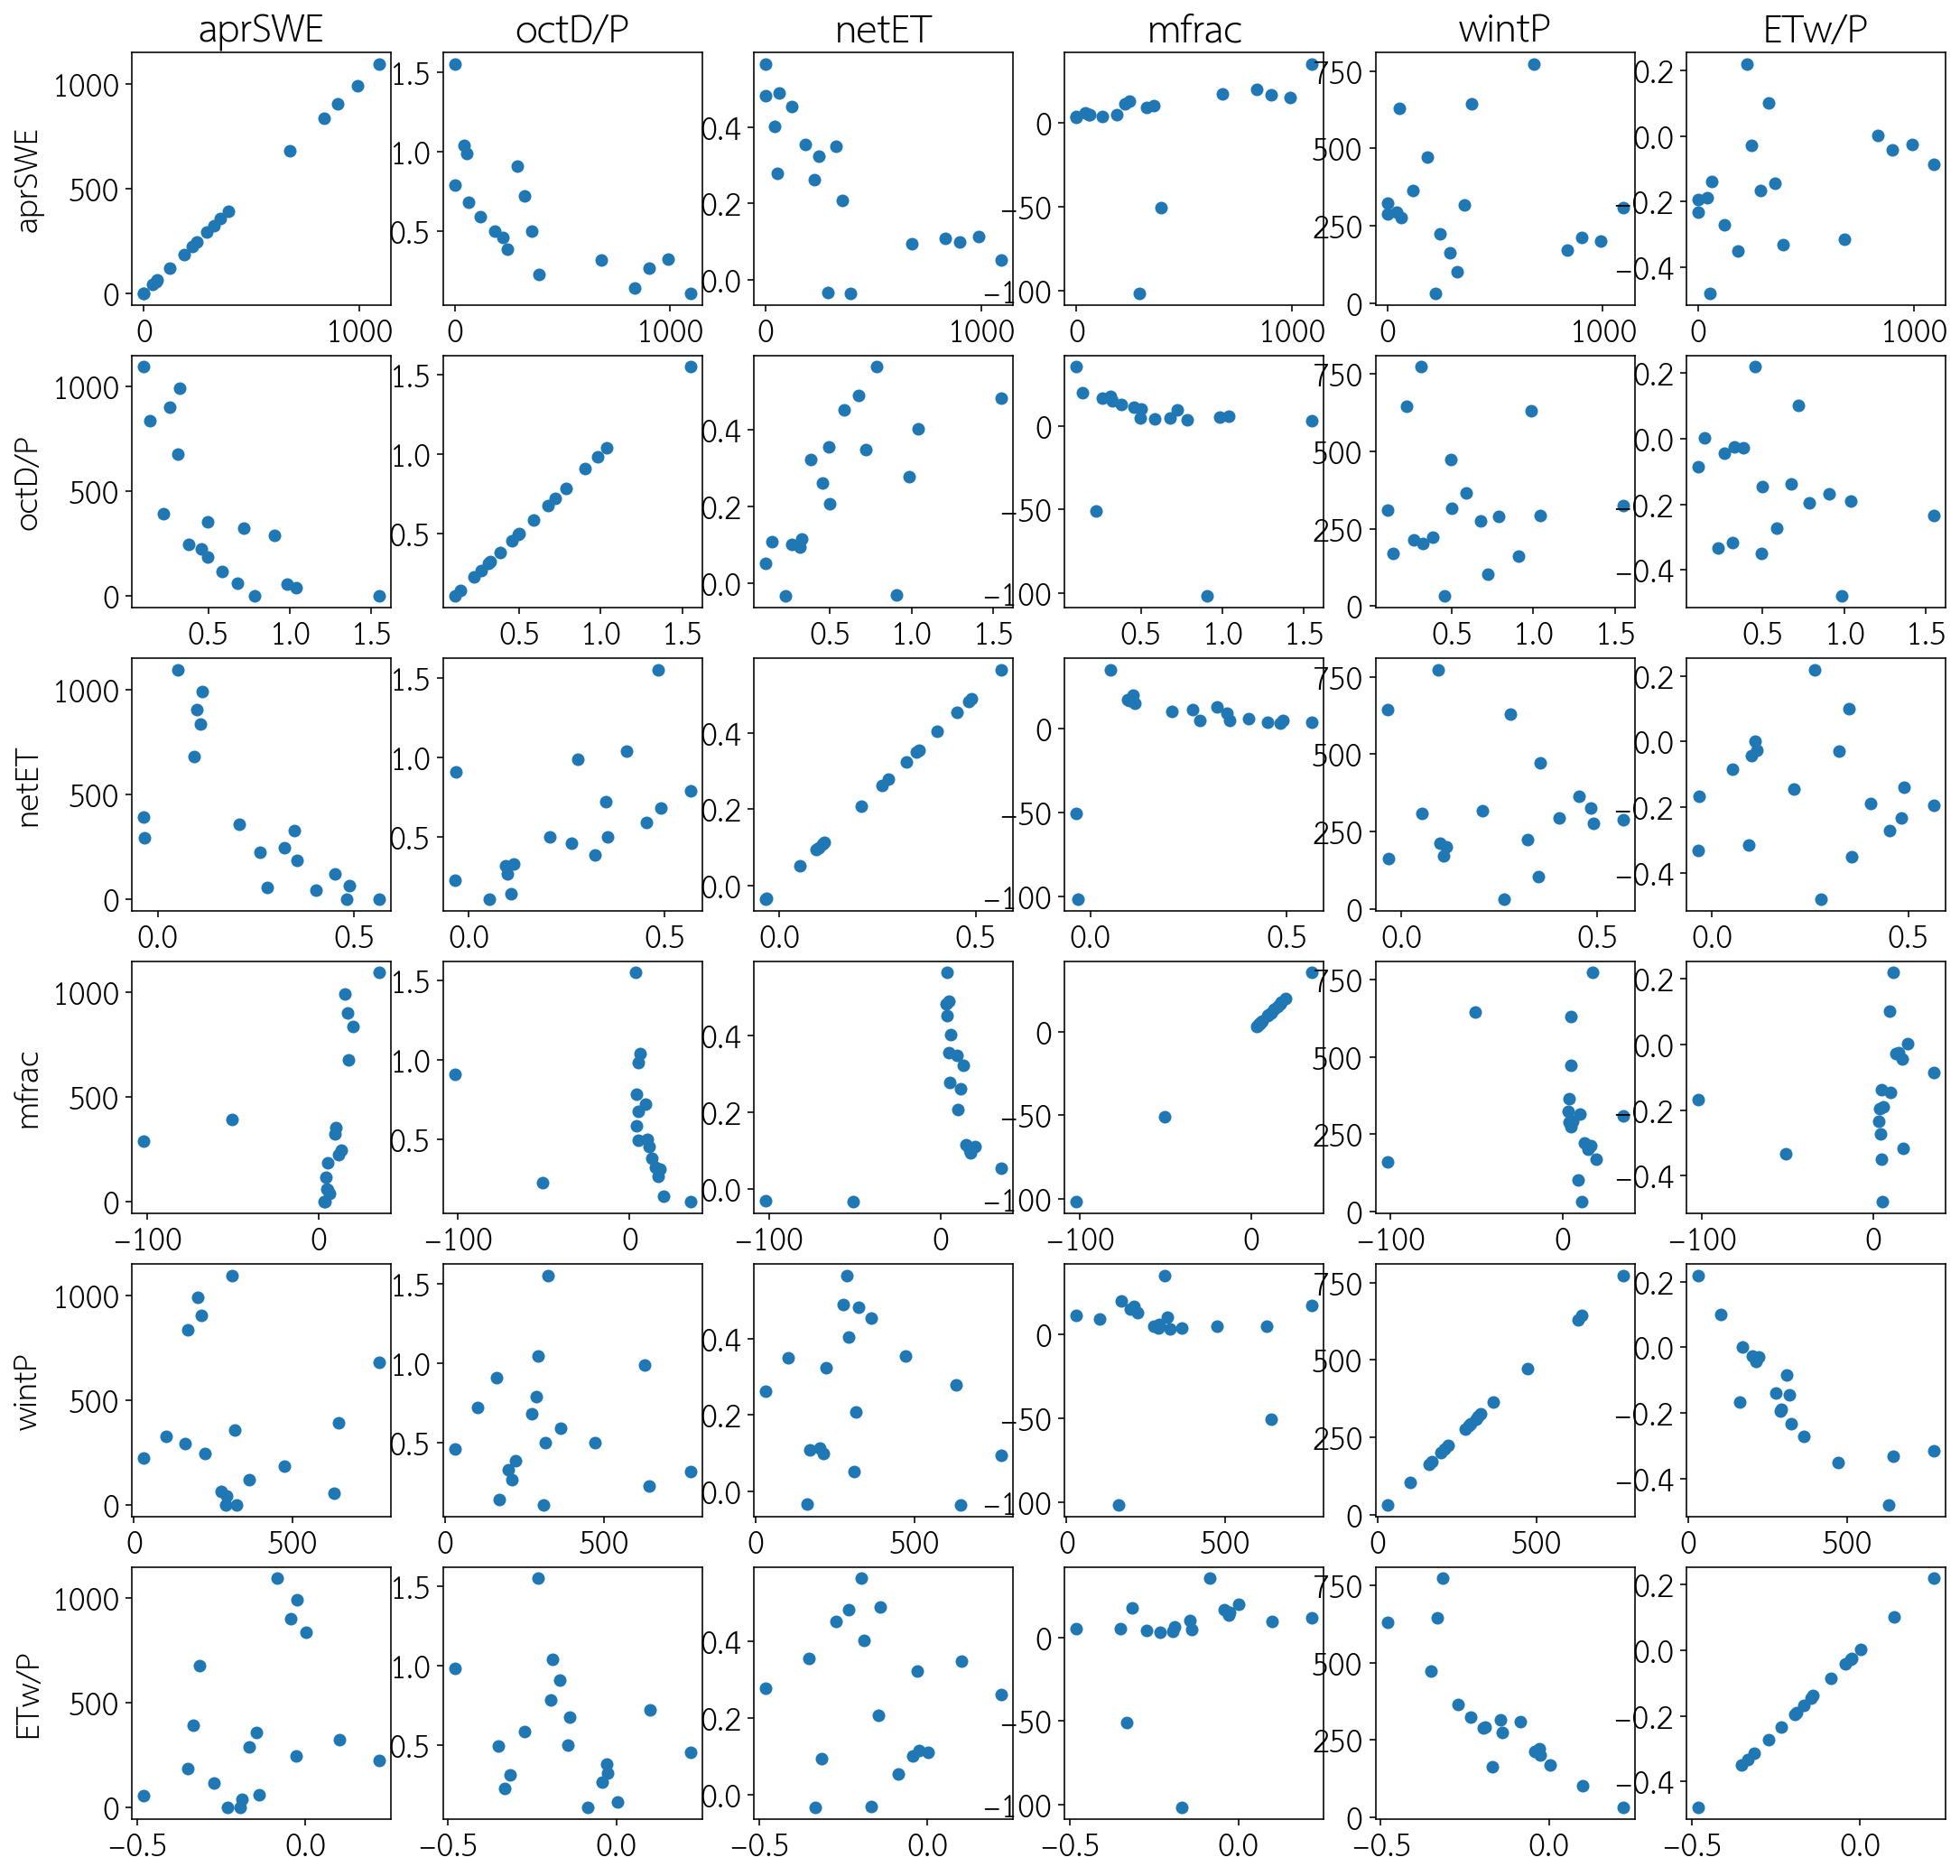

In [ ]:
# plot all variables against each other
# correlated variables will make this approach less reliable
# some variables are a little bit correlated, but I messed around with this a lot
# and this is the best we can do

fig,axs = plt.subplots(len(variables_to_test),len(variables_to_test),
                      figsize = (3*len(variables_to_test),3*len(variables_to_test)))

for i in range(len(variables_to_test)):
  for j in range(len(variables_to_test)):
    ax = axs[i][j]
    ax.scatter(data[variables_to_test[i]],data[variables_to_test[j]])
    if i==0:
      ax.set_title(variables_to_test[j])
    if j==0:
      ax.set_ylabel(variables_to_test[i])



In [ ]:
# print out results
df= pd.DataFrame.from_dict(results1)
# results_dry.pop('const')
df_dry= pd.DataFrame.from_dict(results_dry)
df_wet= pd.DataFrame.from_dict(results_wet)
df['percent_diff'] = -(df.Q2021-df.pred2021)/df.Q2021*100
df_dry['percent_diff'] = -(df_dry.Q2021-df_dry.pred2021)/df_dry.Q2021*100
df = df[['site','Apr 1 SWE','snowfrac','const','Oct D','netET','ETw/P','mfrac',
        #  'percent_diff',
         'r2','SWE_D_only_r2','justSWE_r2','r2wet','crossval','crossval_swe','crossval_swed',
         'crossval_wet','crossval_dry','crossval_swe_wet','crossval_swe_dry','crossval_swed_wet',
         'crossval_swed_dry'
        #  'pred2021','Q2021','pred2021_SWE_D'
         ]]
df_dry = df_dry[['site','Apr 1 SWE','snowfrac',
                 'const',
                 'Oct D','netET','ETw/P','mfrac',
        #  'percent_diff',
         'r2','SWE_D_only_r2','justSWE_r2','r2dry'
        #  'pred2021','Q2021','pred2021_SWE_D'
         ]]
df_wet = df_wet[['site','Apr 1 SWE','snowfrac',
                #  'const',
                 'Oct D','netET','ETw/P','mfrac',
                 'r2wet'
        #  'percent_diff',
        #  'r2','SWE_D_only_r2','justSWE_r2','r2dry'
        #  'pred2021','Q2021','pred2021_SWE_D'
         ]]
# print(df_dry.to_latex(float_format='%2.0f',index=False))
df_wet.median()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Apr 1 SWE     28.553758
snowfrac     107.659243
Oct D        -22.622811
netET        -41.841237
ETw/P         21.660623
mfrac          0.648819
r2wet          0.851308
dtype: float64

In [ ]:
df_dry_normalize = df_wet[['Apr 1 SWE','snowfrac',
                           'Oct D','netET','ETw/P','mfrac',
                           ]]
sums = df_dry_normalize.abs().sum(axis=1).values.flatten()
for col in df_dry_normalize.columns:
  df_dry_normalize[col] = df_dry_normalize[col].values.flatten()/sums
df_dry_normalize#.median()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Apr 1 SWE  snowfrac     Oct D     netET     ETw/P     mfrac
0    0.401927  0.338292 -0.118784 -0.119994  0.014131 -0.006873
1    0.324917 -0.251820 -0.122735 -0.045306 -0.251420  0.003801
2    0.501069  0.229260 -0.136601 -0.111470  0.010259  0.011341
3    0.518906  0.134742 -0.172763 -0.122024 -0.043364  0.008201
4    0.648050  0.078340 -0.093153 -0.108052 -0.064535  0.007870
5    0.119706  0.539999 -0.072977 -0.022735  0.200277 -0.044307
6    0.043319  0.396065  0.052222 -0.078460  0.426585 -0.003348
7    0.110120  0.423517 -0.043219 -0.255336  0.132300 -0.035508
8    0.032310  0.386978 -0.121654 -0.243583  0.214308 -0.001167
9    0.069337  0.449296 -0.094412 -0.215327  0.165075  0.006553
10   0.435301  0.282839 -0.079340 -0.096739  0.085684  0.020097
11   0.386508  0.408338 -0.034009 -0.118305  0.051565  0.001276
12   0.133742  0.446822 -0.075633 -0.231930  0.106563  0.005310
13   0.005933  0.533077 -0.126548 -0.009972  0.322391 -0.002079
14   0.060834 -0.177712 -0.041266 -0.549441 -0.116381  0.054366

In [ ]:
76(df.SWE_D_only_r2-f.justSWE_r2).median(), df.SWE_D_only_r2.median()

(-0.04222532626084763, 0.7882591842787454)

In [ ]:
dfdf = df['r2wet'].to_frame().merge(df_dry['r2dry'],left_index=True,right_index=True)
(dfdf.r2wet-dfdf.r2dry).median()
# dfdf.median()
# dfdf
%matplotlib inline

In [ ]:
df.columns

Index(['site', 'Apr 1 SWE', 'snowfrac', 'const', 'Oct D', 'netET', 'ETw/P',
       'mfrac', 'r2', 'SWE_D_only_r2', 'justSWE_r2', 'r2wet'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

snowfrac    0.475926
Oct D       0.125716
netET       0.223418
ETw/P       0.151735
mfrac       0.011491
dtype: float64
snowfrac    0.402828
Oct D       0.239845
netET       0.113856
ETw/P       0.129796
mfrac       0.013608
dtype: float64


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

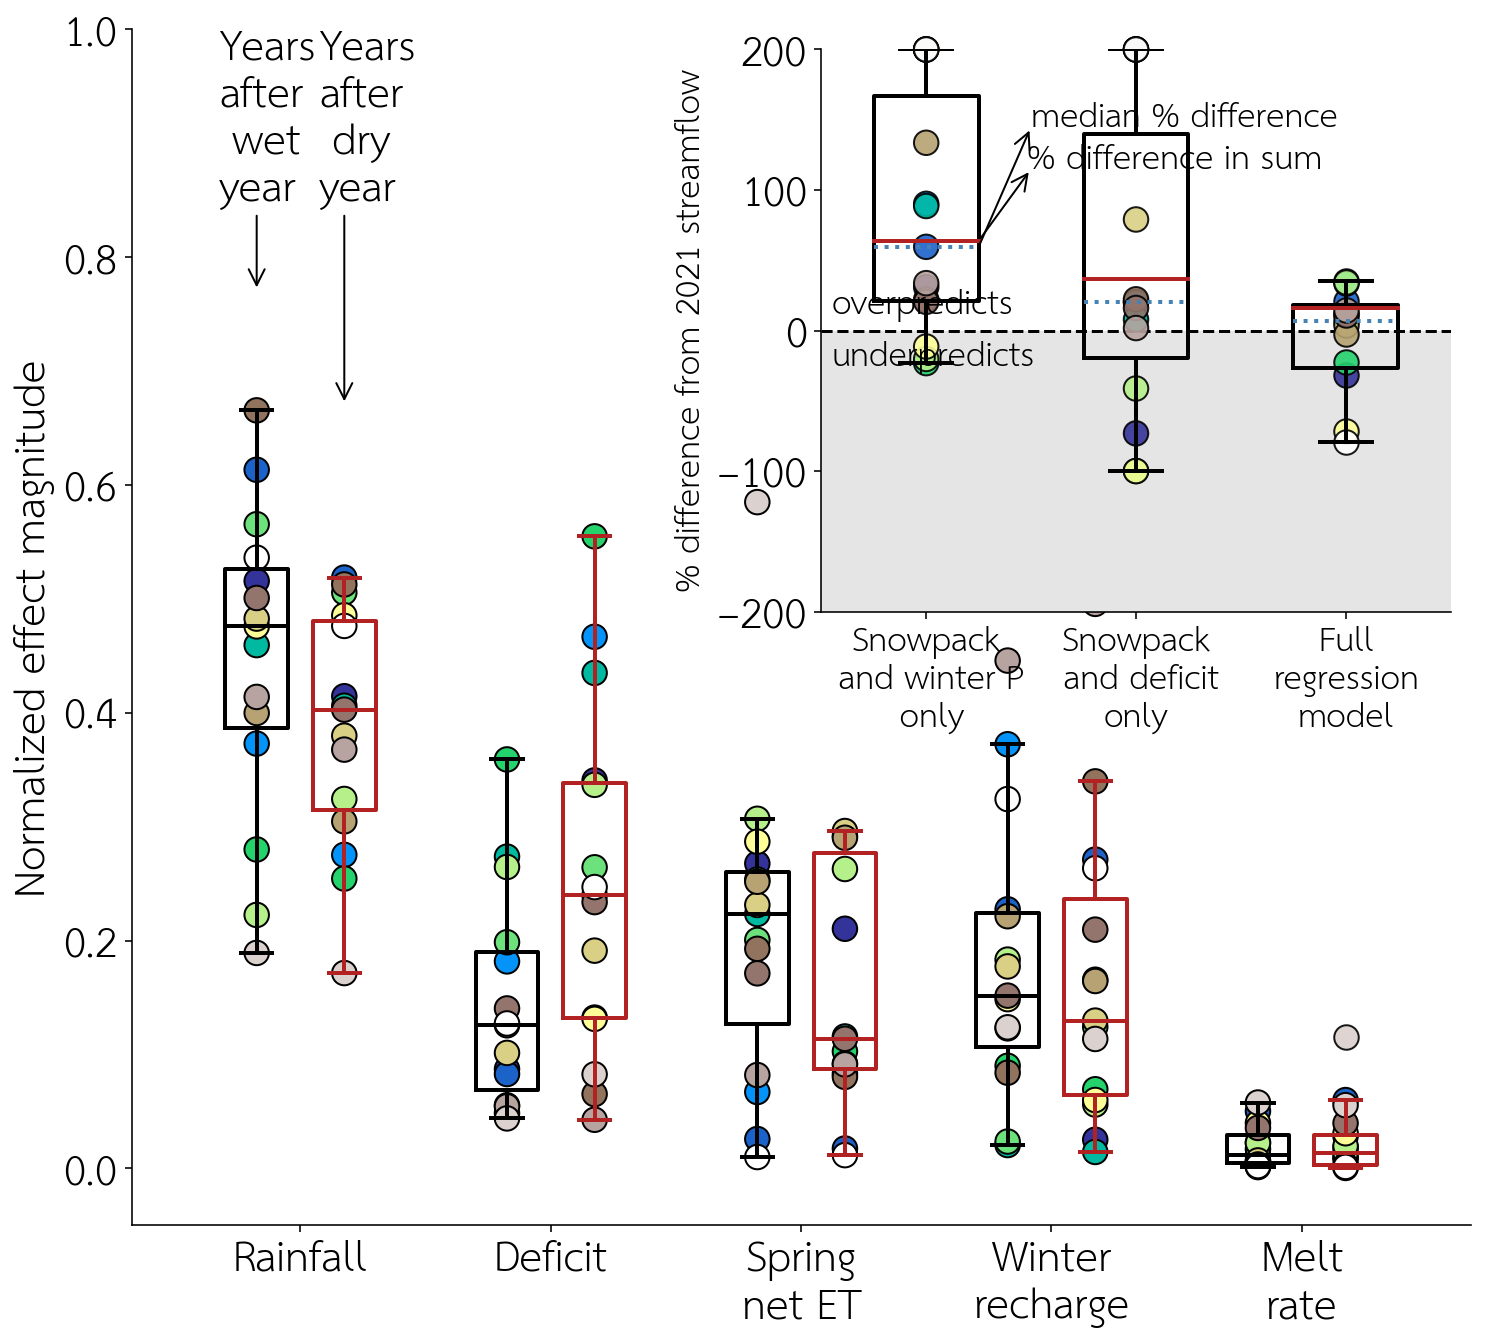

In [ ]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
plt.rcParams.update({'font.size': 20})
fig,ax0 = plt.subplots(1,figsize = (12,11),sharex=True)




colors = cm.terrain(np.linspace(0, 1, 15))
cols = ['snowfrac','Oct D','netET',
            'ETw/P','mfrac']
colnames = {'Apr 1 SWE':'Snowpack',#'SWE',
            # 'const': 'Const.',
            'snowfrac': 'Rainfall',#'(spring + winter rain) /\nWY P',
            'Oct D': 'Deficit',#'Oct. 1 D /\nWY P',
            'netET': 'Spring\nnet ET',#\n(accounting for\nspring rain)',#(spring ET - rain) /\nWY P',
            'ETw/P': 'Winter\nrecharge',#'(winter ET - rain) /\nWY P',
            'mfrac': 'Melt\nrate',#'melt rate /\n(spring ET - rain)',
            'wintP':'Winter\nrain'
            }
ticknames = [colnames[c] for c in cols]
size = 150

ax = ax0
d1 = df[[
         'snowfrac',
          'Oct D',
          'netET',
          'ETw/P',
          'mfrac',]]

rowsums = d1.abs().sum(axis=1)
for c in d1.columns:
  d1[c] = d1[c]/rowsums
print(d1.abs().median())
d1['site'] = df.site
d1 = d1.set_index('site').sort_index().reset_index()

for i in range(len(cols)):
  col = cols[i]
  ax.scatter([i]*len(d1),
             d1[col].abs().values.flatten(),
             c=colors,
             s = size,
             edgecolor = 'k')
  ax.boxplot(d1[col].abs().values.flatten(),
             positions=[i],widths = 0.25,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='black'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)

ax.set_xticks(list(range(i+1)))
ax.set_xticklabels(ticknames)#,rotation = 45)
ax.set_ylabel('Normalized effect magnitude')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_title('Wet years')
# ax.set_ylim(-10,100)


ax = ax0
d1 = df_dry[[
         'snowfrac',
          'Oct D',
          'netET',
          'ETw/P',
          'mfrac',]]

rowsums = d1.abs().sum(axis=1)
for c in d1.columns:
  d1[c] = d1[c]/rowsums
print(d1.abs().median())
d1['site'] = df.site
d1 = d1.set_index('site').sort_index().reset_index()

for i in range(len(cols)):
  col = cols[i]
  ax.scatter([i+0.35]*len(d1),
             d1[col].abs().values.flatten(),
             c=colors,
             s = size,
             edgecolor = 'k')
  ax.boxplot(d1[col].abs().values.flatten(),
             positions=[i+0.35],widths = 0.25,
           boxprops= dict(linewidth=2.0, color='firebrick'),
           whiskerprops = dict(linewidth=2.0, color='firebrick'),
           medianprops = dict(linewidth=2.0, color='firebrick'),
           capprops = dict(linewidth=2.0, color='firebrick'),
           showfliers=False)

ax.set_xticks([p+.175 for p in list(range(i+1))])
ax.set_xticklabels(ticknames)#,rotation = 45)
ax.set_ylabel('Normalized effect magnitude')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_title('Dry Years')
# ax.set_ylim(-10,100)
ax.text(-.15,.85,'Years\nafter\n wet\nyear')
ax.text(.25,.85,'Years\nafter\n dry\nyear')
ax.annotate("", xy=(0,.77), xytext=(0,.84),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(.35,.67), xytext=(.35,.84),
            arrowprops=dict(arrowstyle="->"))
ax.set_ylim(-.05,1)


ax = inset_axes(ax0, width="47%", height="47%", loc=1)
fs = 16
df= pd.DataFrame.from_dict(results1)
diff = (df.pred2021-df.Q2021)/df.Q2021
# diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[2],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
for i in range(len(diff)):
  ax.scatter([2],[diff[i]*100],
           s = size,edgecolor = 'k',c=colors[i],
          #  marker = '*',
           alpha=0.9,clip_on=False,#label='Best model',
           label = df.site.values[i])
medval = np.nanmedian(diff)*100
sumval = np.nansum(df.pred2021-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='skyblue',lw=2)
med_diffs = [medval]
sum_diffs = [sumval]

diff_from = np.where(df.pred2021_SWE_D<0,0,df.pred2021_SWE_D)
diff = (diff_from-df.Q2021)/df.Q2021
diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[1],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'))
ax.scatter([1]*len(diff),diff*100
           ,s = size,edgecolor = 'k',c=colors,clip_on=False,
          #  label = 'SWE and D/winter P only',
           label = None,
           alpha=0.9)
medval = np.nanmedian(np.array(diff))*100
sumval= np.nansum(df.pred2021_SWE_D-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='firebrick',lw=2)
med_diffs.append(medval)
sum_diffs.append(sumval)

diff = (df.pred2021_SWE-df.Q2021)/df.Q2021
diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[0],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
ax.scatter([0]*len(diff),diff*100
           ,s=size,edgecolor = 'k',c=colors,clip_on=False,
          #  label = 'SWE and winter P only',
           label = None,
          #  marker = 's',
           alpha=0.9)
medval = np.nanmedian(diff*100)
sumval = np.nansum(df.pred2021_SWE-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='goldenrod',lw=2)
med_diffs.append(medval)
sum_diffs.append(sumval)

ax.set_xticks([0,1,2])
ax.set_xticklabels(['Snowpack\n and winter P\n only',
                    'Snowpack\n and deficit\nonly',
                    'Full\nregression\nmodel'],
                    # ['SWE only',
                    # 'SWE and\nD/winter P\nonly',
                    # 'Full\nregression\nmodel',
                    # ],
                   rotation = 0,fontsize = fs)
# ax.legend(loc='lower right',bbox_to_anchor=(1.5,-.5))
ax.set_ylim(-200,200)
ax.axhline(0,c='k',ls='--',zorder = -1)
# ax.set_xlabel('Actual 2021 spring streamflow (mm)')
ax.set_ylabel('% difference from 2021 streamflow',fontsize = fs)
ax.axhspan(-300,0,facecolor = 'k',alpha=0.1,zorder=-1)
ax.text(-.45,12
        ,'overpredicts',fontsize = fs)
ax.text(-.45,-25,'underpredicts', fontsize = fs)



ax.annotate("", xy=(.25,sum_diffs[2]), xytext=(.5,115),
            arrowprops=dict(arrowstyle="<-"))
ax.text(.48,115,'% difference in sum',fontsize = fs)
ax.annotate('', xy=(.25,med_diffs[2]), xytext=(.5,145),
            arrowprops=dict(arrowstyle="<-"))
ax.text(.5,145,"median % difference",fontsize = fs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

a = [2,1,0]
for i in range(3):
  ax.plot([a[i]-.25,a[i]+.25],[sum_diffs[i]]*2,
        c='firebrick',lw=2)
  
# ax0.text(-.5,0.78,'a)')
# ax1.text(-.5,208,'b)')
plt.savefig('regression_results.png',format='png',dpi=300,bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Oct D    0.214452
netET    0.413356
ETw/P    0.283685
mfrac    0.023678
dtype: float64
Oct D    0.391612
netET    0.190658
ETw/P    0.228666
mfrac    0.024401
dtype: float64


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

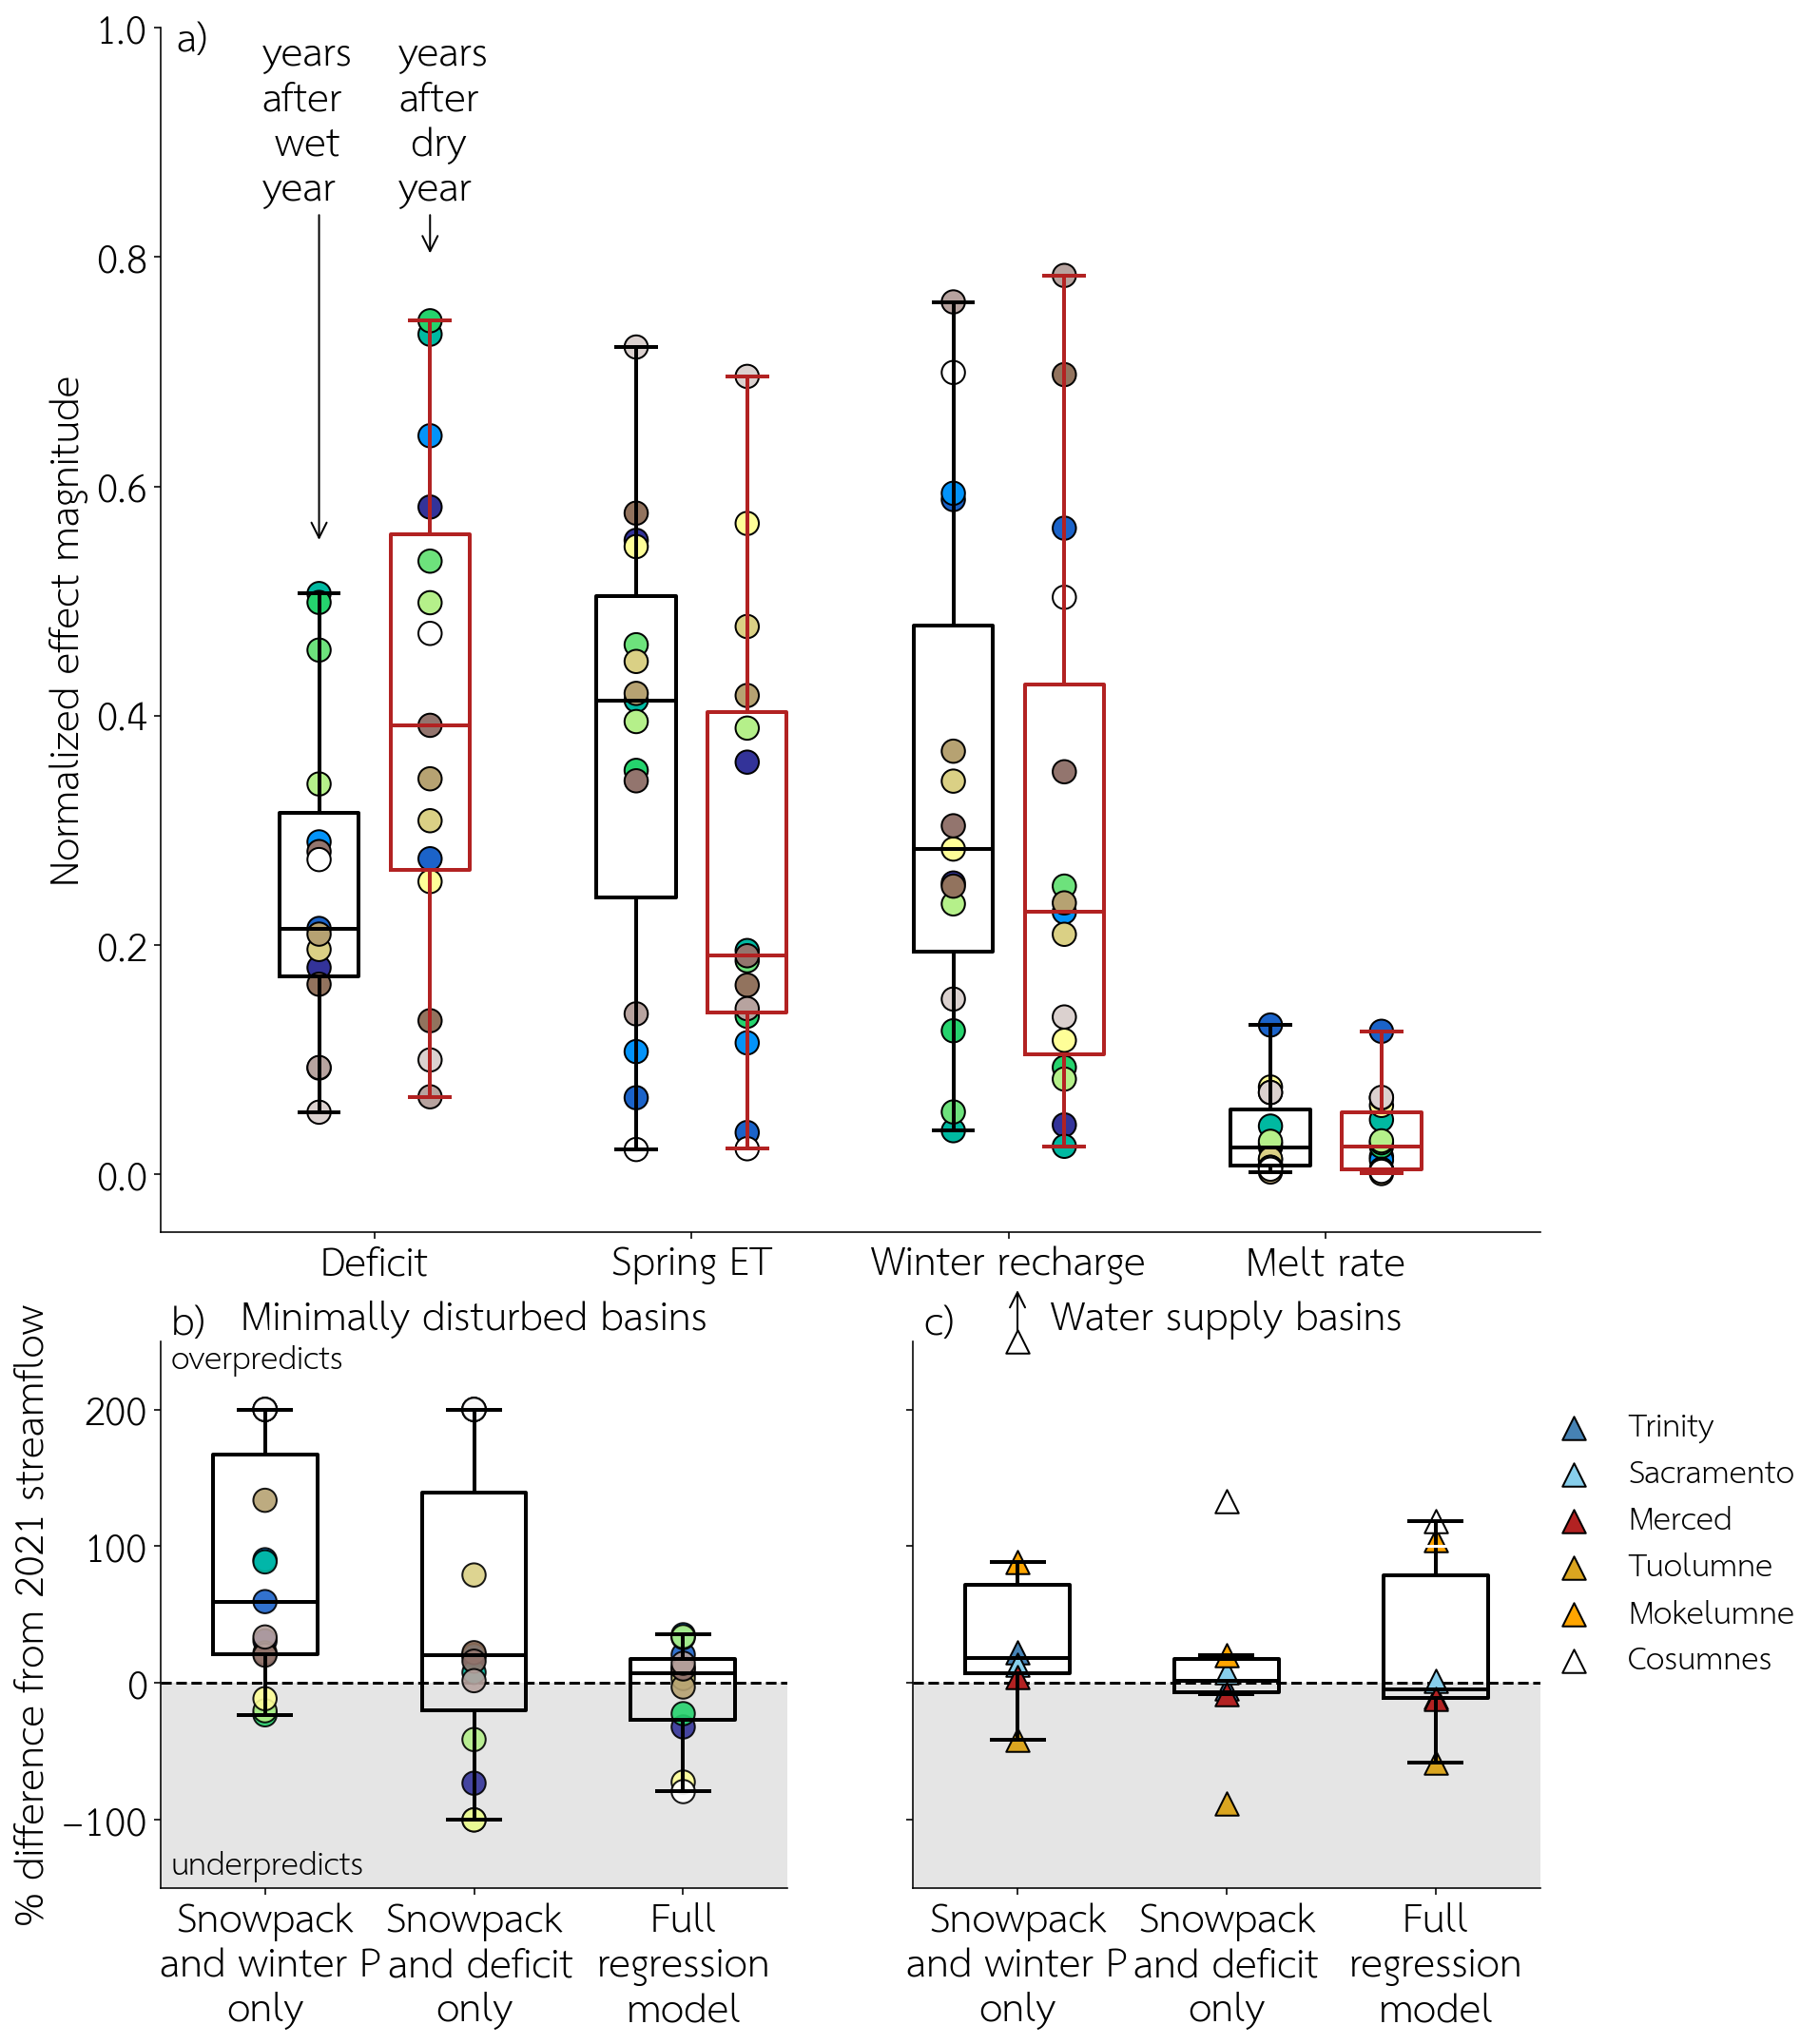

In [ ]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
plt.rcParams.update({'font.size': 20})
# fig,ax0 = plt.subplots(1,figsize = (12,11),sharex=True)
fig = plt.figure(figsize = (13,18))

gs = gridspec.GridSpec(3, 2, figure=fig)
ax0 = fig.add_subplot(gs[:2,:])
ax1 = fig.add_subplot(gs[2,0])
ax2 = fig.add_subplot(gs[2,1])


colors = cm.terrain(np.linspace(0, 1, 15))
cols = ['snowfrac','Oct D','netET',
            'ETw/P','mfrac']
colnames = {'Apr 1 SWE':'Snowpack',#'SWE',
            # 'const': 'Const.',
            'snowfrac': 'Rainfall',#'(spring + winter rain) /\nWY P',
            'Oct D': 'Deficit',#'Oct. 1 D /\nWY P',
            'netET': 'Spring ET',#\n(accounting for\nspring rain)',#(spring ET - rain) /\nWY P',
            'ETw/P': 'Winter recharge',#'(winter ET - rain) /\nWY P',
            'mfrac': 'Melt rate',#'melt rate /\n(spring ET - rain)'
            }
ticknames = [colnames[c] for c in cols if c!='snowfrac']
size = 150

ax = ax0
d1 = df[[
        #  'snowfrac',
          'Oct D',
          'netET',
          'ETw/P',
          'mfrac',]]

rowsums = d1.abs().sum(axis=1)
for c in d1.columns:
  d1[c] = d1[c]/rowsums
print(d1.abs().median())
d1['site'] = df.site
d1 = d1.set_index('site').sort_index().reset_index()

for i in range(len(cols)):
  col = cols[i]
  if col!='snowfrac':
    ax.scatter([i]*len(d1),
              d1[col].abs().values.flatten(),
              c=colors,
              s = size,
              edgecolor = 'k')
    ax.boxplot(d1[col].abs().values.flatten(),
              positions=[i],widths = 0.25,
            boxprops= dict(linewidth=2.0, color='black'),
            whiskerprops = dict(linewidth=2.0, color='black'),
            medianprops = dict(linewidth=2.0, color='black'),
            capprops = dict(linewidth=2.0, color='black'),
            showfliers=False)

ax.set_xticks(list(range(1,i+1)))
ax.set_xticklabels(ticknames)#,rotation = 45)
ax.set_ylabel('Normalized effect magnitude')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_title('Wet years')
# ax.set_ylim(-10,100)


ax = ax0
d1 = df_dry[[
        #  'snowfrac',
          'Oct D',
          'netET',
          'ETw/P',
          'mfrac',]]

rowsums = d1.abs().sum(axis=1)
for c in d1.columns:
  d1[c] = d1[c]/rowsums
print(d1.abs().median())
d1['site'] = df.site
d1 = d1.set_index('site').sort_index().reset_index()

for i in range(len(cols)):
  col = cols[i]
  if col!='snowfrac':
    
    ax.scatter([i+0.35]*len(d1),
              d1[col].abs().values.flatten(),
              c=colors,
              s = size,
              edgecolor = 'k')
    ax.boxplot(d1[col].abs().values.flatten(),
              positions=[i+0.35],widths = 0.25,
            boxprops= dict(linewidth=2.0, color='firebrick'),
            whiskerprops = dict(linewidth=2.0, color='firebrick'),
            medianprops = dict(linewidth=2.0, color='firebrick'),
            capprops = dict(linewidth=2.0, color='firebrick'),
            showfliers=False)

ax.set_xticks([p+.175 for p in list(range(1,i+1))])
ax.set_xticklabels(ticknames)#,rotation = 45)
ax.set_ylabel('Normalized effect magnitude')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_title('Dry Years')
# ax.set_ylim(-10,100)
ax.text(1-.18,.85,'years\nafter\n wet\nyear')
ax.text(1.25,.85,'years\nafter\n dry\nyear')
ax.annotate("", xy=(1,.55), xytext=(1,.84),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(1.35,.8), xytext=(1.35,.84),
            arrowprops=dict(arrowstyle="->"))
ax.set_ylim(-.05,1)


ax = ax1#inset_axes(ax0, width="47%", height="47%", loc=1)

fs = 16
df= pd.DataFrame.from_dict(results1)
diff = (df.pred2021-df.Q2021)/df.Q2021
# diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[2],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='black',),#color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
for i in range(len(diff)):
  ax.scatter([2],[diff[i]*100],
           s = size,edgecolor = 'k',c=colors[i],
          #  marker = '*',
           alpha=0.9,clip_on=False,#label='Best model',
           label = df.site.values[i])
medval = np.nanmedian(diff)*100
sumval = np.nansum(df.pred2021-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='skyblue',lw=2)
med_diffs = [medval]
sum_diffs = [sumval]

diff_from = np.where(df.pred2021_SWE_D<0,0,df.pred2021_SWE_D)
diff = (diff_from-df.Q2021)/df.Q2021
diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[1],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0,color='black'),# color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
ax.scatter([1]*len(diff),diff*100
           ,s = size,edgecolor = 'k',c=colors,clip_on=False,
          #  label = 'SWE and D/winter P only',
           label = None,
           alpha=0.9)
medval = np.nanmedian(np.array(diff))*100
sumval= np.nansum(df.pred2021_SWE_D-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='firebrick',lw=2)
med_diffs.append(medval)
sum_diffs.append(sumval)

diff = (df.pred2021_SWE-df.Q2021)/df.Q2021
diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[0],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0,color = 'black'),# color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
ax.scatter([0]*len(diff),diff*100
           ,s=size,edgecolor = 'k',c=colors,clip_on=False,
          #  label = 'SWE only',
           label = None,
          #  marker = 's',
           alpha=0.9)
medval = np.nanmedian(diff*100)
sumval = np.nansum(df.pred2021_SWE-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='goldenrod',lw=2)
med_diffs.append(medval)
sum_diffs.append(sumval)

ax.set_xticks([0,1,2])
ax.set_xticklabels(['Snowpack\n and winter P\nonly',
                    'Snowpack\n and deficit\nonly',
                    'Full\nregression\nmodel'],
                    # ['SWE only',
                    # 'SWE and\nD/winter P\nonly',
                    # 'Full\nregression\nmodel',
                    # ],
                   rotation = 0,)
# ax.legend(loc='lower right',bbox_to_anchor=(1.5,-.5))

# ax.set_xlabel('Actual 2021 spring streamflow (mm)')
ax.set_ylabel('% difference from 2021 streamflow')#nat minimally disturbed sites',)




# ax.annotate("", xy=(1.25,sum_diffs[1]), xytext=(1.5,145),
#             arrowprops=dict(arrowstyle="<-"))
# ax.text(1.48,145,'% difference in sum',fontsize = fs)
# ax.annotate('', xy=(1.25,med_diffs[1]), xytext=(1.5,115),
#             arrowprops=dict(arrowstyle="<-"))
# ax.text(1.5,115,"median % difference",fontsize = fs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xticklabels(['','',''])

# a = [2,1,0]
# for i in range(3):
#   ax.plot([a[i]-.25,a[i]+.25],[sum_diffs[i]]*2,
#         c='firebrick',lw=2)
  
ax = ax2

swe_err = [22.505478595053738,
 13.796908791881343,
 4.616078855676496,
 -41.14869425975382,
 88.53747344168535,
 405.624636877257]
swed_err = [-3.8203191696367695,
 7.571527957420167,
 -8.064830092214452,
 -87.88956699195506,
 20.650833963757613,
 133.0290988001507]
all_err = [-10.400420059036888,
 1.4900291810182729,
 -11.329945509405025,
 -58.093248526740915,
 104.67182216727464,
 118.45701313199211]

colors = ['steelblue','skyblue','firebrick','goldenrod',
          'orange','white']
sitenames = ['Trinity',
       'Sacramento',
       'Merced',
       'Tuolumne',
       'Mokelumne',
       'Cosumnes']

for i in range(len(swed_err)):
  ax.scatter([0],swe_err[i],s=size,
           edgecolor = 'k',c=colors[i],label=sitenames[i],marker = '^')
ax.boxplot(swe_err,positions=[0],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0,color = 'black'),# color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
ax.scatter([0],[250],s=size,edgecolor = 'k',c=colors[i],label=None,
           clip_on=False,marker = '^')
ax.annotate('',xy = (0,250),
            xytext = (0,290),
            arrowprops = dict(arrowstyle="<-",
                            connectionstyle="arc3"),
            clip_on=False, zorder = -1
            )

for i in range(len(swed_err)):
  ax.scatter([1],swed_err[i],s=size,
           edgecolor = 'k',c=colors[i],label=None,marker = '^')
ax.boxplot(swed_err,positions=[1],widths=0.5,
          boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='black',),#color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)

for i in range(len(all_err)):
  ax.scatter([2],all_err[i],s=size,
           edgecolor = 'k',c=colors[i],label=None,marker = '^')
ax.boxplot(all_err,positions=[2],widths=0.5,
          boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='black',),#color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)

# ax.set_ylim(-300,300)
# ax.set_xticks([0,1,2])
ax.set_xticklabels(['Snowpack\nand winter P\nonly','Snowpack\nand deficit\nonly','Full\nregression\nmodel'])
# ax.set_ylabel('% error in 2021 streamflow\nat 6 basins important to water supply',)

ax.legend(loc='upper right',bbox_to_anchor = (1.45,.92),frameon=False,
          fontsize = fs)

# ax.text(-0.45,5,'overpredicts',fontsize = fs)
# ax.text(-0.45,-15,'underpredicts', fontsize = fs)
ax.plot([1.75,2.25],[100,100],c='white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
ax.set_title('Water supply basins',fontsize = 20)

sum_diffs = [103.7,2.6]

# for i in range(2):
#   ax.plot([i-.25,i+.25],[sum_diffs[i]]*2,
#         c='firebrick',lw=2)

for ax in [ax1,ax2]:
  ax.axhspan(-300,0,facecolor = 'k',alpha=0.1,zorder=-1)
  ax.set_ylim(-150,250)
  ax.axhline(0,c='k',ls='--',zorder = -1)   

ax = ax1
ax.text(-.45,230
        ,'overpredicts',fontsize = fs)
ax.text(-.45,-140,'underpredicts', fontsize = fs)
ax.set_title('Minimally disturbed basins',fontsize = 20)


ax0.text(1-.45,0.98,'a)')
ax1.text(-.45,255,'b)')
ax2.text(-.45,255,'c)')
plt.savefig('regression_results_all.png',format='png',dpi=300,bbox_inches='tight')

In [ ]:
np.nanmedian(swe_err),np.nanmedian(swed_err),np.nanmedian(all_err)

(18.15119369346754, 1.8756043938916986, -4.455195439009308)

In [ ]:
sum_diffs, med_diffs

([103.7, 2.6], [6.956899557754219, 20.0641689220349, 59.55790642209532])

In [ ]:
# print out percent errors for (best, SWE and D/wintP, SWE)
med_diffs, sum_diffs

([6.956899557754219, 20.0641689220349, 59.55790642209532], [103.7, 2.6])

In [ ]:
sum_diffs,med_diffs

([103.7, 2.6], [6.956899557754219, 20.0641689220349, 59.55790642209532])